<font size="5">Skin Lesion Classification Using Deep Learning</font>





<font size="4.5">Group Name: Neural Network Out!</font>

Lihao Wang (z5474242)<br>
Haosheng Ren (z5484476)<br>
Chaorong Lei (z5405778)<br>
Xuefei He (z5504912)<br>
Zelong Hu (z5507000)

## Table of Contents
- [1 Introduction](#scrollTo=7opbYs4GeEhg)
  - [1.1 Motivation](#scrollTo=ESfg4ipByyj7)
  - [1.2 Problem Statement](#scrollTo=cKbuI1CwJRM3)
- [2 Data Source](#scrollTo=iHIQLp2UOhTI)
- [3 Analysis of Data](#scrollTo=yd-Jua-lpzgf)
  - [3.1 Original Data Overview](#scrollTo=5w7l4t9eQH3B)
  - [3.2 Some Attempts](#scrollTo=gWIOk9xHrAag)
  - [3.3 Processed Dataset](#scrollTo=qEikPoSIoEuY)
- [4 Models and Methods](#scrollTo=pQ-guOeQmQig)
  - [4.1 Model - Feature Extraction (VGG16)](#scrollTo=ND0x3w37NdAa)
  - [4.2 Model - Feature Extraction (ResNet50)](#scrollTo=82jWDXX7eyKl)
  - [4.3 Model - Feature Extraction (ResNet101)](#scrollTo=yQZZzRgp0RGS)
  - [4.4 Model - Feature Extraction (DenseNet201)](#scrollTo=BIPQVDkB2HOf)
- [5 Results](#scrollTo=pQ-guOeQmQig)
 - [5.1 Original Data](#scrollTo=ESvwgKo2F0KI)
 - [5.2 Processed Data](#scrollTo=MVa_0uIsF5dX)
 - [5.3 Final Result](#scrollTo=-yfb8DkdnYFn)
- [6 Discussion](#scrollTo=8dY-Ozf4erxE)
- [7 Reference](#scrollTo=LzkfVOgQNXNV)


# 1 Introduction

In this project, 4 different feature extractions and classifiers have been tested to find the best preformance model to indentify the skin lesion based on the data from ISIC2019.

## 1.1 Motivation




The project that we choose is Skin Lesion Classification Using Deep Learning.
As melanoma is one of the deadliest types of skin cancer, we chose this topic because of the urgent need to enhance the early detection of skin cancer. Defects on or under the skin are collectively known as skin lesions. We can divide them into two broad categories. The first category is benign skin tumors, these are lesions, such as moles or cysts. The second category is malignant tumor, which refers to malignant skin lesions, such as melanoma, basal cell carcinoma. Although skin lesions are common, they are often difficult to identify by their appearance, and it remains difficult to automatically identify malignant tumors from dermoscopic images. Therefore, we want to do a successful deep learning strategy which can identify dermoscopic lesions.

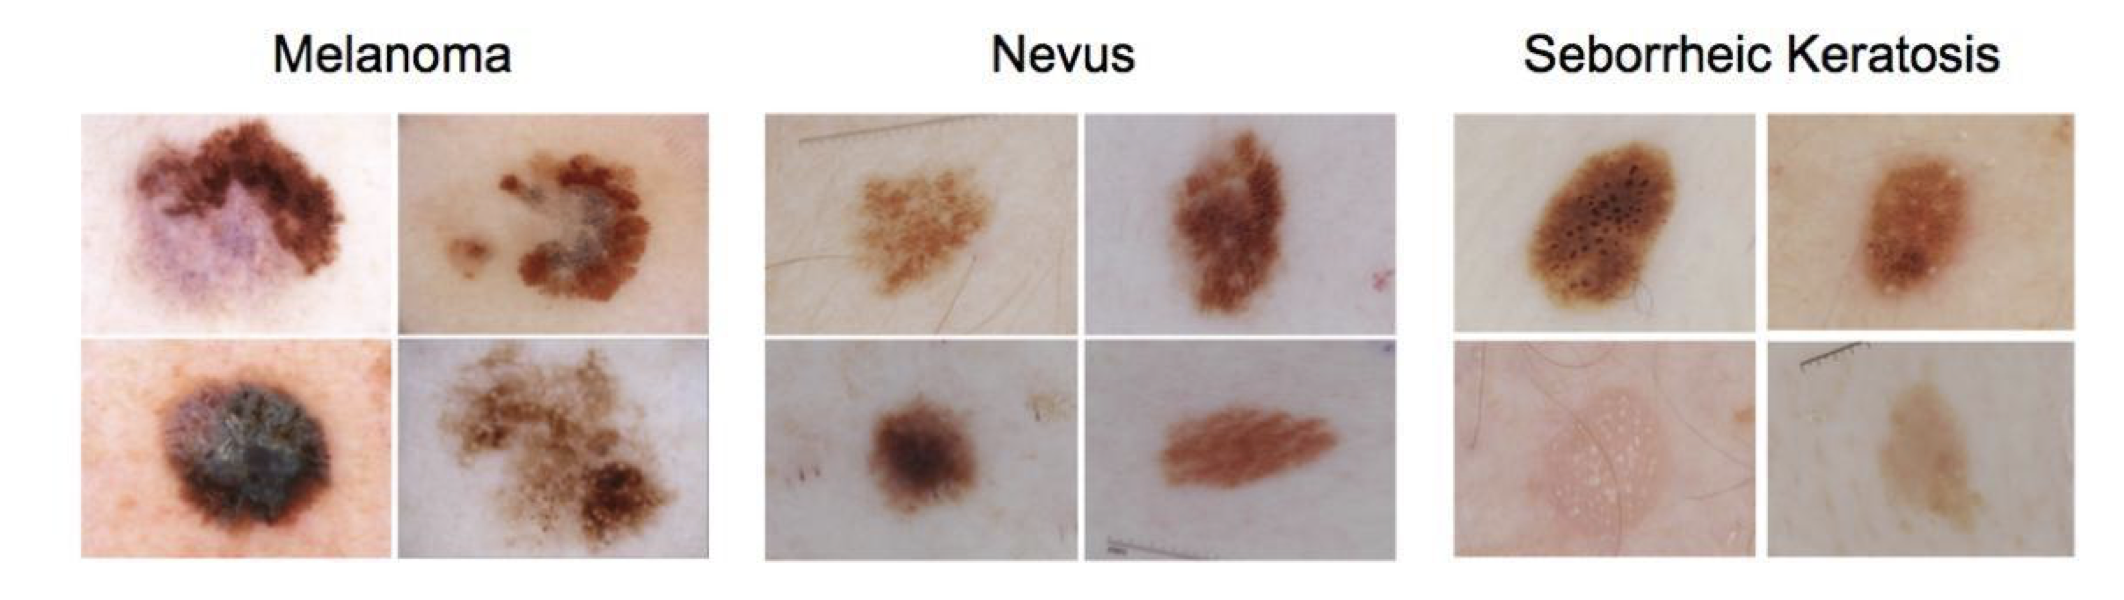
\[1\]https://challenge.isic-archive.com/data/#2019


## 1.2 problem statement


Identifying malignant skin tumors, such as melanoma, from dermoscopic images is challenging due to the complexity and variability of skin lesions. This is the main problem of this project.

Traditional diagnostic methods rely on handcrafted features, which are limited by their dependence on prior information and complex design processes. However, recent advancements in deep learning, especially convolutional neural networks (CNNs), offer promise by automatically learning features directly from image data, thus improving classification accuracy.

Therefore, this project will leverage pre-trained CNN architectures as feature extractors, and evaluate various machine learning classifiers, such as Fine KNN and Cubic SVM, in classifying skin lesions from the ISIC 2019 datasets.

The Goal is to achieve better performance in skin lesion classification to aid in the early and accurate detection of malignant tumors.

# 2 Data Source


## 2.1 Data Overview

Our dataset originates from the ISIC (International Skin Imaging Collaboration), a collaborative effort that focuses on skin imaging. Specifically, the dataset was published in 2019 and includes eight distinct categories of skin diseases. It is a substantial collection, featuring over 20,000 images in the widely-used JPG format. Additionally, the dataset is accompanied by a CSV file containing the corresponding labels for each image in a one-hot encoded format, which facilitates their classification and analysis. This comprehensive resource is an invaluable tool for researchers and practitioners in dermatology and the broader field of medical imaging.

Although the website mentions a relevant test dataset, it is currently inaccessible. Consequently, we have divided the available dataset into three parts, designated as the training set, validation set, and test set, to ensure a robust framework for model development and evaluation.



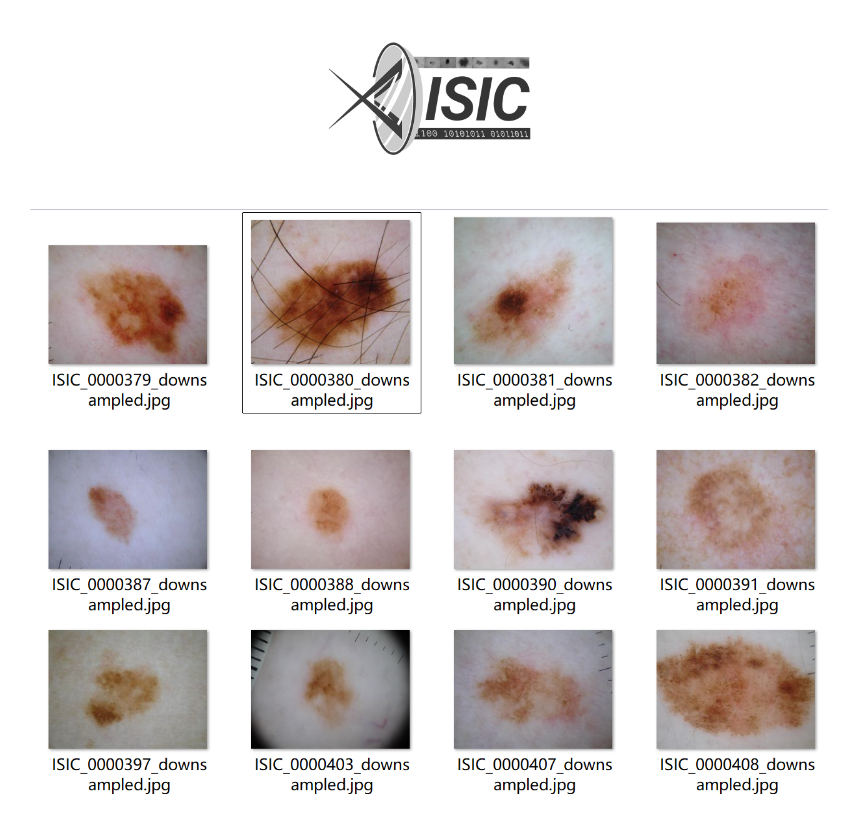
\[1\]https://challenge.isic-archive.com/data/#2019

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Modify the file paths here
csv_file_path = '/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_Input'

data = pd.read_csv(csv_file_path)

# Extract image filenames and labels
image_files = data['image'].values
labels = data.drop(['image', 'UNK'], axis=1).values

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2

# Define a custom dataset class
class SkinDiseaseDataset(Dataset):
    def __init__(self, image_files, labels, image_dir, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx] + ".jpg")
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create training, validation, and testing datasets
train_dataset = SkinDiseaseDataset(train_images, train_labels, image_dir = image_folder_path, transform=transform)
val_dataset = SkinDiseaseDataset(val_images, val_labels, image_dir = image_folder_path, transform=transform)
test_dataset = SkinDiseaseDataset(test_images, test_labels, image_dir = image_folder_path, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Test
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

print(train_dataset[0])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


15198
5066
5067
(tensor([[[-1.9295, -1.8268, -1.6898,  ..., -1.5014, -1.4843, -1.4672],
         [-1.8782, -1.7583, -1.6384,  ..., -1.5357, -1.5185, -1.5014],
         [-1.8097, -1.6898, -1.5699,  ..., -1.5528, -1.5357, -1.5014],
         ...,
         [-1.3644, -1.3644, -1.3815,  ..., -1.9638, -1.9638, -1.9638],
         [-1.3473, -1.3644, -1.3815,  ..., -1.9638, -1.9638, -1.9809],
         [-1.3473, -1.3473, -1.3815,  ..., -1.9638, -1.9638, -1.9809]],

        [[-1.9482, -1.8957, -1.7906,  ..., -1.7206, -1.7031, -1.6856],
         [-1.9132, -1.8431, -1.7381,  ..., -1.7206, -1.7031, -1.6856],
         [-1.8782, -1.8081, -1.6681,  ..., -1.7206, -1.7031, -1.7381],
         ...,
         [-1.6331, -1.6331, -1.6506,  ..., -1.9832, -2.0007, -2.0007],
         [-1.6155, -1.6331, -1.6331,  ..., -1.9832, -2.0007, -2.0182],
         [-1.6155, -1.6331, -1.6331,  ..., -1.9832, -2.0007, -2.0182]],

        [[-1.5779, -1.4559, -1.3339,  ..., -1.3339, -1.3339, -1.3164],
         [-1.5081, -1.4036, 

# 3 Analysis of Data



### 3.1 Original Data Overview

After obtaining the quantity of images for each skin disease, we found that our dataset is highly imbalanced. Therefore, we employed data augmentation and under-sampling to balance it.

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_GroundTruth.csv')

df = df.drop(columns=['image'])
for col in df.columns:
    df[col] = df[col].astype(int)

disease_counts_series = df.loc[:, df.columns != 'UNK'].sum()

# Convert the sum results to integer type
disease_counts = disease_counts_series.astype(int)
disease_counts = disease_counts.rename("Count")

total_count = df.sum().sum()

# Add the Total as a new row to the disease_counts
disease_counts.loc['Total'] = total_count

# Set the disease names as the index
disease_counts.index.name = "Diseases"

# Print the statistics directly
print(disease_counts)

Diseases
MEL       4522
NV       12875
BCC       3323
AK         867
BKL       2624
DF         239
VASC       253
SCC        628
Total    25331
Name: Count, dtype: int64


In our dataset, there is a column labeled "UNK" which contains no images. Therefore, we have removed this column, leaving us with a total of eight skin disease categories.


The original dataset analysis reveals a significant class imbalance, with the 'NV' (Nevi) category having the highest count at 12,875 instances, which is considerably higher than the other skin disease categories. For instance, 'MEL' (Melanoma) has 4,522 instances, 'BCC' (Basal Cell Carcinoma) has 3,323, and 'SCC' (Squamous Cell Carcinoma) has 628. The least represented categories are 'DF' (Dermatofibroma) with only 239 instances and 'VASC' (Vascular) with 253.


To address this imbalance, we will employ undersampling for the 'NV' class to reduce its representation in the training set. This technique will help prevent the model from becoming biased towards the majority class. For the other categories with fewer instances, we will apply data augmentation to artificially increase their numbers and improve the model's ability to generalize.


However, it is important to maintain the original distribution of data in the validation and test datasets. This approach ensures that the model is evaluated on data that reflects the real-world scenario, including the prevalence of each skin disease category. The balancing efforts are strictly for the training dataset to enhance model performance and fairness in learning from all classes equally.

## 3.2 Some attempts



We tried many data augmentation techniques, such as artifact removal, specifically hair removal in images, color correction, illumination correction, edge enhancement, and so on. The hair removal effect was good, as shown below. However, the issue was that it took too much time, like one minute per image, and we have more than 20,000 images. So, we consulted our tutor, and he told us that we didn't need to do this part. As a result, we removed this part and switched to some simpler data augmentation methods, like random flipping, random cropping, and changing contrast, etc.

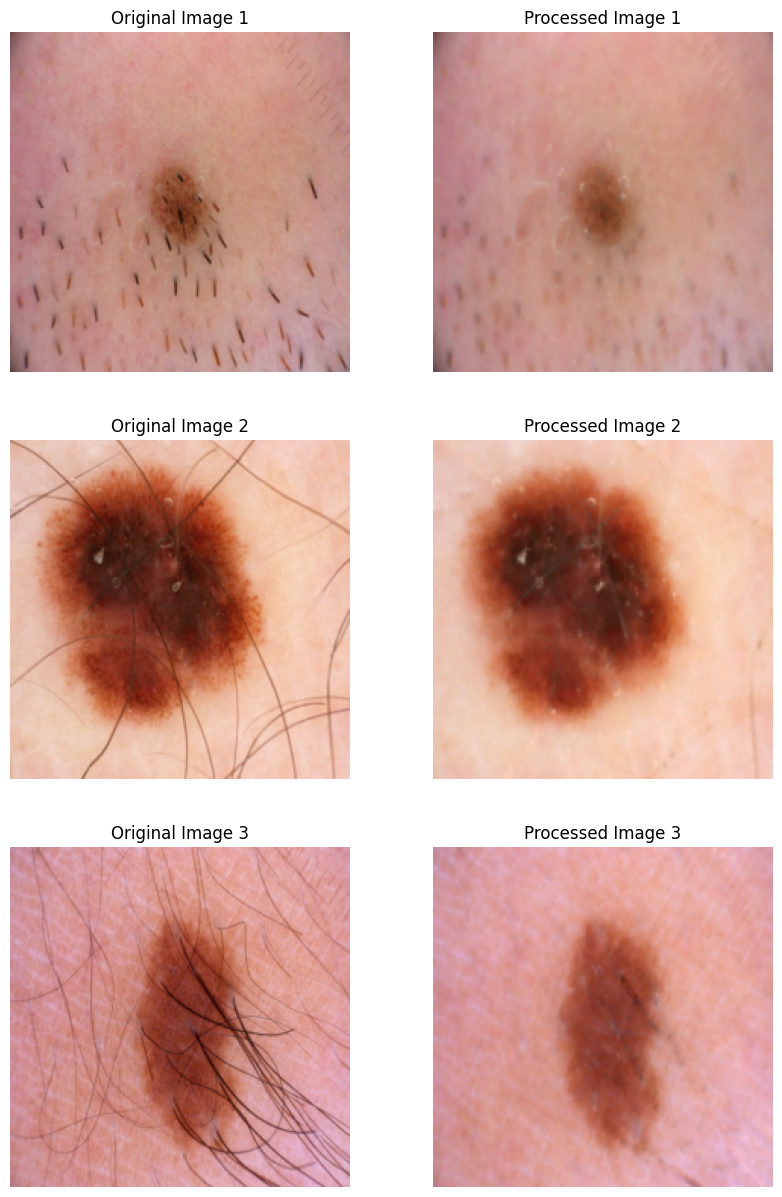

In [ ]:
import pandas as pd
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Ensure matplotlib inline mode
%matplotlib inline

csv_file_path = '/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_Input'
image_files_to_process = ['ISIC_0000102_downsampled', 'ISIC_0000103_downsampled', 'ISIC_0000115_downsampled']  # Replace with the image filenames you want to process, without the extension

# Load the CSV file
data = pd.read_csv(csv_file_path)

# Define a function to remove hair artifacts
def remove_hair(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply thresholding and Otsu's binarization
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Define a smaller kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    # Apply black hat top-hat transform
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    # Inpaint the image with a larger radius
    inpaint = cv2.inpaint(image, blackhat, 3, cv2.INPAINT_TELEA)
    return inpaint

# Define other preprocessing steps
def denoise_image(image):
    # Apply non-local means denoising
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

def color_correction(image):
    # Convert to LAB color space
    result = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(result)
    # Apply CLAHE for luminance correction
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    result = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return result

def illumination_correction(image):
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    # Apply CLAHE for illumination correction
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    result = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return result

def contrast_enhancement(image):
    # Adjust contrast and brightness
    alpha = 1.2  # Contrast adjustment factor
    beta = -10   # Brightness adjustment factor
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def edge_enhancement(image):
    # Define a sharpening kernel
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    return cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Define a function to process a single image
def process_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)

    # Apply preprocessing steps
    preprocessed_image = remove_hair(image_np)
    # preprocessed_image = denoise_image(preprocessed_image)
    # preprocessed_image = color_correction(preprocessed_image)
    # preprocessed_image = illumination_correction(preprocessed_image)
    # preprocessed_image = contrast_enhancement(preprocessed_image)
    # preprocessed_image = edge_enhancement(preprocessed_image)

    # Convert to tensor and normalize
    image_tensor = transform(Image.fromarray(preprocessed_image))

    return image_tensor

# Process multiple images and display the results
fig, axes = plt.subplots(len(image_files_to_process), 2, figsize=(10, 5 * len(image_files_to_process)))

for i, image_file in enumerate(image_files_to_process):
    img_path = os.path.join(image_folder_path, image_file + ".jpg")

    # Process the original image
    original_image = transform(Image.open(img_path).convert('RGB')).permute(1, 2, 0).numpy()
    original_image = original_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]

    # Process the preprocessed image
    processed_image_tensor = process_image(img_path)
    processed_image = processed_image_tensor.permute(1, 2, 0).numpy()
    processed_image = processed_image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]

    # Display the images
    axes[i, 0].imshow(np.clip(original_image, 0, 1))
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(np.clip(processed_image, 0, 1))
    axes[i, 1].set_title(f'Processed Image {i+1}')
    axes[i, 1].axis('off')

plt.show()

By the way, we have also tried other methods to balance the dataset. Initially, we consulted with our tutor and were advised to standardize the number of instances for each category to 1000. However, doing so would have left us with only 8000 samples in total. We followed this approach, but after testing the models, we found that the accuracy was worse. We analyzed that this was due to the total number of samples being much less than in the original dataset.

Therefore, we adopted the following balancing scheme for the data: for categories with more than 5000 instances, we used undersampling to reduce their numbers to 80% of their original count; for categories with fewer than 2000 instances, we performed data augmentation to increase their numbers to exceed 2000. This approach allowed us to achieve a more balanced distribution while preserving a sufficient dataset size for effective model training and evaluation.


## 3.3 Processed Dataset



The following code introduces additional data augmentation techniques to address class imbalance in the training dataset. It begins by importing necessary libraries and reading the CSV file containing image filenames and labels. The data is split into training, validation, and test sets with a 0.6:0.2:0.2 ratio, ensuring stratification based on labels. A custom augmentation transform, RandomRotate180, is defined to randomly rotate images, enhancing the diversity of the training data. Additional augmentations include random horizontal and vertical flips, resized crops, and contrast change.

Class balancing is achieved by resampling the training data, ensuring each class has between 2000 and 5000 samples. Classes with fewer samples are augmented, while those with excess samples are undersampled. The SkinDiseaseDataset class is used to load images and apply both augmentation and common transformations. The resulting datasets are loaded using DataLoader with batch processing to facilitate model training. The code concludes with label count checks for each dataset, verifying the effectiveness of the class balancing process.

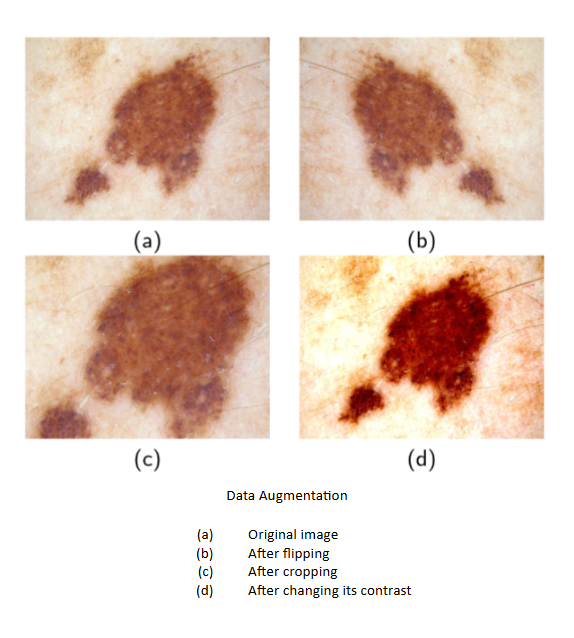

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Modify here
csv_file_path = '/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/Colab/ISIC2019/ISIC_2019_Training_Input'

data = pd.read_csv(csv_file_path)

# Extract image filenames and labels
data['label'] = data.drop(['image', 'UNK'], axis=1).idxmax(axis=1)
image_files = data['image'].values
labels = data['label'].values

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Split the training set into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data['label'])

# Set minimum and maximum sample sizes
min_samples = 2000
max_samples = 5000

balanced_train_data = pd.DataFrame()

class RandomRotate180:
    def __call__(self, img):
        if random.random() > 0.5:
            return img.rotate(180)
        return img

# Augmentation transforms for training data
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    RandomRotate180(),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ColorJitter(contrast=(0.5, 1.5))
])

# Common transforms for all data
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for label in train_data['label'].unique():
    label_data = train_data[train_data['label'] == label]
    count = len(label_data)

    if count < min_samples:
        n_samples = min(max_samples, max(min_samples, count * 2))
        n_augment = n_samples - count

        augmented_data = []
        for _, row in label_data.iterrows():
            img_name = os.path.join(image_folder_path, row['image'] + ".jpg")
            image = Image.open(img_name).convert('RGB')
            augmented_data.append([row['image'], label])

        for i in range(n_augment):
            img_name = os.path.join(image_folder_path, label_data.iloc[i % count]['image'] + ".jpg")
            image = Image.open(img_name).convert('RGB')
            augmented_image = augmentation_transforms(image)
            augmented_image_name = f"{label_data.iloc[i % count]['image']}_augmented_{i}"
            augmented_image_path = os.path.join(image_folder_path, augmented_image_name + ".jpg")

            # Save the augmented image only if it doesn't already exist
            if not os.path.exists(augmented_image_path):
                augmented_image.save(augmented_image_path)

            augmented_data.append([augmented_image_name, label])

        augmented_df = pd.DataFrame(augmented_data, columns=['image', 'label'])
        label_data = pd.concat([label_data, augmented_df])

    elif count > max_samples:
        n_samples = max(min_samples, int(count * 0.8))
        label_data = resample(label_data, replace=False, n_samples=n_samples, random_state=42)

    balanced_train_data = pd.concat([balanced_train_data, label_data])

# Separate the image filenames and labels of the training set
train_images = balanced_train_data['image'].values
train_labels = pd.get_dummies(balanced_train_data['label']).values

# Separate the image filenames and labels of the validation set
val_images = val_data['image'].values
val_labels = pd.get_dummies(val_data['label']).values

# Separate the image filenames and labels of the test set
test_images = test_data['image'].values
test_labels = pd.get_dummies(test_data['label']).values

# Define the dataset class
class SkinDiseaseDataset(Dataset):
    def __init__(self, image_files, labels, image_dir, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx] + ".jpg")
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Image transformation for training data
train_transform = transforms.Compose([
    augmentation_transforms,
    common_transforms
])

# Create training, validation, and test datasets
train_dataset = SkinDiseaseDataset(train_images, train_labels, image_dir=image_folder_path, transform=train_transform)
val_dataset = SkinDiseaseDataset(val_images, val_labels, image_dir=image_folder_path, transform=common_transforms)
test_dataset = SkinDiseaseDataset(test_images, test_labels, image_dir=image_folder_path, transform=common_transforms)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Check if balanced
train_counts = balanced_train_data['label'].value_counts()
val_counts = val_data['label'].value_counts()
test_counts = test_data['label'].value_counts()

print("Training set label counts:")
print(train_counts)
print("\nValidation set label counts:")
print(val_counts)
print("\nTest set label counts:")
print(test_counts)


Training set label counts:
label
NV      6180
BCC     5982
BKL     4722
MEL     2714
AK      2520
SCC     2376
VASC    2152
DF      2143
Name: count, dtype: int64

Validation set label counts:
label
NV      2575
MEL      904
BCC      664
BKL      525
AK       174
SCC      126
VASC      50
DF        48
Name: count, dtype: int64

Test set label counts:
label
NV      2575
MEL      904
BCC      665
BKL      525
AK       173
SCC      126
VASC      51
DF        48
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Up to this point, we have obtained the original dataset that has been split and undergone simple preprocessing (resizing images to 224x224 pixels, converting images to tensor format, and normalization). Additionally, based on the original dataset, we have created a processed dataset that has been balanced for the training set (through undersampling and data augmentation). Next, we will use these two datasets for model training and compare the results.


# 4 Models and Methods

4 models have been used to extract features, including VGG16, ResNet50, ResNet101, DenseNet201. And fully connected layer and Cubic SVM have been used for classification methods. Therefor total 8 training models will be discussed below for both origianl data set and processed data set.

To compare the perfermance of each combination, the f1, Accuracy, Average AUC and AUC for each class has been calcualted for the test dataset, refer the section 5 results for details.  

**F1 Score**

The F1 score is the harmonic average of accuracy and recall. Because we do a multi-label classification task, we want to make sure that our model not only correctly identifies relevant instances, but also finds most of them. The F1 Score provides a balance between the two, helping to evaluate the model's performance in correctly identifying each label.

**Accuracy**

Accuracy measures the proportion of correctly predicted labels among all predictions. It can provide a direct measure of overall correctness. For the multi-label problem, it takes into account the exact match rate, that is, the entire set of predicted labels must match the real label, which is more stringent than the traditional precision metric.

**AUROC**

AUROC assesses the model's ability to distinguish categories by plotting true and false positive rates at different threshold Settings.
A high AUROC value indicates that the model has a good measure of separability, meaning that it can effectively distinguish between positive and negative classes.

## 4.1 Model - Feature Extraction (VGG16)

### 4.1.1 VGG16 Overview

**Network Overview**<br>
Architecture: VGG-16 is a deep convolutional neural network with 13 convolutional layers, 5 max-pooling layers, and 3 fully connected layers.

Convolutional Layers: Extract hierarchical features from images.

Fully Connected Layers: Perform classification based on extracted features.

Softmax Activation: Outputs probabilities for each class.


**How It Works for Skin Lesion Classification**<br>
Input Preprocessing: Dermoscopic images are resized to 224x224 pixels and normalized.

Feature Extraction: The convolutional layers of pre-trained VGG-16 extract relevant features from the images.

Transfer Learning: Custom Classification layers are added for specific skin lesion classification.

Training: The model is trained on labeled dermoscopic images to classify different skin lesions.

Classification: The trained model predicts the type of skin lesion based on the learned features.

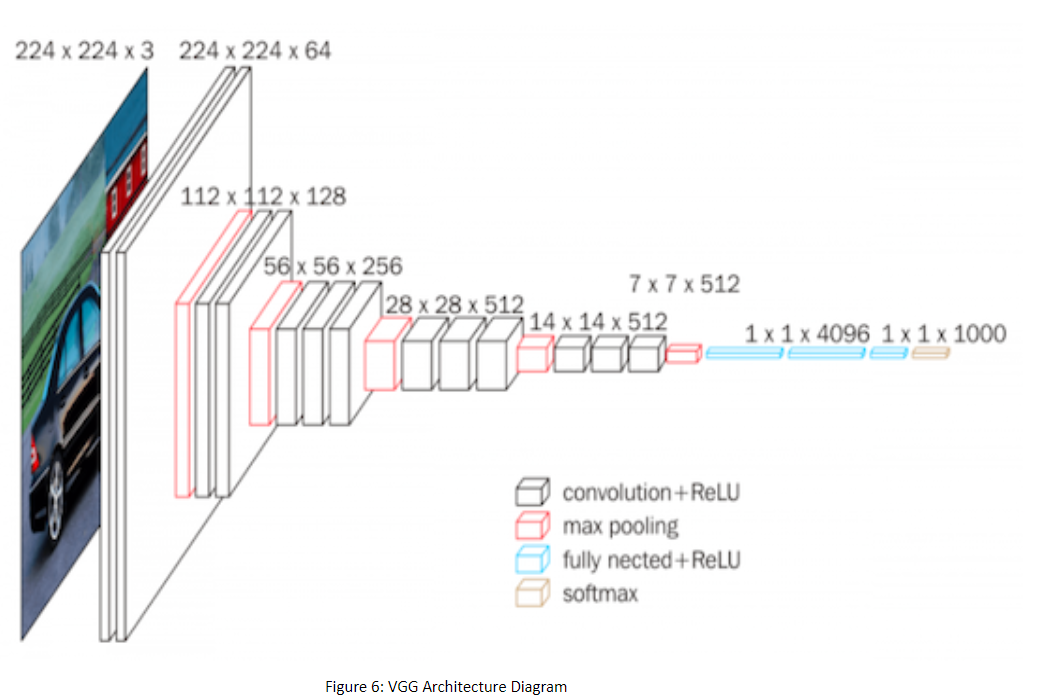

VGG Architecture Diagram\[2\]

###4.1.2 Original Data - VGG With Fully Connected Layer

Train batch shape: (48, 224, 224, 3), (48,)
Test batch shape: (48, 224, 224, 3), (48,)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,927,112 (68.39 MB)

 Trainable params: 3,212,424 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
423/423 ━━━━━━━━━━━━━━━━━━━━ 76s 174ms/step - accuracy: 0.5752 - loss: 1.3594 - val_accuracy: 0.6566 - val_loss: 0.9602
Epoch 2/30
423/423 ━━━━━━━━━━━━━━━━━━━━ 71s 167ms/step - accuracy: 0.7002 - loss: 0.8308 - val_accuracy: 0.6746 - val_loss: 0.9193
Epoch 3/30
423/423 ━━━━━━━━━━━━━━━━━━━━ 71s 168ms/step - accuracy: 0.7589 - loss: 0.6672 - val_accuracy: 0.6752 - val_loss: 0.9085
Epoch 4/30
423/423 ━━━━━━━━━━━━━━━━━━━━ 71s 168ms/step - accuracy: 0.8046 - loss: 0.5499 - val_accuracy: 0.6789 - val_loss: 0.9305
Epoch 5/30
423/423 ━━━━━━━━━━━━━━━━━━━━ 71s 168ms/step - accuracy: 0.8423 - loss: 0.4529 - val_accuracy: 0.6799 - val_loss: 0.9884
Epoch 6/30
423/423 ━━━━━━━━━━━━━━━━━━━━ 71s 168ms/step - accuracy: 0.8689 - loss: 0.3905 - val_accuracy: 0.6787 - val_loss: 1.0398
Epoch 7/30
423/423 ━━━━━━━━━━━━━━━━━━━━ 71s 168ms/step - accuracy: 0.8694 - loss: 0.3726 - val_accuracy: 0.6625 - val_loss: 1.1753
Epoch 8/30
423/423 ━━━━━━━━━━━━━━━━━━━━ 71s 167ms/step - accuracy: 0.8535 - loss: 0

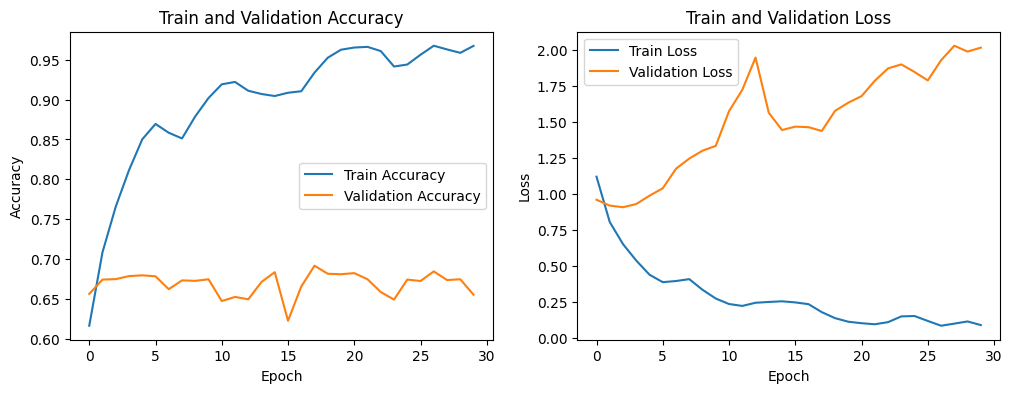

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# file path
csv_file_path = '/content/drive/MyDrive/9444 project_VGG/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/9444 project_VGG/ISIC_2019_Training_Input'

def load_data(image_folder_path, csv_file_path):
    # read CSV
    df = pd.read_csv(csv_file_path)
    df = df.drop(columns=['UNK'])  # remove the empty lable.

    # Get image path and labels.
    image_paths = [os.path.join(image_folder_path, f"{image_id}.jpg") for image_id in df['image']]
    labels = df.drop(columns=['image']).values


    labels = np.argmax(labels, axis=1)

    return image_paths, labels

def preprocess_image(image_path):
    try:
        #load image
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image) / 255.0
        # Preprocessing by using VGG16
        image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        return image.astype(np.float32)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return np.zeros((224, 224, 3), dtype=np.float32)

def create_dataset(image_paths, labels, batch_size=32):
    def load_and_preprocess(image_path, label):
        image = tf.numpy_function(preprocess_image, [image_path], tf.float32)
        image.set_shape((224, 224, 3))
        return image, label

    image_paths_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((image_paths_ds, labels_ds))

    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Load Data
image_paths, labels = load_data(image_folder_path, csv_file_path)

# check the number of labels.
num_classes = np.max(labels) + 1
assert num_classes == 8, f"Expected 8 classes, but got {num_classes}"

# Divide train and test set
image_paths_train, image_paths_test, labels_train, labels_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42)

# create train and test dataset
train_dataset = create_dataset(image_paths_train, labels_train, batch_size=48)
test_dataset = create_dataset(image_paths_test, labels_test, batch_size=48)


for images, labels in train_dataset.take(1):
    print(f"Train batch shape: {images.shape}, {labels.shape}")

for images, labels in test_dataset.take(1):
    print(f"Test batch shape: {images.shape}, {labels.shape}")

# Load V116 model without fully connected layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Frezze VGG16 convolutional layer
base_model.trainable = False

# Add customise layer
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# genereate model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.summary()

# Training Model
with tf.device('/GPU:0'):
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=30)

# Validate model
loss, accuracy = model.evaluate(test_dataset)
print(f'Validation accuracy: {accuracy*100:.2f}%')

y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=1)
y_pred_proba = model.predict(test_dataset)

# Count Accuracy
accuracy_per_class = []
for i in range(num_classes):
    true_class = y_true == i
    pred_class = y_pred == i
    accuracy_class = accuracy_score(true_class, pred_class)
    accuracy_per_class.append(accuracy_class)

# Count F1
f1_per_class = f1_score(y_true, y_pred, average=None)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Count AUC
label_binarizer = LabelBinarizer()
y_true_one_hot = label_binarizer.fit_transform(y_true)
auc_per_class = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr', average=None)
auc_weighted = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr', average='weighted')

# Print accuracy, f1, AUC for each class
results_matrix = pd.DataFrame({
    "Class": [f"Class {i}" for i in range(num_classes)],
    "Accuracy": accuracy_per_class,
    "F1 Score": f1_per_class,
    "AUC Score": auc_per_class
})

print("\nPerformance per class:")
print(results_matrix)

print(f"\nOverall Validation Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1_weighted}")
print(f"Weighted AUC Score: {auc_weighted}")

# Plot accuracy value for train and validataion data
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

# Plot loss value for train and validation data
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.show()


###4.1.3 Original Data - VGG With Cubic SVM

Num GPUs Available:  1
Validation accuracy: 66.53%
F1 Score per class: [0.51539912 0.80865336 0.55322339 0.27755102 0.32669323 0.15384615
 0.26666667 0.16528926]
Weighted F1 Score: 0.6269521407799056
AUC Score per class: [0.84258347 0.89580787 0.91628963 0.8989544  0.82966471 0.86356014
 0.87963327 0.89781305]
Weighted AUC Score: 0.8780383166258408

Performance per class:
     Class  Accuracy  F1 Score  AUC Score
0  Class 0  0.847839  0.515399   0.842583
1  Class 1  0.774817  0.808653   0.895808
2  Class 2  0.882376  0.553223   0.916290
3  Class 3  0.965068  0.277551   0.898954
4  Class 4  0.899941  0.326693   0.829665
5  Class 5  0.991316  0.153846   0.863560
6  Class 6  0.989145  0.266667   0.879633
7  Class 7  0.980067  0.165289   0.897813


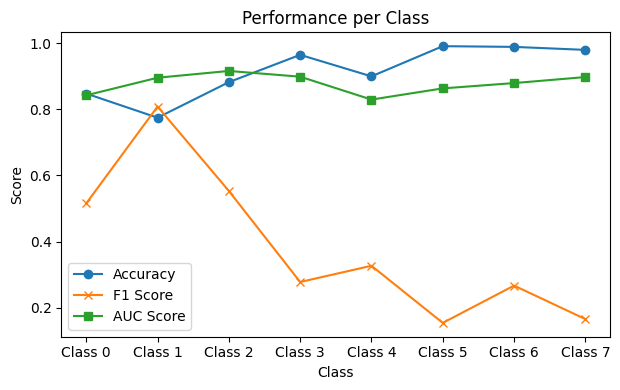

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from collections import Counter

# Disable detailed logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# File paths
csv_file_path = '/content/drive/MyDrive/9444 project_VGG/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/9444 project_VGG/ISIC_2019_Training_Input'

def load_data(image_folder_path, csv_file_path):
    # Read CSV file
    df = pd.read_csv(csv_file_path)
    df = df.drop(columns=['UNK'])  # Assuming UNK is a column you don't need

    # Get image file paths and labels
    image_paths = [os.path.join(image_folder_path, f"{image_id}.jpg") for image_id in df['image']]
    labels = df.drop(columns=['image']).values

    # Convert one-hot encoding to integer labels
    labels = np.argmax(labels, axis=1)

    return image_paths, labels

def preprocess_image(image_path):
    try:
        # Load image
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image) / 255.0
        image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        return image.astype(np.float32)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def extract_features(image_paths, model):
    features = []
    valid_paths = []

    for start in range(0, len(image_paths), 32):
        end = min(start + 32, len(image_paths))
        batch_paths = image_paths[start:end]

        batch_images = [preprocess_image(path) for path in batch_paths]
        batch_images = [img for img in batch_images if img is not None]
        batch_paths = [path for img, path in zip(batch_images, batch_paths) if img is not None]

        if batch_images:
            batch_images = np.array(batch_images)
            batch_features = model.predict(batch_images, verbose=0)
            batch_features_flatten = batch_features.reshape(batch_features.shape[0], -1)  # Flatten features
            features.append(batch_features_flatten)
            valid_paths.extend(batch_paths)

    return np.vstack(features), valid_paths

# Load data
image_paths, labels = load_data(image_folder_path, csv_file_path)

# Split training and testing sets
image_paths_train, image_paths_test, labels_train, labels_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42)

# Sample a subset of the training set
subset_size_per_class = 10000  # Number of samples per class
unique_classes = np.unique(labels_train)

image_paths_train_subset = []
labels_train_subset = []

for class_label in unique_classes:
    class_indices = np.where(labels_train == class_label)[0]
    # Ensure we do not sample more than available
    actual_sample_size = min(subset_size_per_class, len(class_indices))
    subset_indices = np.random.choice(class_indices, size=actual_sample_size, replace=False)
    image_paths_train_subset.extend(np.array(image_paths_train)[subset_indices])
    labels_train_subset.extend(np.array(labels_train)[subset_indices])

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Load pre-trained VGG16 model without the top fully connected layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features
train_features, valid_train_paths = extract_features(image_paths_train_subset, base_model)
test_features, valid_test_paths = extract_features(image_paths_test, base_model)

# Ensure the labels match the number of features
valid_labels_train = [label for path, label in zip(image_paths_train_subset, labels_train_subset) if path in valid_train_paths]
valid_labels_test = [label for path, label in zip(image_paths_test, labels_test) if path in valid_test_paths]

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

# Train SVM with the subset
svm_classifier = SVC(kernel='poly', degree=3, probability=True, cache_size=500)
svm_classifier.fit(train_features_pca, valid_labels_train)

# Make predictions
predictions = svm_classifier.predict(test_features_pca)
y_pred_proba = svm_classifier.predict_proba(test_features_pca)

# Calculate overall accuracy
accuracy = accuracy_score(valid_labels_test, predictions)
print(f'Validation accuracy: {accuracy*100:.2f}%')

# Calculate accuracy per class
accuracy_per_class = []
for i in range(8):
    true_class = np.array(valid_labels_test) == i
    pred_class = predictions == i
    accuracy_class = accuracy_score(true_class, pred_class)
    accuracy_per_class.append(accuracy_class)

# Compute F1 scores per class and overall weighted F1 score
f1_scores = f1_score(valid_labels_test, predictions, average=None)
f1_weighted = f1_score(valid_labels_test, predictions, average='weighted')
print(f'F1 Score per class: {f1_scores}')
print(f'Weighted F1 Score: {f1_weighted}')

# Compute AUC scores per class and overall AUC score
y_true_one_hot = pd.get_dummies(valid_labels_test).values

# Ensure number of classes match between y_true and y_pred
num_classes = y_true_one_hot.shape[1]
if y_pred_proba.shape[1] != num_classes:
    raise ValueError("Mismatch in number of classes between y_true and y_pred_proba")

auc_scores = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr', average=None)
auc_weighted = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr')
print(f'AUC Score per class: {auc_scores}')
print(f'Weighted AUC Score: {auc_weighted}')

# Store accuracy, F1 scores, and AUC scores in a matrix
results_matrix = pd.DataFrame({
    "Class": [f"Class {i}" for i in range(num_classes)],
    "Accuracy": accuracy_per_class,
    "F1 Score": f1_scores,
    "AUC Score": auc_scores
})

print("\nPerformance per class:")
print(results_matrix)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(results_matrix["Class"], results_matrix["Accuracy"], label='Accuracy', marker='o')
plt.plot(results_matrix["Class"], results_matrix["F1 Score"], label='F1 Score', marker='x')
plt.plot(results_matrix["Class"], results_matrix["AUC Score"], label='AUC Score', marker='s')
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Performance per Class')
plt.legend()

plt.tight_layout()
plt.show()


### 4.1.4 Processed Data - VGG With Fully Connected Layer

Original class distribution: Counter({5: 10300, 4: 3618, 1: 2658, 2: 2099, 0: 694, 6: 502, 7: 202, 3: 191})
Balanced class distribution: Counter({5: 8240, 4: 3618, 1: 2658, 2: 2099, 6: 2000, 0: 2000, 3: 2000, 7: 2000})
Original training set distribution:
5    10300
4     3618
1     2658
2     2099
0      694
6      502
7      202
3      191
Name: count, dtype: int64

Balanced training set distribution:
5    8240
4    3618
1    2658
2    2099
6    2000
0    2000
3    2000
7    2000
Name: count, dtype: int64

Test set distribution:
5    2575
4     904
1     665
2     525
0     173
6     126
7      51
3      48
Name: count, dtype: int64
Epoch 1/30
769/769 ━━━━━━━━━━━━━━━━━━━━ 141s 98ms/step - accuracy: 0.3978 - loss: 2.6893 - val_accuracy: 0.5651 - val_loss: 1.2726 - learning_rate: 0.0010
Epoch 2/30
769/769 ━━━━━━━━━━━━━━━━━━━━ 139s 97ms/step - accuracy: 0.5179 - loss: 1.2806 - val_accuracy: 0.6127 - val_loss: 1.1017 - learning_rate: 0.0010
Epoch 3/30
769/769 ━━━━━━━━━━━━━━━━━━━━ 139s 97m

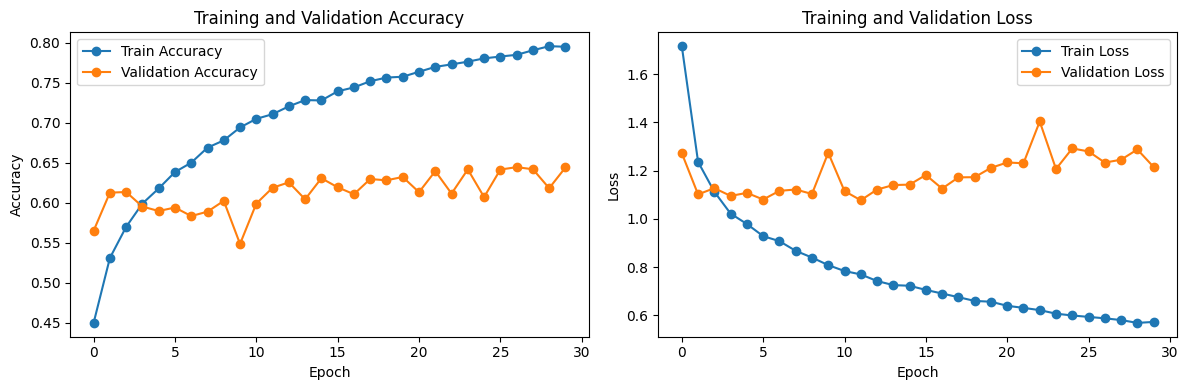

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

csv_file_path = '/content/drive/MyDrive/9444 project_VGG/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/9444 project_VGG/ISIC_2019_Training_Input'

data = pd.read_csv(csv_file_path)
image_files = data['image'].values
labels = data.drop(['image', 'UNK'], axis=1)


label_names = labels.idxmax(axis=1).astype(str)


label_encoder = LabelEncoder()
label_names_encoded = label_encoder.fit_transform(label_names)


X_train, X_test, y_train, y_test = train_test_split(
    image_files, label_names_encoded, test_size=0.2, random_state=42, stratify=label_names_encoded)


subset_size = 10000
subset_indices = np.random.choice(len(X_train), size=subset_size, replace=False)
X_train_subset = X_train[subset_indices]
y_train_subset = y_train[subset_indices]


class_counts = Counter(y_train_subset)
print("Original class distribution:", class_counts)


min_samples = 2000
max_samples = 5000


def augment_image(image):

    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.int32) * 2)


    scale = tf.random.uniform(shape=[], minval=0.8, maxval=1.2)
    new_height = tf.cast(224 * scale, tf.int32)
    new_width = tf.cast(224 * scale, tf.int32)
    image = tf.image.resize(image, [new_height, new_width])
    image = tf.image.resize_with_crop_or_pad(image, 224, 224)


    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image


def load_and_preprocess_image(file_path):
    try:
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [224, 224])
        image = tf.keras.applications.vgg16.preprocess_input(image)
        return image
    except tf.errors.InvalidArgumentError as e:
        print(f"Cannot read image {file_path}: {e}")
        return None


X_resampled = []
y_resampled = []

for label, count in class_counts.items():
    X_class = X_train_subset[y_train_subset == label]

    if count < min_samples:
        n_samples = min(max_samples, max(min_samples, count * 2))
        n_augment = n_samples - count

        for file in X_class:
            X_resampled.append(file)
            y_resampled.append(label)

        for _ in range(n_augment):
            file = np.random.choice(X_class)
            X_resampled.append(file)
            y_resampled.append(label)

    elif count > max_samples:
        n_samples = max(min_samples, int(count * 0.8))
        sampled_files = np.random.choice(X_class, n_samples, replace=False)
        X_resampled.extend(sampled_files)
        y_resampled.extend([label] * n_samples)

    else:
        X_resampled.extend(X_class)
        y_resampled.extend([label] * count)

X_train_balanced = np.array(X_resampled)
y_train_balanced = np.array(y_resampled)

print("Balanced class distribution:", Counter(y_train_balanced))

def create_dataset(image_files, labels, image_dir, batch_size=32, is_training=True):
    def process_path(file_path, label):
        image = load_and_preprocess_image(file_path)
        if image is None:
            return None, -1
        if is_training:
            image = augment_image(image)
        return image, label

    image_paths = [os.path.join(image_dir, file + ".jpg") for file in image_files]

    valid_data = [(image_path, label) for image_path, label in zip(image_paths, labels) if load_and_preprocess_image(image_path) is not None]
    valid_image_paths, valid_labels = zip(*valid_data)

    dataset = tf.data.Dataset.from_tensor_slices((list(valid_image_paths), list(valid_labels)))
    dataset = dataset.map(lambda x, y: process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(buffer_size=len(valid_image_paths))

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

BATCH_SIZE = 32

train_dataset = create_dataset(X_train_balanced, y_train_balanced, image_folder_path, batch_size=BATCH_SIZE, is_training=True)
test_dataset = create_dataset(X_test, y_test, image_folder_path, batch_size=BATCH_SIZE, is_training=False)

print("Original training set distribution:")
print(pd.Series(y_train).value_counts())
print("\nBalanced training set distribution:")
print(pd.Series(y_train_balanced).value_counts())
print("\nTest set distribution:")
print(pd.Series(y_test).value_counts())

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

with tf.device('/GPU:0'):
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=30, callbacks=[reduce_lr])

loss, accuracy = model.evaluate(test_dataset)
print(f'Overall Validation Accuracy: {accuracy*100:.2f}%')

y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=1)
y_pred_proba = model.predict(test_dataset)

accuracy_per_class = []
for i in range(8):
    true_class = (y_true == i)
    pred_class = (y_pred == i)
    accuracy_per_class.append(accuracy_score(true_class, pred_class))

f1_scores = f1_score(y_true, y_pred, average=None)
f1_weighted = f1_score(y_true, y_pred, average='weighted')

y_true_one_hot = pd.get_dummies(y_true).values
auc_scores = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr', average=None)
auc_weighted = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr')

results_matrix = pd.DataFrame({
    "Class": [f"Class {i}" for i in range(8)],
    "Accuracy": accuracy_per_class,
    "F1 Score": f1_scores,
    "AUC Score": auc_scores
})

print("\nPerformance per class:")
print(results_matrix)

print(f"\nOverall Validation Accuracy: {accuracy}")
print(f"Weighted F1 Score: {f1_weighted}")
print(f"Weighted AUC Score: {auc_weighted}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


###4.1.5 Processed Data - VGG With SVM

Num GPUs Available:  1
Validation accuracy: 66.79%
F1 Score per class: [0.53524641 0.81458548 0.55714286 0.34188034 0.30939227 0.26229508
 0.48888889 0.29437229]
Weighted F1 Score: 0.640863325806587
AUC Score per class: [0.84413332 0.89852061 0.90617664 0.8987603  0.80378866 0.88931643
 0.88490864 0.91891923]
Weighted AUC Score: 0.8805654787169648

Performance per class:
     Class  Accuracy  F1 Score  AUC Score
0  Class 0  0.852970  0.535246   0.844133
1  Class 1  0.787251  0.814585   0.898521
2  Class 2  0.889876  0.557143   0.906177
3  Class 3  0.954411  0.341880   0.898760
4  Class 4  0.901322  0.309392   0.803789
5  Class 5  0.991119  0.262295   0.889316
6  Class 6  0.990922  0.488889   0.884909
7  Class 7  0.967831  0.294372   0.918919


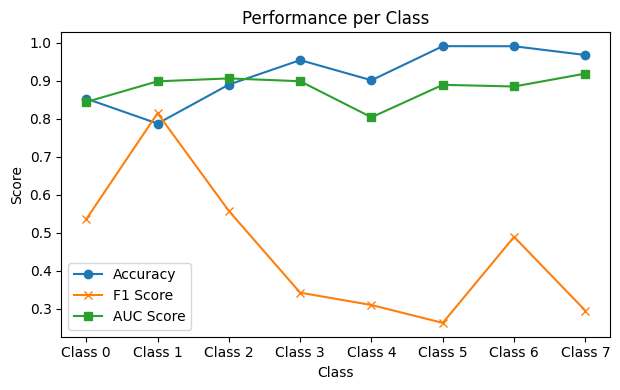

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from collections import Counter

# Disable detailed logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# File paths
csv_file_path = '/content/drive/MyDrive/9444 project_VGG/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/9444 project_VGG/ISIC_2019_Training_Input'

def load_data(image_folder_path, csv_file_path):
    # Read CSV file
    df = pd.read_csv(csv_file_path)
    df = df.drop(columns=['UNK'])  # Assuming UNK is a column you don't need

    # Get image file paths and labels
    image_paths = [os.path.join(image_folder_path, f"{image_id}.jpg") for image_id in df['image']]
    labels = df.drop(columns=['image']).values

    # Convert one-hot encoding to integer labels
    labels = np.argmax(labels, axis=1)

    return image_paths, labels

def preprocess_image(image_path):
    try:
        # Load image
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image) / 255.0
        image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
        return image.astype(np.float32)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def extract_features(image_paths, model):
    features = []
    valid_paths = []

    for start in range(0, len(image_paths), 32):
        end = min(start + 32, len(image_paths))
        batch_paths = image_paths[start:end]

        batch_images = [preprocess_image(path) for path in batch_paths]
        batch_images = [img for img in batch_images if img is not None]
        batch_paths = [path for img, path in zip(batch_images, batch_paths) if img is not None]

        if batch_images:
            batch_images = np.array(batch_images)
            batch_features = model.predict(batch_images, verbose=0)
            batch_features_flatten = batch_features.reshape(batch_features.shape[0], -1)  # Flatten features
            features.append(batch_features_flatten)
            valid_paths.extend(batch_paths)

    return np.vstack(features), valid_paths

def balance_dataset(image_paths, labels, min_samples=2000, max_samples=5000):
    class_counts = Counter(labels)
    X_resampled = []
    y_resampled = []

    for label, count in class_counts.items():
        X_class = np.array(image_paths)[labels == label]

        if count < min_samples:
            # Over-sample minority classes
            n_samples = min(max_samples, max(min_samples, count * 2))
            n_augment = n_samples - count

            for file in X_class:
                X_resampled.append(file)
                y_resampled.append(label)

            for _ in range(n_augment):
                file = np.random.choice(X_class)
                X_resampled.append(file)
                y_resampled.append(label)

        elif count > max_samples:
            # Under-sample majority classes
            n_samples = max(min_samples, int(count * 0.8))  # Reduce by 20% but not below min_samples
            sampled_files = np.random.choice(X_class, n_samples, replace=False)
            X_resampled.extend(sampled_files)
            y_resampled.extend([label] * n_samples)

        else:
            X_resampled.extend(X_class)
            y_resampled.extend([label] * count)

    return np.array(X_resampled), np.array(y_resampled)

# Load data
image_paths, labels = load_data(image_folder_path, csv_file_path)

# Split training and testing sets
image_paths_train, image_paths_test, labels_train, labels_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42)

# Balance the training dataset
image_paths_train_balanced, labels_train_balanced = balance_dataset(image_paths_train, labels_train)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Load pre-trained VGG16 model without the top fully connected layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features
train_features, valid_train_paths = extract_features(image_paths_train_balanced, base_model)
test_features, valid_test_paths = extract_features(image_paths_test, base_model)

# Ensure the labels match the number of features
valid_labels_train = [label for path, label in zip(image_paths_train_balanced, labels_train_balanced) if path in valid_train_paths]
valid_labels_test = [label for path, label in zip(image_paths_test, labels_test) if path in valid_test_paths]

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

# Train SVM with the subset
svm_classifier = SVC(kernel='poly', degree=3, probability=True, cache_size=500)
svm_classifier.fit(train_features_pca, valid_labels_train)

# Make predictions
predictions = svm_classifier.predict(test_features_pca)
y_pred_proba = svm_classifier.predict_proba(test_features_pca)

# Calculate overall accuracy
accuracy = accuracy_score(valid_labels_test, predictions)
print(f'Validation accuracy: {accuracy*100:.2f}%')

# Calculate accuracy per class
accuracy_per_class = []
for i in range(8):
    true_class = np.array(valid_labels_test) == i
    pred_class = predictions == i
    accuracy_class = accuracy_score(true_class, pred_class)
    accuracy_per_class.append(accuracy_class)

# Compute F1 scores per class and overall weighted F1 score
f1_scores = f1_score(valid_labels_test, predictions, average=None)
f1_weighted = f1_score(valid_labels_test, predictions, average='weighted')
print(f'F1 Score per class: {f1_scores}')
print(f'Weighted F1 Score: {f1_weighted}')

# Compute AUC scores per class and overall AUC score
y_true_one_hot = pd.get_dummies(valid_labels_test).values

# Ensure number of classes match between y_true and y_pred
num_classes = y_true_one_hot.shape[1]
if y_pred_proba.shape[1] != num_classes:
    raise ValueError("Mismatch in number of classes between y_true and y_pred_proba")

auc_scores = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr', average=None)
auc_weighted = roc_auc_score(y_true_one_hot, y_pred_proba, multi_class='ovr')
print(f'AUC Score per class: {auc_scores}')
print(f'Weighted AUC Score: {auc_weighted}')

# Store accuracy, F1 scores, and AUC scores in a matrix
results_matrix = pd.DataFrame({
    "Class": [f"Class {i}" for i in range(num_classes)],
    "Accuracy": accuracy_per_class,
    "F1 Score": f1_scores,
    "AUC Score": auc_scores
})

print("\nPerformance per class:")
print(results_matrix)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(results_matrix["Class"], results_matrix["Accuracy"], label='Accuracy', marker='o')
plt.plot(results_matrix["Class"], results_matrix["F1 Score"], label='F1 Score', marker='x')
plt.plot(results_matrix["Class"], results_matrix["AUC Score"], label='AUC Score', marker='s')
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Performance per Class')
plt.legend()

plt.tight_layout()
plt.show()


## 4.2 Model - Feature Extraction (ResNet50)

### 4.2.1 Resnet50 Overview

ResNet50 is an advanced version of CNN based on residual blocks developed by He et al.[3] The main part is using residual blocks to mitigate the gradient degradation problem in the deep networks.
He et al mentioned for 50-layer ResNet, each 2-layer block in the 34-layer net was replaced with 3-layer bottleneck block, resulting in a 50-layer Resnet. [4]
Bottleneck Block is a bottleneck architecture was used with three layers 1 x 1 convolution layer, 3 x 3 convolution layer and another 1 x 1 convolution layer. This can help to increase training speed and reduce computational cost.

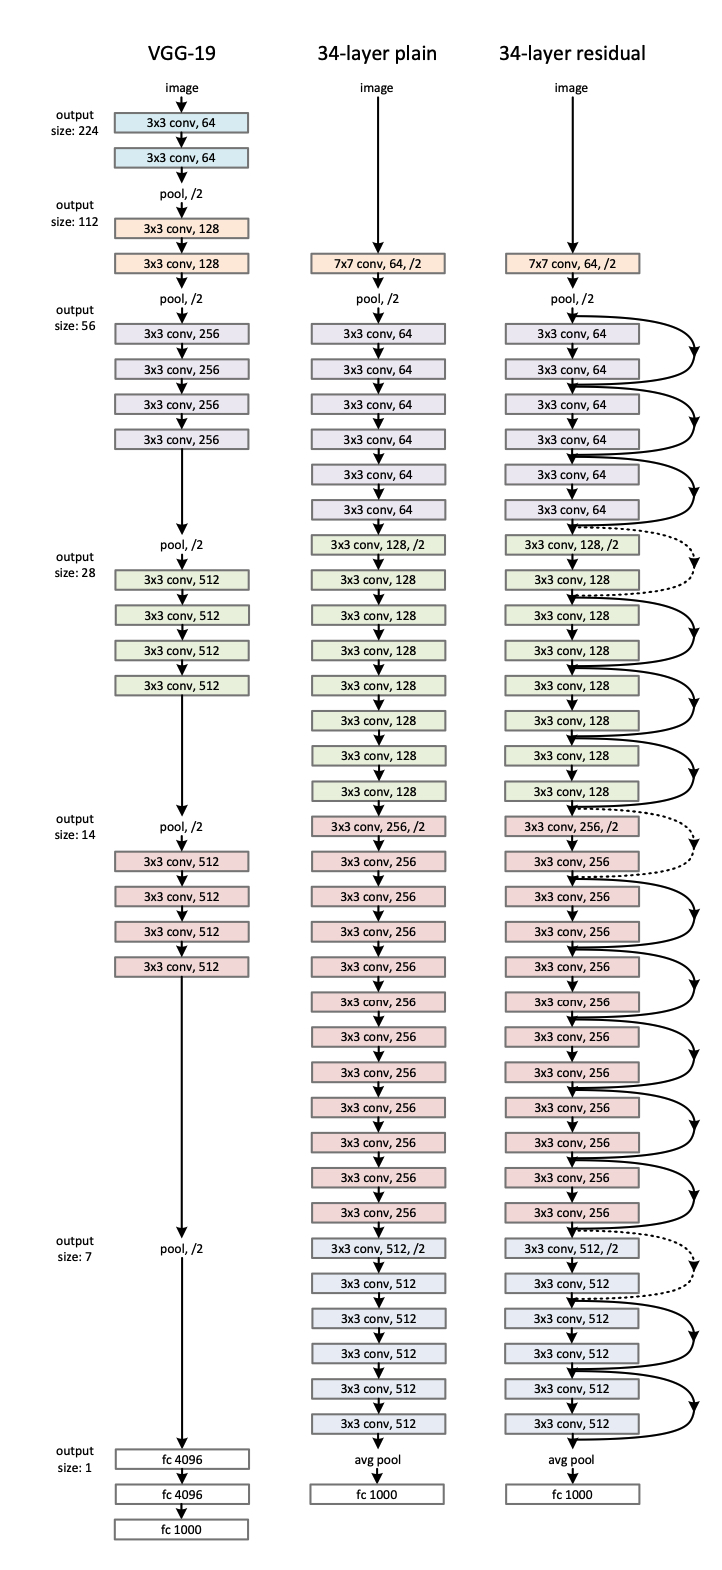

\[5\]

### 4.2.2 Original Data - Resnet50 With Fully Connected Layer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Modify the file paths here

csv_file_path = '/content/drive/MyDrive/9444 Group Work/ISIC2019/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/9444 Group Work/ISIC2019/ISIC_2019_Training_Input'

data = pd.read_csv(csv_file_path)

# Extract image filenames and labels
image_files = data['image'].values
labels = data.drop(['image', 'UNK'], axis=1).values

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2

# Define a custom dataset class
class SkinDiseaseDataset(Dataset):
    def __init__(self, image_files, labels, image_dir, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx] + ".jpg")
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create training, validation, and testing datasets
train_dataset = SkinDiseaseDataset(train_images, train_labels, image_dir = image_folder_path, transform=transform)
val_dataset = SkinDiseaseDataset(val_images, val_labels, image_dir = image_folder_path, transform=transform)
test_dataset = SkinDiseaseDataset(test_images, test_labels, image_dir = image_folder_path, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

15198
5066
5067


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.resnet import ResNet50_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, jaccard_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Load a pretrained ResNet50 model
weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)

# Adjust the number of output classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)  # Set to the number of your classes

# Transfer model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to convert one-hot encoded labels to indices
def convert_one_hot_to_indices(labels):
    if labels.ndim > 1:  # Check if labels are one-hot encoded
        labels = torch.argmax(labels, dim=1)
    return labels

# Function to evaluate the model during training (for validation loss and accuracy)
def evaluate_model(data_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            labels = convert_one_hot_to_indices(labels)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Function to train the model and store the best version based on validation accuracy
def train_model(num_epochs, train_loader, val_loader):
    best_accuracy = 0.0
    best_model_wts = model.state_dict()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = convert_one_hot_to_indices(labels)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_predictions / total_predictions
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_wts = model.state_dict()

    # Save the best model weights
    torch.save(best_model_wts, 'best_model.pth')
    return train_losses, train_accuracies, val_losses, val_accuracies

# Train the model and get the metric histories
num_epochs = 50
train_losses, train_accuracies, val_losses, val_accuracies = train_model(num_epochs, train_loader, val_loader)


Epoch 1/50, Train Loss: 1.0363, Train Accuracy: 63.54%
Epoch 1/50, Val Loss: 1.1493, Val Accuracy: 63.90%
Epoch 2/50, Train Loss: 0.8576, Train Accuracy: 69.11%
Epoch 2/50, Val Loss: 0.8713, Val Accuracy: 68.61%
Epoch 3/50, Train Loss: 0.7671, Train Accuracy: 72.35%
Epoch 3/50, Val Loss: 0.8135, Val Accuracy: 70.92%
Epoch 4/50, Train Loss: 0.6830, Train Accuracy: 75.28%
Epoch 4/50, Val Loss: 0.9029, Val Accuracy: 68.91%
Epoch 5/50, Train Loss: 0.5910, Train Accuracy: 78.06%
Epoch 5/50, Val Loss: 0.8499, Val Accuracy: 70.67%
Epoch 6/50, Train Loss: 0.4989, Train Accuracy: 81.71%
Epoch 6/50, Val Loss: 0.8179, Val Accuracy: 71.46%
Epoch 7/50, Train Loss: 0.3948, Train Accuracy: 85.54%
Epoch 7/50, Val Loss: 0.9412, Val Accuracy: 71.42%
Epoch 8/50, Train Loss: 0.2986, Train Accuracy: 89.44%
Epoch 8/50, Val Loss: 0.9076, Val Accuracy: 71.16%
Epoch 9/50, Train Loss: 0.2246, Train Accuracy: 92.03%
Epoch 9/50, Val Loss: 1.1150, Val Accuracy: 71.14%
Epoch 10/50, Train Loss: 0.1779, Train Accurac

Final Test Results - Loss: 1.9653, Accuracy: 68.27%
Final Test Metrics - F1 Score: 0.6590, AUCs: [0.80498173 0.90567511 0.94658636 0.89045498 0.83532761 0.95033871
 0.95890561 0.89602288], Average AUC: 0.8985


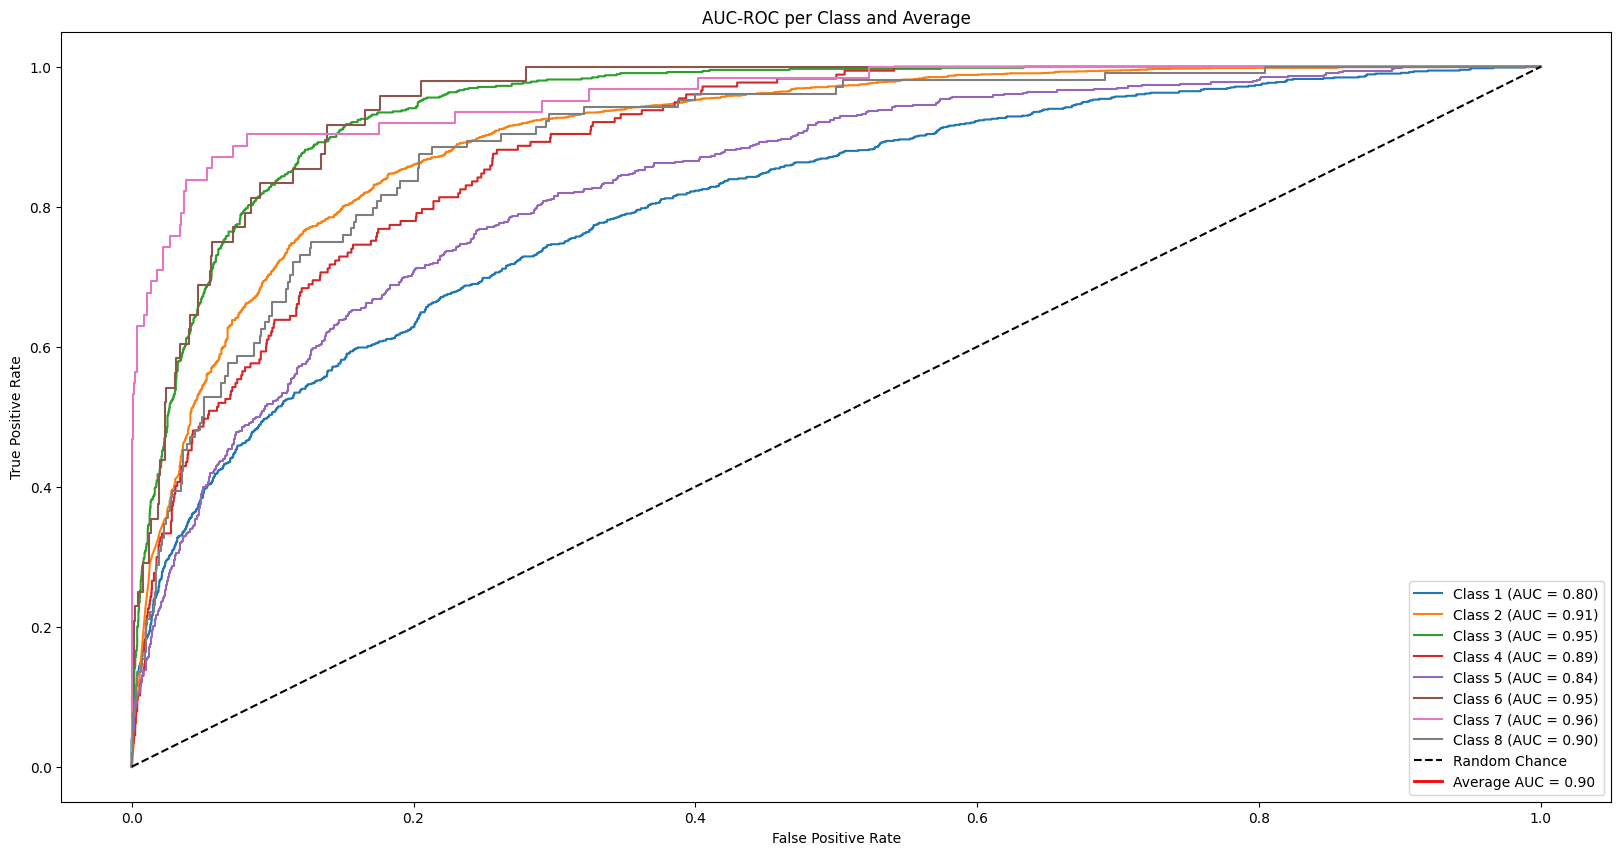

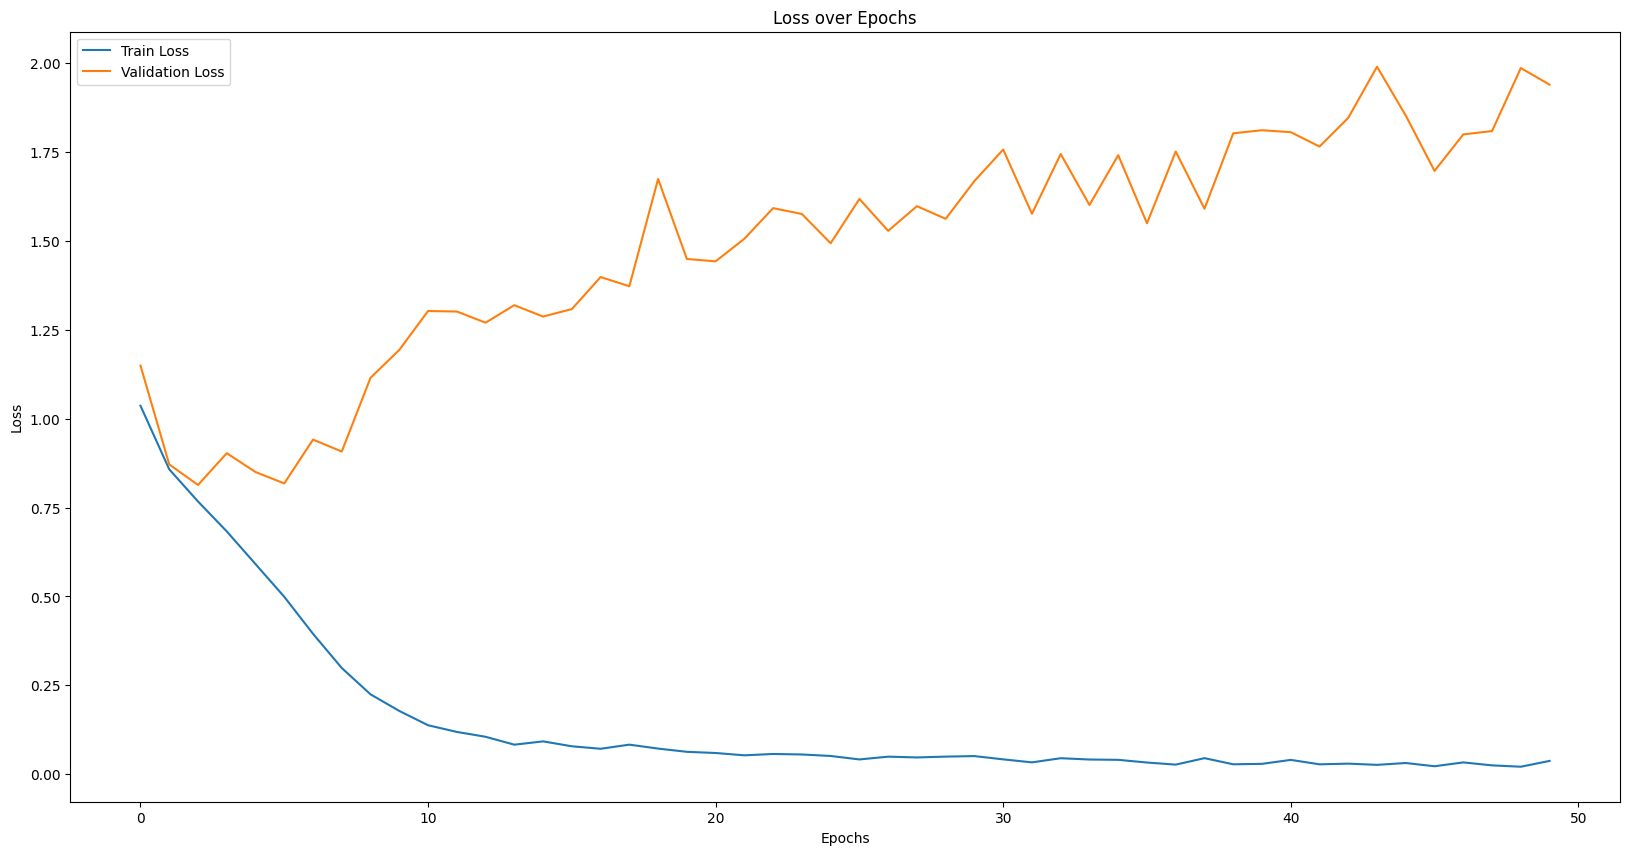

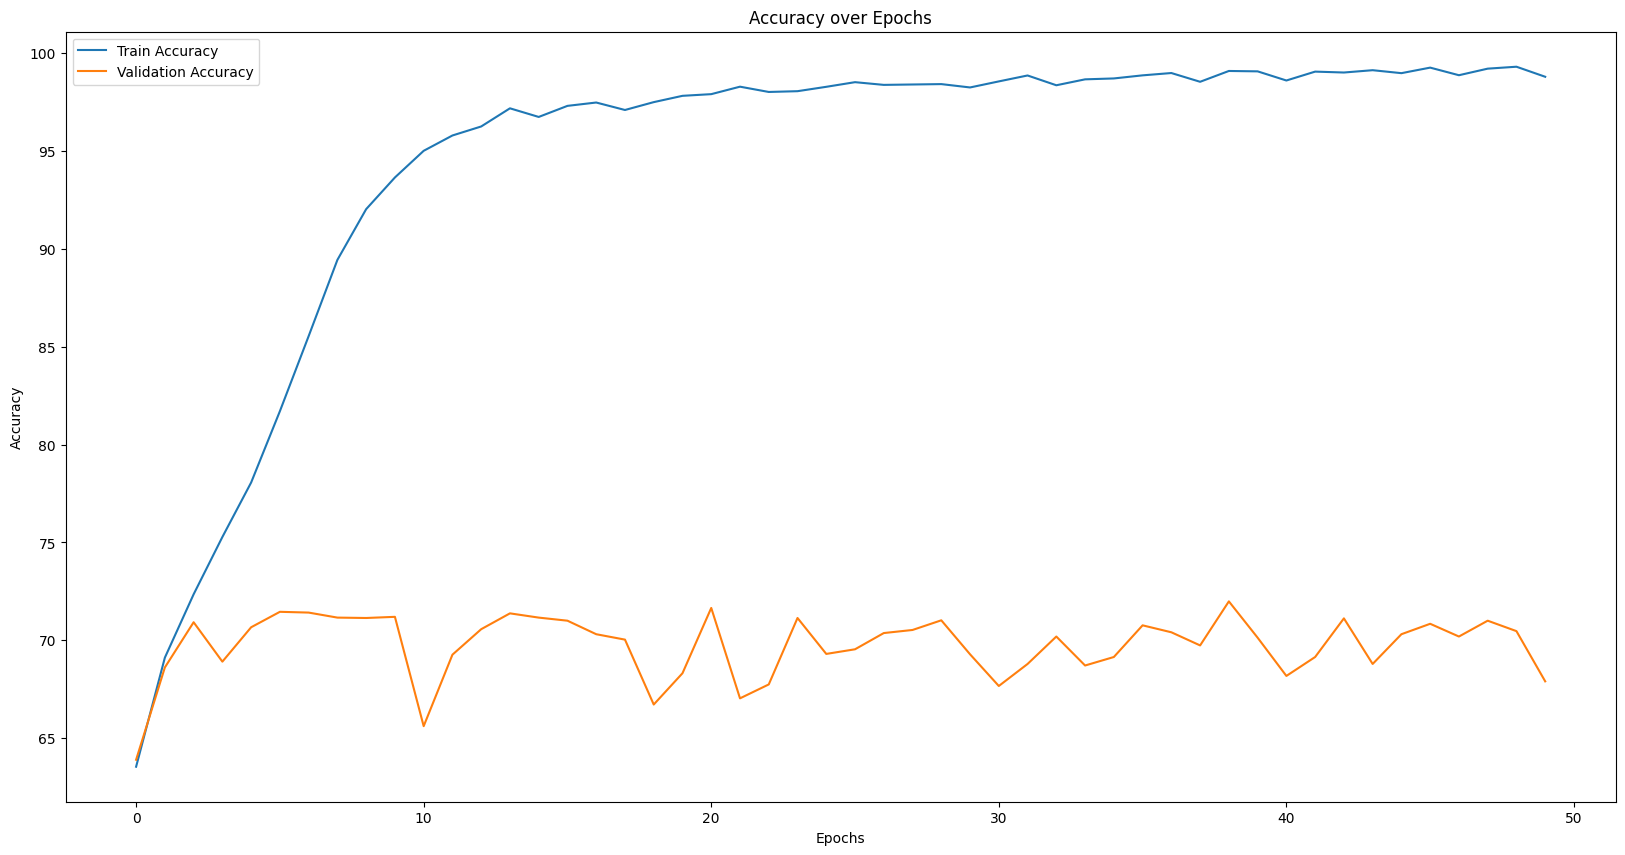

In [ ]:
# Load the best model for final evaluation
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score, roc_curve
model.load_state_dict(torch.load('best_model.pth'))

#all_labels = []
#all_outputs = []

# Final evaluation function for test set
def final_evaluate_model(data_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            labels = convert_one_hot_to_indices(labels)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_outputs.extend(probs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, np.argmax(all_outputs, axis=1), average='weighted')
    # Individual and average AUC-ROC calculations
    aucs = roc_auc_score(all_labels, all_outputs, multi_class='ovr', average=None)
    avg_auc = np.mean(aucs)
    return avg_loss, accuracy, f1, aucs, avg_auc, all_labels, all_outputs

# Execute final evaluation on the test set
test_loss, test_accuracy, test_f1, test_aucs, test_avg_auc, all_labels, all_outputs = final_evaluate_model(test_loader)
print(f'Final Test Results - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')
print(f'Final Test Metrics - F1 Score: {test_f1:.4f}, AUCs: {test_aucs}, Average AUC: {test_avg_auc:.4f}')

# Plot for AUC-ROC
plt.figure(figsize=(20, 10))
for i in range(8):
    fpr, tpr, _ = roc_curve([1 if x == i else 0 for x in all_labels], [x[i] for x in all_outputs])
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {test_aucs[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.plot(np.nan, np.nan, label=f'Average AUC = {test_avg_auc:.2f}', color='red', linewidth=2)  # Placeholder for average AUC
plt.title('AUC-ROC per Class and Average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Plot training and validation loss and accuracy
plt.figure(figsize=(20, 10))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_loss.png')
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_validation_accuracy.png')
plt.show()

### 4.2.3 Original Data - Resnet50 With SVM

Test Accuracy: 0.7197552792579436
Test Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.54      0.60       915
           1       0.77      0.93      0.84      2567
           2       0.58      0.76      0.66       658
           3       0.73      0.11      0.19       177
           4       0.67      0.39      0.49       536
           5       0.75      0.06      0.12        48
           6       0.93      0.23      0.36        62
           7       0.58      0.13      0.22       104

    accuracy                           0.72      5067
   macro avg       0.71      0.39      0.44      5067
weighted avg       0.72      0.72      0.69      5067

AUCs: Class 0: 0.8805, Class 1: 0.9242, Class 2: 0.9433, Class 3: 0.9163, Class 4: 0.8860, Class 5: 0.9225, Class 6: 0.9573, Class 7: 0.9501, Average: 0.9225


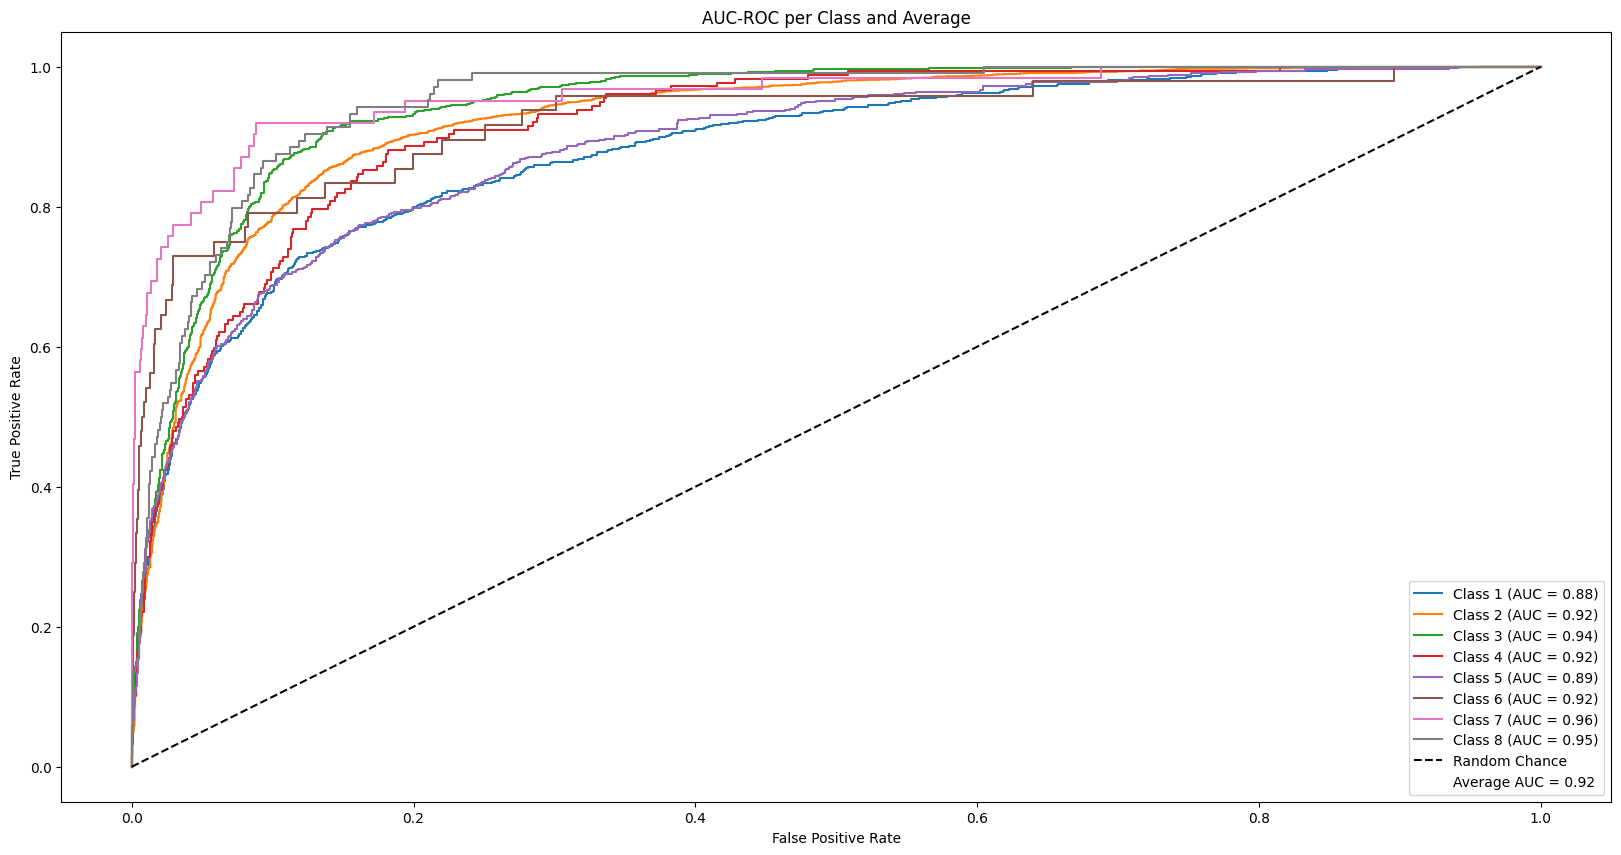

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models.resnet import ResNet50_Weights
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Model setup for feature extraction
weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)
model.fc = nn.Identity()  # Modify to extract features
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Function to convert one-hot encoded labels to indices
def convert_one_hot_to_indices(labels):
    if labels.ndim > 1:  # Check if labels are one-hot encoded
        labels = torch.argmax(labels, dim=1)
    return labels

# Function to extract features
def extract_features(data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, labels_batch in data_loader:
            images = images.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
            labels_batch = convert_one_hot_to_indices(labels_batch)  # Convert labels if necessary
            labels.extend(labels_batch.numpy())
    return features, labels

# Define softmax function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Setup data loaders
# Make sure to fill in DataLoader(...) with actual data loading logic
# Extract features
train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)
test_features, test_labels = extract_features(test_loader)

# Combine training and validation features and labels for training
combined_features = np.concatenate((train_features, val_features))
combined_labels = np.concatenate((train_labels, val_labels))

# Setup and train SVM with fixed parameters
svm_classifier = SVC(kernel='poly', degree=3, C=1.0, gamma='scale', probability=True)
svm_classifier.fit(combined_features, combined_labels)  # Train on combined data

# Evaluate using the trained model on test set
test_predictions = svm_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:")
print(classification_report(test_labels, test_predictions))

# Compute decision scores or probabilities
probabilities = svm_classifier.predict_proba(test_features)

# Compute ROC AUC for each class and average
auc_scores = roc_auc_score(test_labels, probabilities, multi_class='ovr', average=None)
average_auc = roc_auc_score(test_labels, probabilities, multi_class='ovr', average='macro')

# Compute F1 score for each class and average
#f1_scores = f1_score(test_labels, test_predictions, average=None)
average_f1 = f1_score(test_labels, test_predictions, average='weighted')

# Formatted printing of ROC AUC scores and F1 scores
formatted_auc_scores = ", ".join([f"Class {i}: {score:.4f}" for i, score in enumerate(auc_scores)])
#formatted_f1_scores = ", ".join([f"Class {i}: {score:.4f}" for i, score in enumerate(f1_scores)])
print(f"AUCs: {formatted_auc_scores}, Average: {average_auc:.4f}")
#print(f"F1 Scores: {formatted_f1_scores}, Average: {average_f1:.4f}")


# Plot for AUC-ROC
plt.figure(figsize=(20, 10))
for i in range(len(auc_scores)):
    fpr, tpr, _ = roc_curve([1 if x == i else 0 for x in test_labels], [x[i] for x in probabilities])
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc_scores[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.plot([], [], ' ', label=f'Average AUC = {average_auc:.2f}', color='red', linewidth=2)  # Placeholder for average AUC
plt.title('AUC-ROC per Class and Average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


### 4.2.4 Propossed Data - Resnet50 With Fully Connected Layer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Modify here

csv_file_path = '/content/drive/MyDrive/9444 Group Work/ISIC2019/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/9444 Group Work/ISIC2019/ISIC_2019_Training_Input'

data = pd.read_csv(csv_file_path)

# Extract image filenames and labels
data['label'] = data.drop(['image', 'UNK'], axis=1).idxmax(axis=1)
image_files = data['image'].values
labels = data['label'].values

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Split the training set into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data['label'])

# Set minimum and maximum sample sizes
min_samples = 2000
max_samples = 5000

balanced_train_data = pd.DataFrame()

class RandomRotate180:
    def __call__(self, img):
        if random.random() > 0.5:
            return img.rotate(180)
        return img

# Augmentation transforms for training data
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    RandomRotate180(),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ColorJitter(contrast=(0.5, 1.5))
])

# Common transforms for all data
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for label in train_data['label'].unique():
    label_data = train_data[train_data['label'] == label]
    count = len(label_data)

    if count < min_samples:
        n_samples = min(max_samples, max(min_samples, count * 2))
        n_augment = n_samples - count

        augmented_data = []
        for _, row in label_data.iterrows():
            img_name = os.path.join(image_folder_path, row['image'] + ".jpg")
            image = Image.open(img_name).convert('RGB')
            augmented_data.append([row['image'], label])

        for i in range(n_augment):
            img_name = os.path.join(image_folder_path, label_data.iloc[i % count]['image'] + ".jpg")
            image = Image.open(img_name).convert('RGB')
            augmented_image = augmentation_transforms(image)
            augmented_image_name = f"{label_data.iloc[i % count]['image']}_augmented_{i}"
            augmented_image_path = os.path.join(image_folder_path, augmented_image_name + ".jpg")

            # Save the augmented image only if it doesn't already exist
            if not os.path.exists(augmented_image_path):
                augmented_image.save(augmented_image_path)

            augmented_data.append([augmented_image_name, label])

        augmented_df = pd.DataFrame(augmented_data, columns=['image', 'label'])
        label_data = pd.concat([label_data, augmented_df])

    elif count > max_samples:
        n_samples = max(min_samples, int(count * 0.8))
        label_data = resample(label_data, replace=False, n_samples=n_samples, random_state=42)

    balanced_train_data = pd.concat([balanced_train_data, label_data])

# Separate the image filenames and labels of the training set
train_images = balanced_train_data['image'].values
train_labels = pd.get_dummies(balanced_train_data['label']).values

# Separate the image filenames and labels of the validation set
val_images = val_data['image'].values
val_labels = pd.get_dummies(val_data['label']).values

# Separate the image filenames and labels of the test set
test_images = test_data['image'].values
test_labels = pd.get_dummies(test_data['label']).values

# Define the dataset class
class SkinDiseaseDataset(Dataset):
    def __init__(self, image_files, labels, image_dir, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx] + ".jpg")
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Image transformation for training data
train_transform = transforms.Compose([
    augmentation_transforms,
    common_transforms
])

# Create training, validation, and test datasets
train_dataset = SkinDiseaseDataset(train_images, train_labels, image_dir=image_folder_path, transform=train_transform)
val_dataset = SkinDiseaseDataset(val_images, val_labels, image_dir=image_folder_path, transform=common_transforms)
test_dataset = SkinDiseaseDataset(test_images, test_labels, image_dir=image_folder_path, transform=common_transforms)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Check if balanced
train_counts = balanced_train_data['label'].value_counts()
val_counts = val_data['label'].value_counts()
test_counts = test_data['label'].value_counts()

print("Training set label counts:")
print(train_counts)
print("\nValidation set label counts:")
print(val_counts)
print("\nTest set label counts:")
print(test_counts)


Training set label counts:
label
NV      6180
BCC     5982
BKL     4722
MEL     2714
AK      2520
SCC     2376
VASC    2152
DF      2143
Name: count, dtype: int64

Validation set label counts:
label
NV      2575
MEL      904
BCC      664
BKL      525
AK       174
SCC      126
VASC      50
DF        48
Name: count, dtype: int64

Test set label counts:
label
NV      2575
MEL      904
BCC      665
BKL      525
AK       173
SCC      126
VASC      51
DF        48
Name: count, dtype: int64


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.resnet import ResNet50_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Load a pretrained ResNet50 model
weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)

# Adjust the number of output classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)  # Set to the number of your classes

# Transfer model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to convert one-hot encoded labels to indices
def convert_one_hot_to_indices(labels):
    if labels.ndim > 1:  # Check if labels are one-hot encoded
        labels = torch.argmax(labels, dim=1)
    return labels

# Function to evaluate the model during training (for validation loss and accuracy)
def evaluate_model(data_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            labels = convert_one_hot_to_indices(labels)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Function to train the model and store the best version based on validation accuracy
def train_model(num_epochs, train_loader, val_loader):
    best_accuracy = 0.0
    best_model_wts = model.state_dict()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = convert_one_hot_to_indices(labels)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_predictions / total_predictions
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_wts = model.state_dict()

    # Save the best model weights
    torch.save(best_model_wts, 'best_model_processed.pth')
    return train_losses, train_accuracies, val_losses, val_accuracies

# Train the model and get the metric histories
num_epochs = 50
train_losses, train_accuracies, val_losses, val_accuracies = train_model(num_epochs, train_loader, val_loader)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


Epoch 1/50, Train Loss: 1.1750, Train Accuracy: 56.42%
Epoch 1/50, Val Loss: 0.8790, Val Accuracy: 67.67%
Epoch 2/50, Train Loss: 0.8963, Train Accuracy: 66.94%
Epoch 2/50, Val Loss: 0.8200, Val Accuracy: 69.62%
Epoch 3/50, Train Loss: 0.7718, Train Accuracy: 71.23%
Epoch 3/50, Val Loss: 0.8917, Val Accuracy: 66.86%
Epoch 4/50, Train Loss: 0.6878, Train Accuracy: 74.80%
Epoch 4/50, Val Loss: 0.8487, Val Accuracy: 71.48%
Epoch 5/50, Train Loss: 0.6080, Train Accuracy: 77.36%
Epoch 5/50, Val Loss: 0.7512, Val Accuracy: 73.21%
Epoch 6/50, Train Loss: 0.5479, Train Accuracy: 79.59%
Epoch 6/50, Val Loss: 0.7079, Val Accuracy: 75.84%
Epoch 7/50, Train Loss: 0.4860, Train Accuracy: 82.01%
Epoch 7/50, Val Loss: 0.6858, Val Accuracy: 75.01%
Epoch 8/50, Train Loss: 0.4379, Train Accuracy: 84.14%
Epoch 8/50, Val Loss: 0.6911, Val Accuracy: 76.00%
Epoch 9/50, Train Loss: 0.3972, Train Accuracy: 85.41%
Epoch 9/50, Val Loss: 0.8070, Val Accuracy: 74.36%
Epoch 10/50, Train Loss: 0.3626, Train Accurac

Final Test Results - Loss: 0.9767, Accuracy: 78.86%
Final Test Metrics - F1 Score: 0.7851, AUCs: [0.96847502 0.97825339 0.92902917 0.97437238 0.90504024 0.93984907
 0.96662523 0.99026253], Average AUC: 0.9565


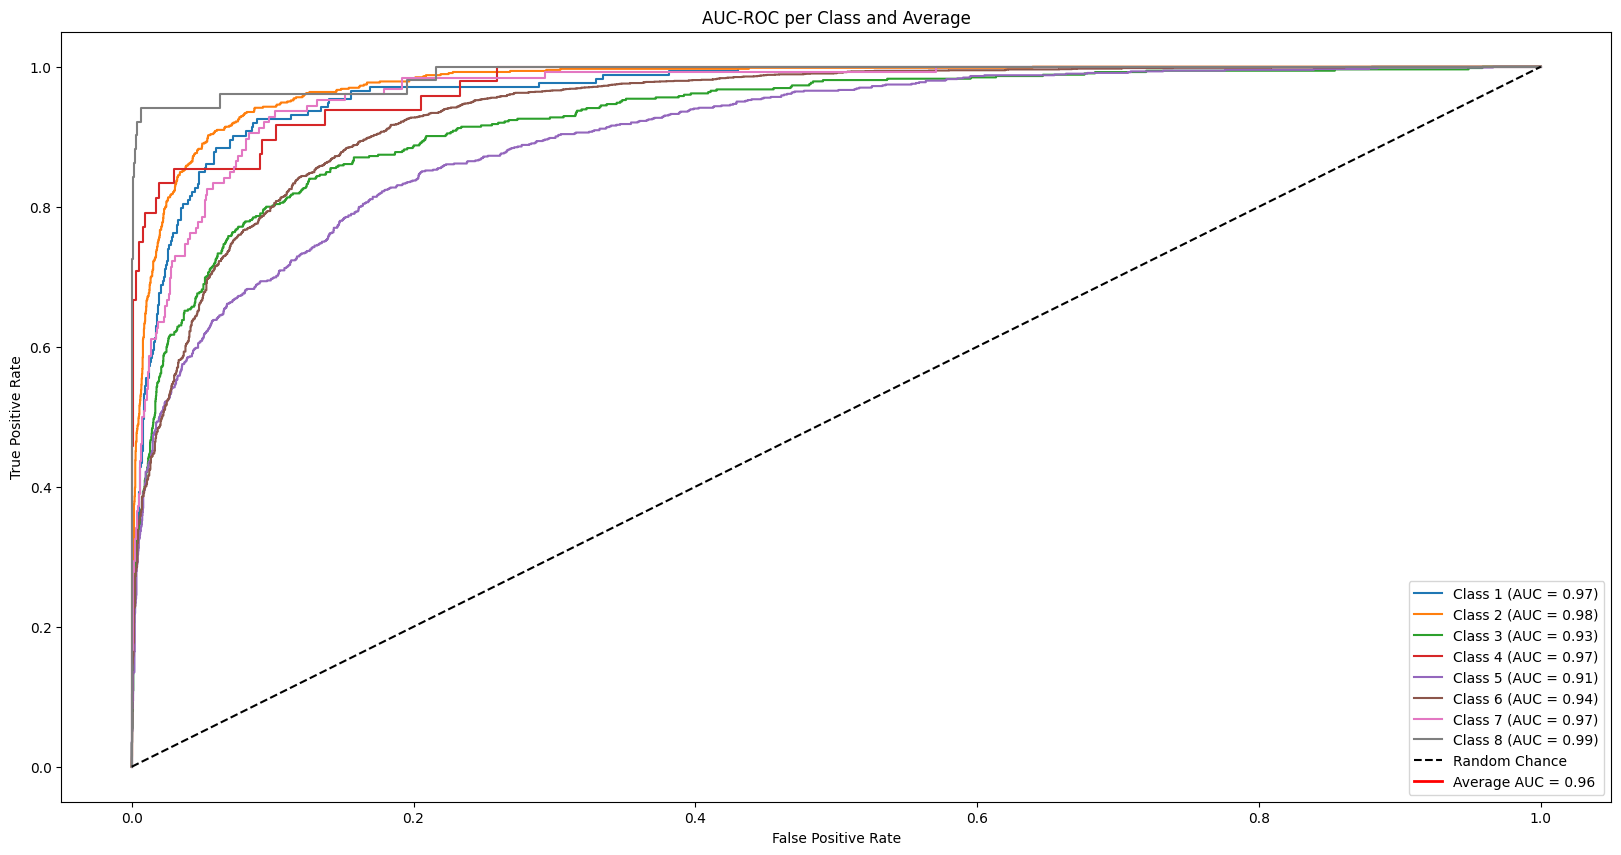

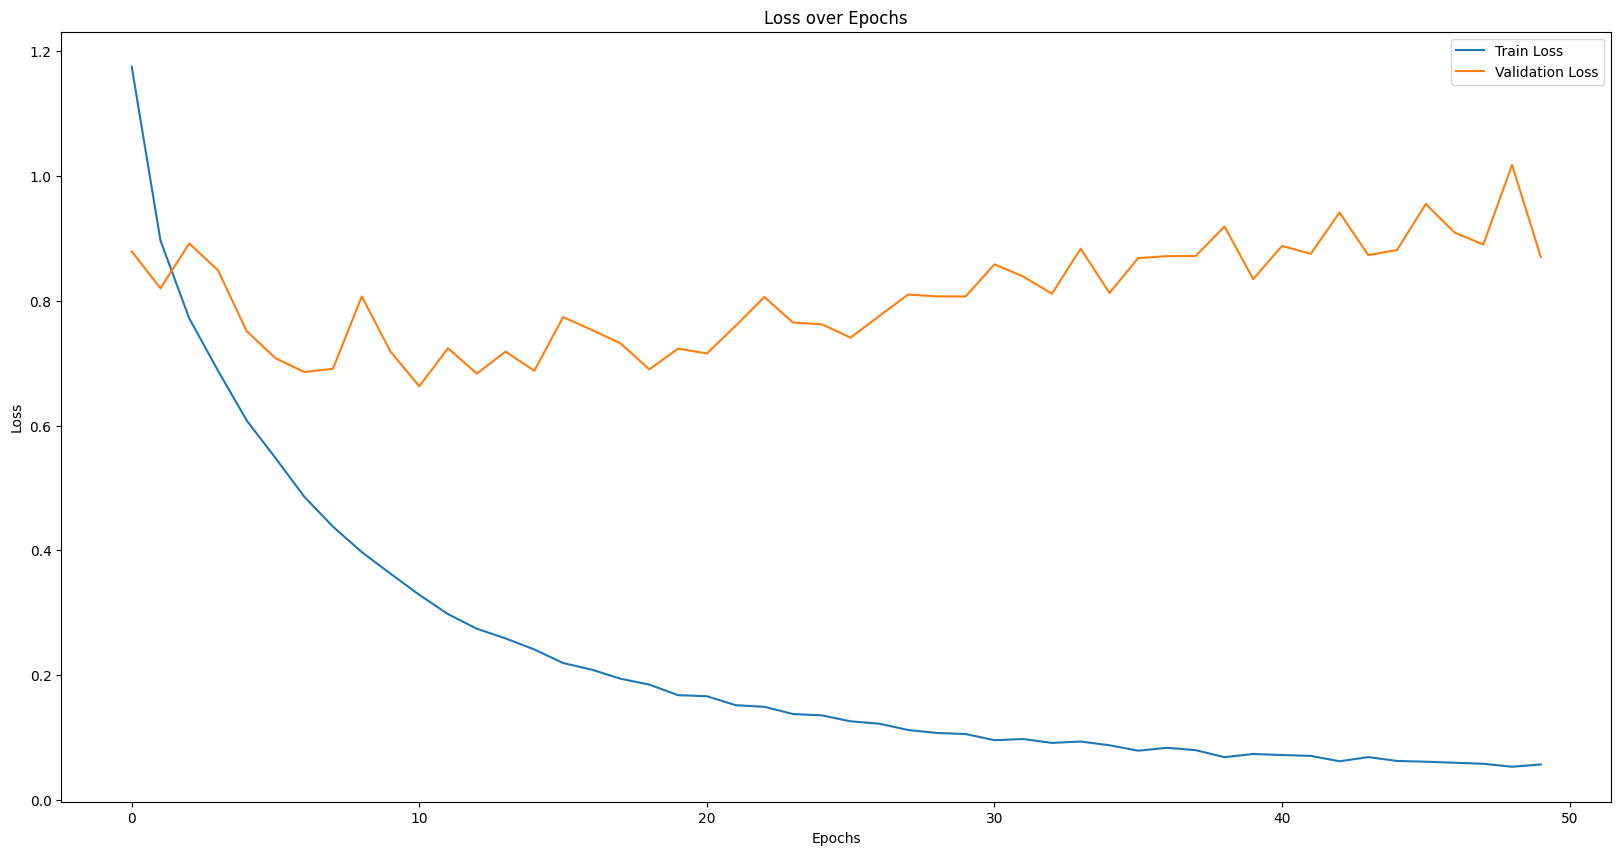

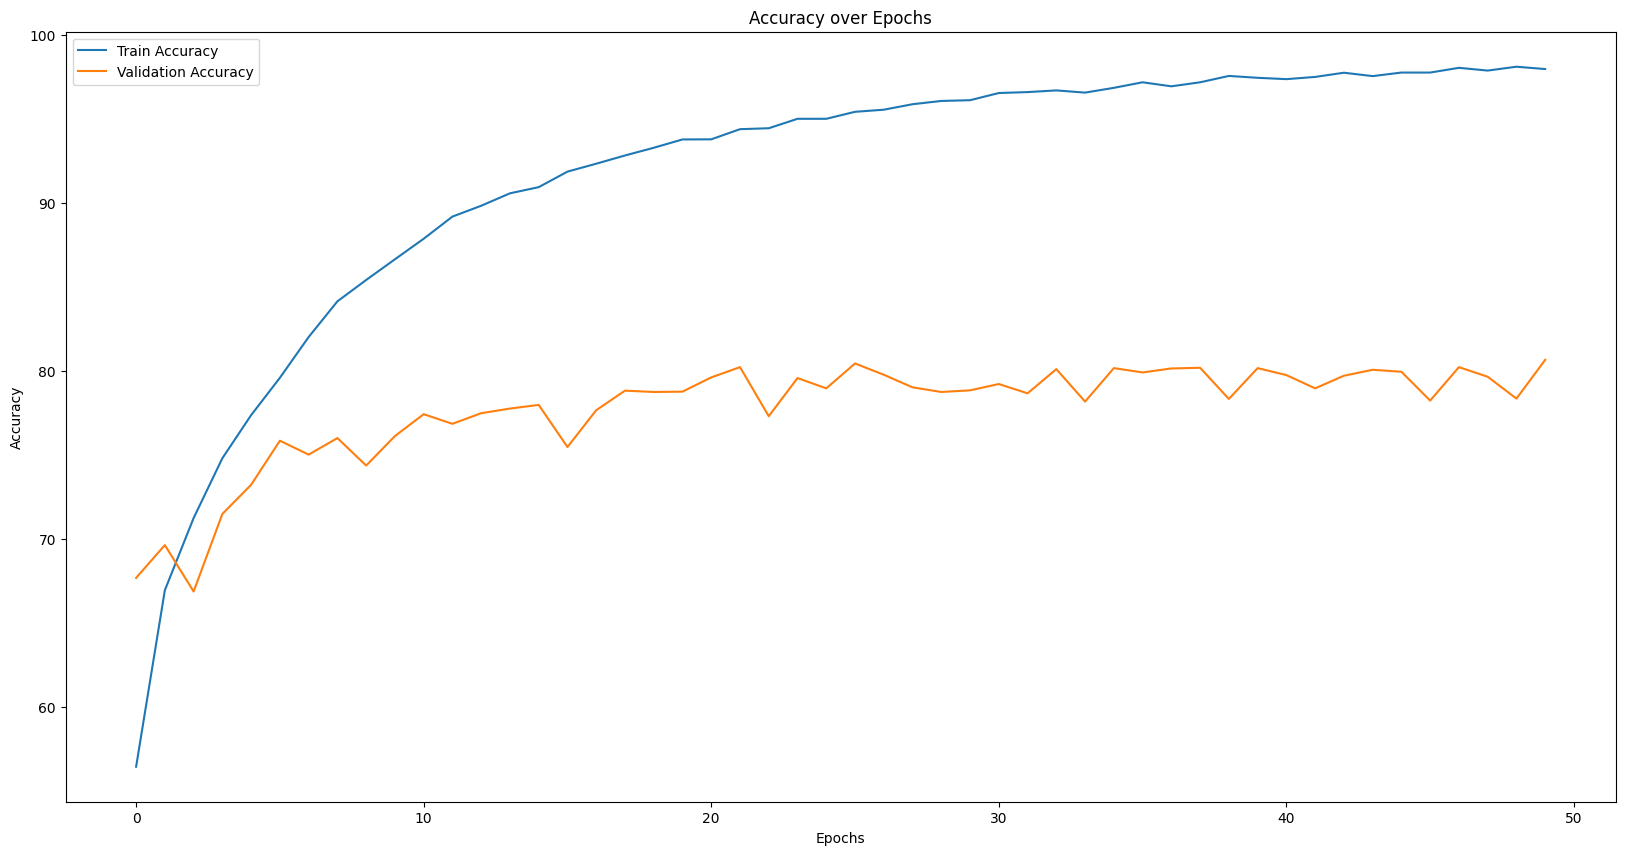

In [ ]:
# Load the best model for final evaluation
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score, roc_curve
model.load_state_dict(torch.load('best_model_processed.pth'))

#all_labels = []
#all_outputs = []

# Final evaluation function for test set
def final_evaluate_model(data_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            labels = convert_one_hot_to_indices(labels)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_outputs.extend(probs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, np.argmax(all_outputs, axis=1), average='weighted')
    # Individual and average AUC-ROC calculations
    aucs = roc_auc_score(all_labels, all_outputs, multi_class='ovr', average=None)
    avg_auc = np.mean(aucs)
    return avg_loss, accuracy, f1, aucs, avg_auc, all_labels, all_outputs

# Execute final evaluation on the test set
test_loss, test_accuracy, test_f1, test_aucs, test_avg_auc, all_labels, all_outputs = final_evaluate_model(test_loader)
print(f'Final Test Results - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')
print(f'Final Test Metrics - F1 Score: {test_f1:.4f}, AUCs: {test_aucs}, Average AUC: {test_avg_auc:.4f}')

# Plot for AUC-ROC
plt.figure(figsize=(20, 10))
for i in range(8):
    fpr, tpr, _ = roc_curve([1 if x == i else 0 for x in all_labels], [x[i] for x in all_outputs])
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {test_aucs[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.plot(np.nan, np.nan, label=f'Average AUC = {test_avg_auc:.2f}', color='red', linewidth=2)  # Placeholder for average AUC
plt.title('AUC-ROC per Class and Average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Plot training and validation loss and accuracy
plt.figure(figsize=(20, 10))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_loss.png')
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_validation_accuracy.png')
plt.show()

### 4.2.5 Proposed Data - Resnet50 With SVM

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


Test Accuracy: 0.7219261890665087
Test Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.29      0.36       173
           1       0.56      0.80      0.65       665
           2       0.57      0.51      0.54       525
           3       0.67      0.17      0.27        48
           4       0.71      0.53      0.60       904
           5       0.82      0.88      0.85      2575
           6       0.52      0.27      0.36       126
           7       0.88      0.43      0.58        51

    accuracy                           0.72      5067
   macro avg       0.65      0.48      0.53      5067
weighted avg       0.72      0.72      0.71      5067

AUCs: Class 0: 0.9299, Class 1: 0.9403, Class 2: 0.8839, Class 3: 0.9184, Class 4: 0.8679, Class 5: 0.9211, Class 6: 0.9336, Class 7: 0.9585, Average: 0.9192


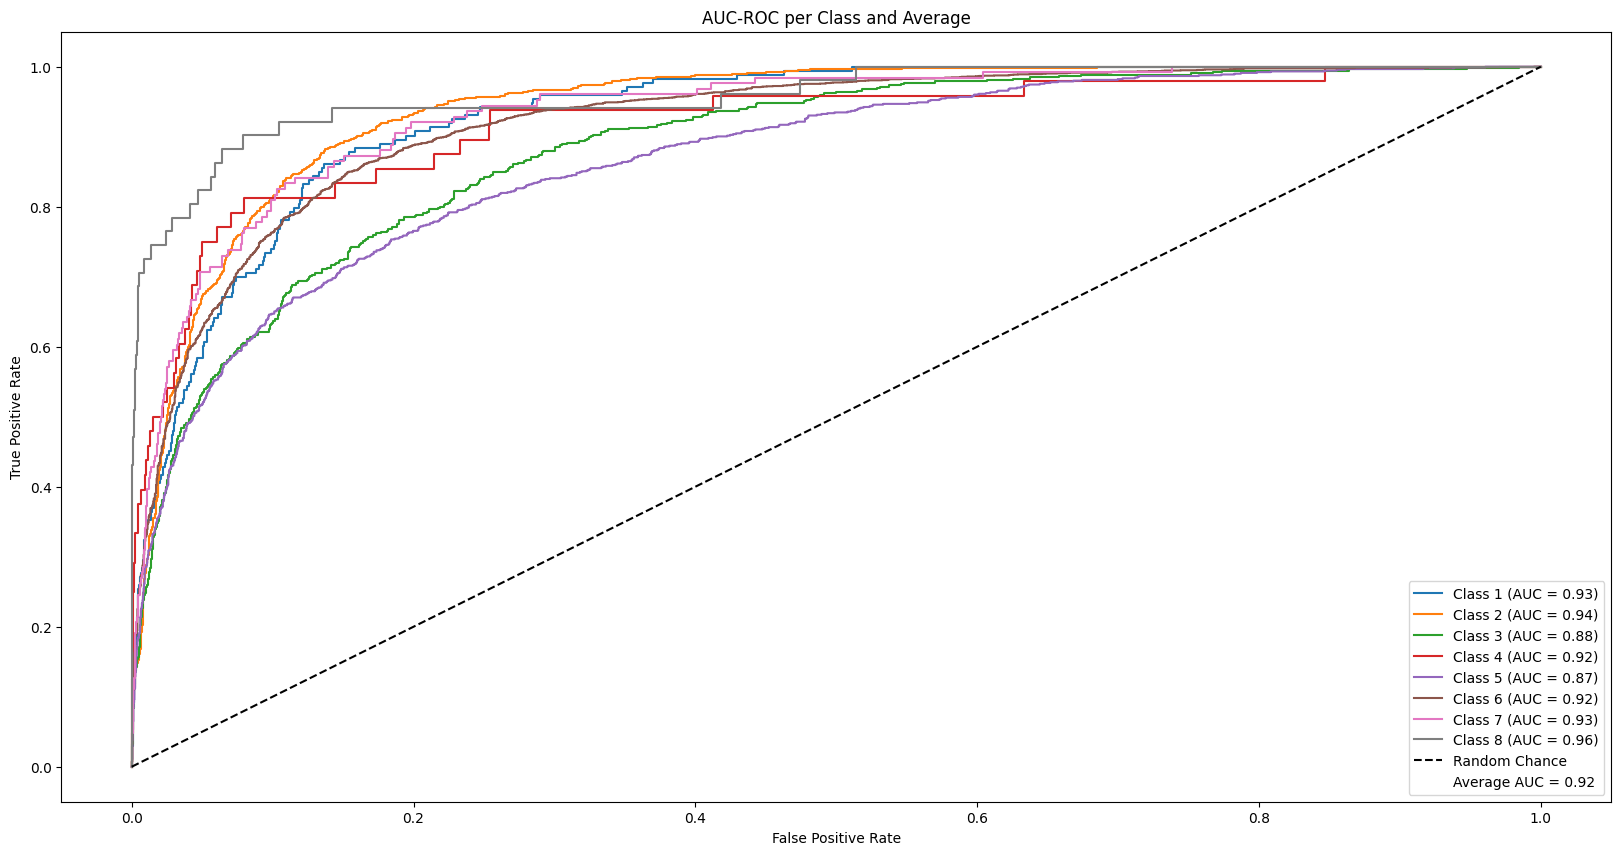

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models.resnet import ResNet50_Weights
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Model setup for feature extraction
weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)
model.fc = nn.Identity()  # Modify to extract features
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Function to convert one-hot encoded labels to indices
def convert_one_hot_to_indices(labels):
    if labels.ndim > 1:  # Check if labels are one-hot encoded
        labels = torch.argmax(labels, dim=1)
    return labels

# Function to extract features
def extract_features(data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, labels_batch in data_loader:
            images = images.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
            labels_batch = convert_one_hot_to_indices(labels_batch)  # Convert labels if necessary
            labels.extend(labels_batch.numpy())
    return features, labels

# Define softmax function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Setup data loaders
# Make sure to fill in DataLoader(...) with actual data loading logic
# Extract features
train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)
test_features, test_labels = extract_features(test_loader)

# Combine training and validation features and labels for training
combined_features = np.concatenate((train_features, val_features))
combined_labels = np.concatenate((train_labels, val_labels))

# Setup and train SVM with fixed parameters
svm_classifier = SVC(kernel='poly', degree=3, C=1.0, gamma='scale', probability=True)
svm_classifier.fit(combined_features, combined_labels)  # Train on combined data

# Evaluate using the trained model on test set
test_predictions = svm_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:")
print(classification_report(test_labels, test_predictions))

# Compute decision scores or probabilities
probabilities = svm_classifier.predict_proba(test_features)

# Compute ROC AUC for each class and average
auc_scores = roc_auc_score(test_labels, probabilities, multi_class='ovr', average=None)
average_auc = roc_auc_score(test_labels, probabilities, multi_class='ovr', average='macro')

# Compute F1 score for each class and average
#f1_scores = f1_score(test_labels, test_predictions, average=None)
average_f1 = f1_score(test_labels, test_predictions, average='weighted')

# Formatted printing of ROC AUC scores and F1 scores
formatted_auc_scores = ", ".join([f"Class {i}: {score:.4f}" for i, score in enumerate(auc_scores)])
#formatted_f1_scores = ", ".join([f"Class {i}: {score:.4f}" for i, score in enumerate(f1_scores)])
print(f"AUCs: {formatted_auc_scores}, Average: {average_auc:.4f}")
#print(f"F1 Scores: {formatted_f1_scores}, Average: {average_f1:.4f}")


# Plot for AUC-ROC
plt.figure(figsize=(20, 10))
for i in range(len(auc_scores)):
    fpr, tpr, _ = roc_curve([1 if x == i else 0 for x in test_labels], [x[i] for x in probabilities])
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc_scores[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.plot([], [], ' ', label=f'Average AUC = {average_auc:.2f}', color='red', linewidth=2)  # Placeholder for average AUC
plt.title('AUC-ROC per Class and Average')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


## 4.3 Model - Feature Extraction (ResNet101)



### 4.3.1 ResNet101 Overview

We used the resnet101 model in addition to the resnet50 model.

In this image you can see a detailed structural comparison of the resnet family model. resnet50 and resnet101 are basically the same, the only difference is that resnet50 has six blocks with three layers here in conv4_x, and resnet101 has 23 blocks with three layers here.



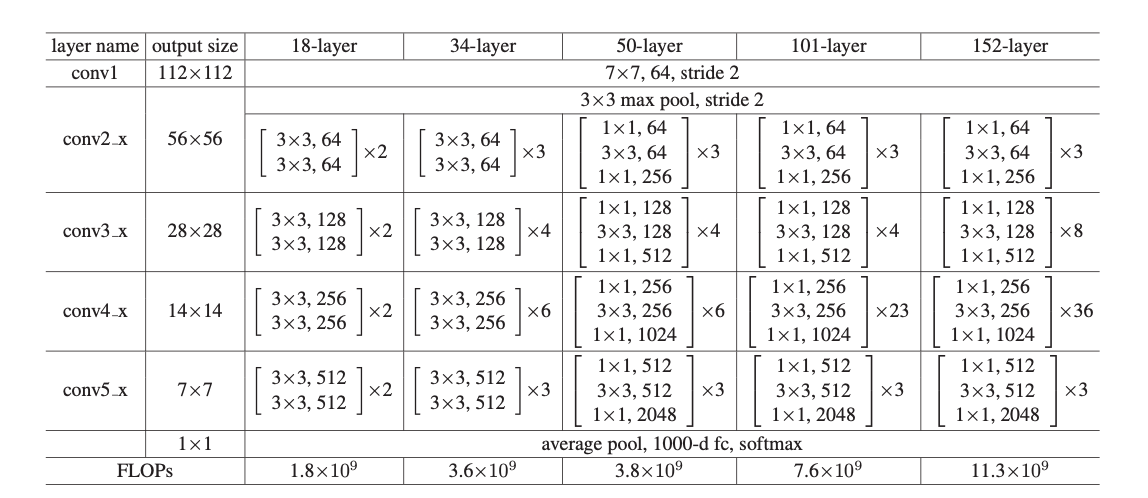
\[3\]

The only difference we can see here between resnet50 and resnet101 is the number of layers. resent101 has 51 more layers than resnet50. Because ResNet101 has more layers than resnet50, it can learn more features for better results. You can see this in our code results below, which show that ResNet101 does a lot better than resnet50.

Calculation



```
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()
```





```
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
```





```
from torchmetrics import Accuracy, AUROC, JaccardIndex

f1 = F1Score(task = "multilabel",num_labels=8).to("cuda")
accuracy = Accuracy(task="multilabel", num_labels=8).to("cuda")
auc = AUROC(task="multilabel", num_labels=8).to("cuda")

```



### 4.3.1 Original Data - Resnet101 With Fully Connected Layer

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Modify the file paths here
csv_file_path = '/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/ISIC_2019_Training_Input'

data = pd.read_csv(csv_file_path)

# Extract image filenames and labels
image_files = data['image'].values
labels = data.drop(['image', 'UNK'], axis=1).values

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2

# Define a custom dataset class
class SkinDiseaseDataset(Dataset):
    def __init__(self, image_files, labels, image_dir, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx] + ".jpg")
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create training, validation, and testing datasets
train_dataset = SkinDiseaseDataset(train_images, train_labels, image_dir = image_folder_path, transform=transform)
val_dataset = SkinDiseaseDataset(val_images, val_labels, image_dir = image_folder_path, transform=transform)
test_dataset = SkinDiseaseDataset(test_images, test_labels, image_dir = image_folder_path, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# print(len(train_dataset))
# print(len(val_dataset))
# print(len(test_dataset))


Original Dataset Compute Loss


In [ ]:
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()

Original Dataset with Model-Resnet101


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import timm
model_name = 'resnet101'
model = timm.create_model(model_name, pretrained=True, num_classes=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Original Dataset Optimiser



In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

Original Dataset Metrics

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 48.1 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy, AUROC, JaccardIndex

f1 = F1Score(task = "multilabel",num_labels=8).to("cuda")
accuracy = Accuracy(task="multilabel", num_labels=8).to("cuda")
auc = AUROC(task="multilabel", num_labels=8).to("cuda")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Original Dataset Train and Validation with Linear Processing

In [ ]:
import time

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=50):

    start = time.time()
    history = []
    best_loss = float('inf')
    best_epoch = None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"Epoch: {epoch+1}/{epochs}")

        model.train()

        train_loss = 0.0
        valid_loss = 0.0

        accuracy.reset()

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, labels.float())

            loss.backward()

            optimizer.step()

            train_loss += loss.item() * images.size(0)

            accuracy.update(outputs, labels.float())

        train_accuracy = accuracy.compute()

        model.eval()
        accuracy.reset()

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                loss = criterion(outputs, labels.float())

                valid_loss += loss.item() * images.size(0)

                accuracy.update(outputs, labels)

        val_accuracy = accuracy.compute()

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_valid_loss = valid_loss / len(val_loader.dataset)

        history.append([avg_train_loss, avg_valid_loss, train_accuracy, val_accuracy])

        epoch_end = time.time()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f},"
              f" Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Time: {epoch_end-epoch_start:.4f}s")


        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pt')

    return model, history, best_epoch


trained_model, history, best_epoch = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=50)
torch.save(history, 'training_history.pt')


Epoch: 1/50
Epoch 1/50, Train Loss: 0.2127, Val Loss: 0.1833, Train Accuracy: 0.9181, Val Accuracy: 0.9258, Time: 4151.9488s
Epoch: 2/50
Epoch 2/50, Train Loss: 0.1647, Val Loss: 0.1579, Train Accuracy: 0.9343, Val Accuracy: 0.9392, Time: 131.5656s
Epoch: 3/50
Epoch 3/50, Train Loss: 0.1391, Val Loss: 0.1555, Train Accuracy: 0.9444, Val Accuracy: 0.9386, Time: 134.3398s
Epoch: 4/50
Epoch 4/50, Train Loss: 0.1122, Val Loss: 0.1421, Train Accuracy: 0.9561, Val Accuracy: 0.9450, Time: 133.2520s
Epoch: 5/50
Epoch 5/50, Train Loss: 0.0899, Val Loss: 0.1470, Train Accuracy: 0.9653, Val Accuracy: 0.9447, Time: 133.8333s
Epoch: 6/50
Epoch 6/50, Train Loss: 0.0734, Val Loss: 0.1746, Train Accuracy: 0.9718, Val Accuracy: 0.9397, Time: 133.5878s
Epoch: 7/50
Epoch 7/50, Train Loss: 0.0513, Val Loss: 0.1708, Train Accuracy: 0.9810, Val Accuracy: 0.9456, Time: 133.6534s
Epoch: 8/50
Epoch 8/50, Train Loss: 0.0394, Val Loss: 0.1794, Train Accuracy: 0.9859, Val Accuracy: 0.9445, Time: 133.4544s
Epoch: 

Original Dataset Train and Validation Visualization

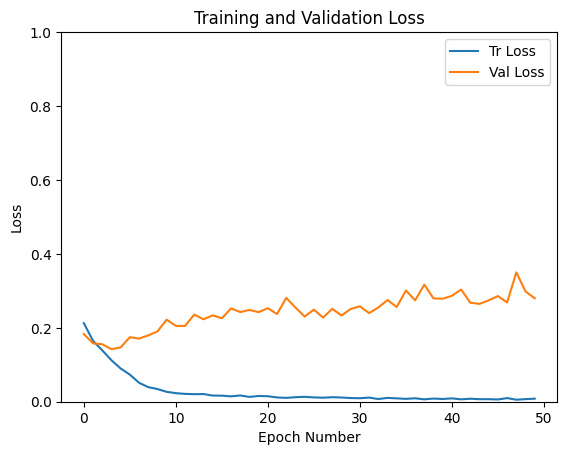

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


history = [[item.cpu().numpy() if torch.is_tensor(item) else item for item in sublist] for sublist in history]
history = np.array(history)


plt.plot(history[:, 0], label='Tr Loss')
plt.plot(history[:, 1], label='Val Loss')
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Training and Validation Loss')
plt.savefig('loss_curve.png')
plt.show()


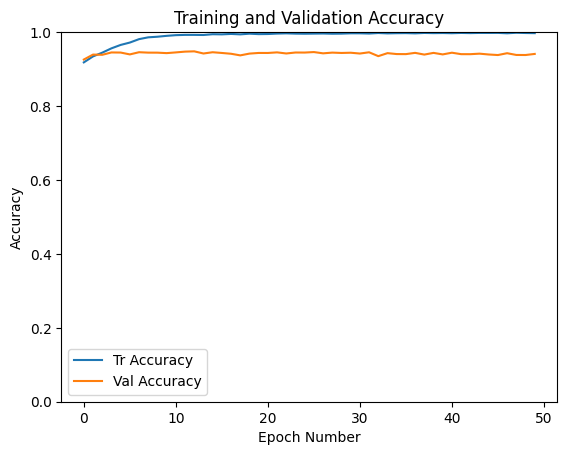

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

history = [[item.cpu().numpy() if torch.is_tensor(item) else item for item in sublist] for sublist in history]
history = np.array(history)


plt.plot(history[:, 2], label='Tr Accuracy')
plt.plot(history[:, 3], label='Val Accuracy')
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Training and Validation Accuracy')
plt.savefig('accuracy_curve.png')
plt.show()


Loss, Accuracy, F1 Score, AUROC using Original Test Dataset


In [ ]:
def computeTestSetMetrics(model, loss_criterion, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_loss = 0.0
    total_samples = 0

    accuracy = Accuracy(task="multilabel", num_labels=8).to(device)
    f1 = F1Score(task="multilabel", num_labels=8).to(device)

    auc_per_label = [AUROC(task="binary").to(device) for _ in range(8)]
    overall_auc = AUROC(task="multilabel", num_labels=8).to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        model.eval()

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = loss_criterion(outputs, labels.float())
            test_loss += loss.item() * inputs.size(0)

            all_preds.append(outputs)
            all_labels.append(labels)

            accuracy.update(outputs, labels)
            f1.update(outputs, labels)

            for i in range(8):
                auc_per_label[i].update(outputs[:, i], labels[:, i])

            overall_auc.update(outputs, labels)
            total_samples += inputs.size(0)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        avg_test_loss = test_loss / total_samples
        avg_test_acc = accuracy.compute().item()
        auc_scores = [auc.compute().item() for auc in auc_per_label]
        f1_score = f1.compute().item()
        overall_auc_score = overall_auc.compute().item()

        print(f"Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {avg_test_acc:.4f}")
        print(f"Test F1 Score: {f1_score:.4f}")
        print(f"Overall AUC: {overall_auc_score:.4f}")

        for i, auc_score in enumerate(auc_scores):
            print(f"Test AUC for label {i}: {auc_score:.4f}")

    return avg_test_loss, avg_test_acc, auc_scores, f1_score, overall_auc_score

computeTestSetMetrics(trained_model, criterion, test_loader)


Test Loss: 0.2840
Test Accuracy: 0.9404
Test F1 Score: 0.7524
Overall AUC: 0.9350
Test AUC for label 0: 0.8861
Test AUC for label 1: 0.9367
Test AUC for label 2: 0.9604
Test AUC for label 3: 0.9280
Test AUC for label 4: 0.9015
Test AUC for label 5: 0.9578
Test AUC for label 6: 0.9781
Test AUC for label 7: 0.9314
(0.284, 0.9404, [0.8860601782798767, 0.936693549156189, 0.9604355096817017, 0.928024411201477, 0.9014753699302673, 0.9577605128288269, 0.9781057834625244, 0.9314019680023193], 0.7524, 0.935)


### 4.3.2 Original Data - Resnet101 With SVM

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models.resnet import ResNet101_Weights
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score,, roc_auc_score, accuracy_score
import numpy as np
import torch.nn as nn

# Load a pretrained ResNet101 model without the final fully connected layer
weights = ResNet101_Weights.DEFAULT
model = models.resnet101(weights=weights)
model.fc = nn.Identity()  # Remove the final layer

# Transfer model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

def convert_one_hot_to_indices(labels):
    if labels.ndim > 1:  # Check if labels are one-hot encoded
        labels = torch.argmax(labels, dim=1)
    return labels

def extract_features(data_loader):
    features = []
    labels = []

    with torch.no_grad():
        for images, labels_batch in data_loader:
            images = images.to(device)
            output = model(images)
            features.extend(output.cpu().numpy())
            labels_batch = convert_one_hot_to_indices(labels_batch)
            labels.extend(labels_batch.cpu().numpy())
    return np.array(features), np.array(labels)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Assume train_loader and test_loader are defined
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

# Train SVM
svm_classifier = SVC(kernel='poly', degree=3, C=1.0, random_state=42, probability=True)
svm_classifier.fit(train_features, train_labels)

# Evaluate SVM
test_predictions = svm_classifier.predict(test_features)
accuracy = accuracy_score(test_labels, test_predictions)

print('Results for Data Processed With Cubic SVM Classifications Option')
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")
#print(classification_report(test_labels, test_predictions))

# Compute metrics
f1 = f1_score(test_labels, test_predictions, average='weighted')
probabilities = svm_classifier.predict_proba(test_features)
auc = roc_auc_score(test_labels, probabilities, multi_class='ovr', average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

# Calculate AUROC for each label
num_labels = len(np.unique(train_labels))
auc_scores_per_label = []

for i in range(num_labels):
    binary_labels = (test_labels == i).astype(int)
    binary_probabilities = probabilities[:, i]
    auc_per_label = roc_auc_score(binary_labels, binary_probabilities)
    auc_scores_per_label.append(auc_per_label)
    print(f"AUROC for label {i}: {auc_per_label:.4f}")



Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 212MB/s]
Results for Data Processed With Cubic SVM Classifications Option
Test Set Accuracy: 71.03%
F1 Score: 0.6812
AUC Score: 0.9124
AUROC for label 0: 0.8788
AUROC for label 1: 0.9210
AUROC for label 2: 0.9381
AUROC for label 3: 0.9204
AUROC for label 4: 0.8833
AUROC for label 5: 0.8831
AUROC for label 6: 0.9716
AUROC for label 7: 0.9459


### 4.3.3 Processed Data - Resnet101 With Fully Connected Layer

New Dataset preprocessing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Modify here
csv_file_path = '/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/ISIC_2019_Training_Input'

data = pd.read_csv(csv_file_path)

# Extract image filenames and labels
data['label'] = data.drop(['image', 'UNK'], axis=1).idxmax(axis=1)
image_files = data['image'].values
labels = data['label'].values

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Split the training set into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data['label'])

# Set minimum and maximum sample sizes
min_samples = 2000
max_samples = 5000

balanced_train_data = pd.DataFrame()

class RandomRotate180:
    def __call__(self, img):
        if random.random() > 0.5:
            return img.rotate(180)
        return img

# Augmentation transforms for training data
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    RandomRotate180(),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ColorJitter(contrast=(0.5, 1.5))
])

# Common transforms for all data
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for label in train_data['label'].unique():
    label_data = train_data[train_data['label'] == label]
    count = len(label_data)

    if count < min_samples:
        n_samples = min(max_samples, max(min_samples, count * 2))
        n_augment = n_samples - count

        augmented_data = []
        for _, row in label_data.iterrows():
            img_name = os.path.join(image_folder_path, row['image'] + ".jpg")
            image = Image.open(img_name).convert('RGB')
            augmented_data.append([row['image'], label])

        for i in range(n_augment):
            img_name = os.path.join(image_folder_path, label_data.iloc[i % count]['image'] + ".jpg")
            image = Image.open(img_name).convert('RGB')
            augmented_image = augmentation_transforms(image)
            augmented_image_name = f"{label_data.iloc[i % count]['image']}_augmented_{i}"
            augmented_image_path = os.path.join(image_folder_path, augmented_image_name + ".jpg")

            # Save the augmented image only if it doesn't already exist
            if not os.path.exists(augmented_image_path):
                augmented_image.save(augmented_image_path)

            augmented_data.append([augmented_image_name, label])

        augmented_df = pd.DataFrame(augmented_data, columns=['image', 'label'])
        label_data = pd.concat([label_data, augmented_df])

    elif count > max_samples:
        n_samples = max(min_samples, int(count * 0.8))
        label_data = resample(label_data, replace=False, n_samples=n_samples, random_state=42)

    balanced_train_data = pd.concat([balanced_train_data, label_data])

# Separate the image filenames and labels of the training set
train_images = balanced_train_data['image'].values
train_labels = pd.get_dummies(balanced_train_data['label']).values

# Separate the image filenames and labels of the validation set
val_images = val_data['image'].values
val_labels = pd.get_dummies(val_data['label']).values

# Separate the image filenames and labels of the test set
test_images = test_data['image'].values
test_labels = pd.get_dummies(test_data['label']).values

# Define the dataset class
class SkinDiseaseDataset(Dataset):
    def __init__(self, image_files, labels, image_dir, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx] + ".jpg")
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Image transformation for training data
train_transform = transforms.Compose([
    augmentation_transforms,
    common_transforms
])

# Create training, validation, and test datasets
train_dataset = SkinDiseaseDataset(train_images, train_labels, image_dir=image_folder_path, transform=train_transform)
val_dataset = SkinDiseaseDataset(val_images, val_labels, image_dir=image_folder_path, transform=common_transforms)
test_dataset = SkinDiseaseDataset(test_images, test_labels, image_dir=image_folder_path, transform=common_transforms)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Check if balanced
# train_counts = balanced_train_data['label'].value_counts()
# val_counts = val_data['label'].value_counts()
# test_counts = test_data['label'].value_counts()

# print("Training set label counts:")
# print(train_counts)
# print("\nValidation set label counts:")
# print(val_counts)
# print("\nTest set label counts:")
# print(test_counts)


New Dataset Compute Loss

In [ ]:
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()

New Dataset with Model-Resnet101

In [ ]:
!pip install timm

In [ ]:
import timm
model_name = 'resnet101'
model = timm.create_model(model_name, pretrained=True, num_classes=8)

New Dataset Optimiser

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

New Dataset Metric

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 48.2 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy, AUROC, JaccardIndex

f1 = F1Score(task = "multilabel",num_labels=8).to("cuda")
accuracy = Accuracy(task="multilabel", num_labels=8).to("cuda")
auc = AUROC(task="multilabel", num_labels=8).to("cuda")


New Dataset Train and Validation with Linear Processing


In [ ]:
import time

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=50):

    start = time.time()
    history = []
    best_loss = float('inf')
    best_epoch = None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"Epoch: {epoch+1}/{epochs}")

        model.train()

        train_loss = 0.0
        valid_loss = 0.0

        accuracy.reset()

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, labels.float())

            loss.backward()

            optimizer.step()

            train_loss += loss.item() * images.size(0)

            accuracy.update(outputs, labels.float())

        train_accuracy = accuracy.compute()

        model.eval()
        accuracy.reset()

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                loss = criterion(outputs, labels.float())

                valid_loss += loss.item() * images.size(0)

                accuracy.update(outputs, labels)

        val_accuracy = accuracy.compute()

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_valid_loss = valid_loss / len(val_loader.dataset)

        history.append([avg_train_loss, avg_valid_loss, train_accuracy, val_accuracy])

        epoch_end = time.time()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f},"
              f" Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Time: {epoch_end-epoch_start:.4f}s")


        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pt')

    return model, history, best_epoch


trained_model, history, best_epoch = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=50)
torch.save(history, 'training_history.pt')


Epoch: 1/50
Epoch 1/50, Train Loss: 0.2284, Val Loss: 0.1772, Train Accuracy: 0.9092, Val Accuracy: 0.9284, Time: 2308.4247s
Epoch: 2/50
Epoch 2/50, Train Loss: 0.1496, Val Loss: 0.2051, Train Accuracy: 0.9392, Val Accuracy: 0.9205, Time: 228.6533s
Epoch: 3/50
Epoch 3/50, Train Loss: 0.1169, Val Loss: 0.1698, Train Accuracy: 0.9531, Val Accuracy: 0.9331, Time: 229.0388s
Epoch: 4/50
Epoch 4/50, Train Loss: 0.0956, Val Loss: 0.1729, Train Accuracy: 0.9625, Val Accuracy: 0.9318, Time: 229.7345s
Epoch: 5/50
Epoch 5/50, Train Loss: 0.0820, Val Loss: 0.1401, Train Accuracy: 0.9677, Val Accuracy: 0.9470, Time: 229.1255s
Epoch: 6/50
Epoch 6/50, Train Loss: 0.0723, Val Loss: 0.1930, Train Accuracy: 0.9716, Val Accuracy: 0.9270, Time: 229.3223s
Epoch: 7/50
Epoch 7/50, Train Loss: 0.0613, Val Loss: 0.1496, Train Accuracy: 0.9758, Val Accuracy: 0.9462, Time: 228.9938s
Epoch: 8/50
Epoch 8/50, Train Loss: 0.0550, Val Loss: 0.1436, Train Accuracy: 0.9784, Val Accuracy: 0.9446, Time: 228.9056s
Epoch: 

New Dataset Train and Validation Visualization

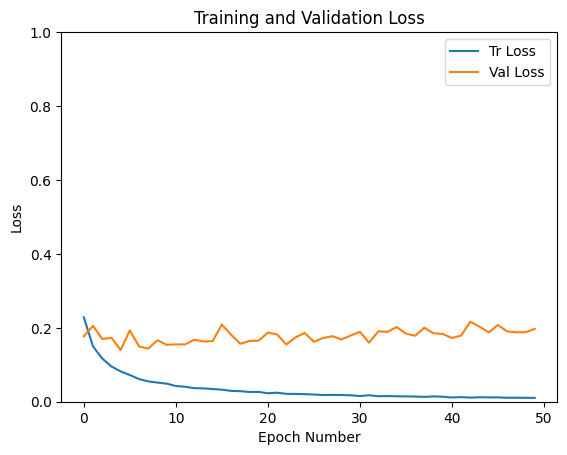

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


history = [[item.cpu().numpy() if torch.is_tensor(item) else item for item in sublist] for sublist in history]
history = np.array(history)


plt.plot(history[:, 0], label='Tr Loss')
plt.plot(history[:, 1], label='Val Loss')
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Training and Validation Loss')
plt.savefig('loss_curve.png')
plt.show()


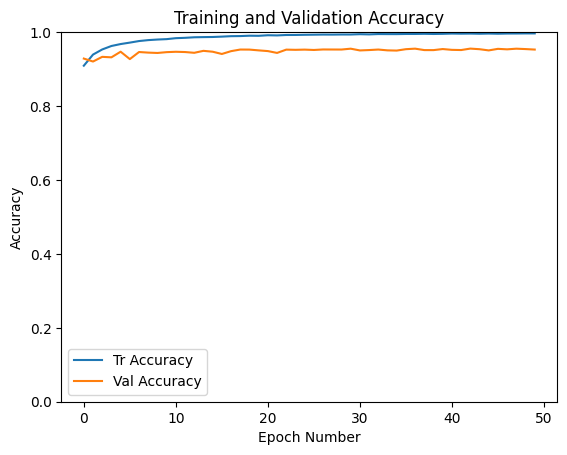

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

history = [[item.cpu().numpy() if torch.is_tensor(item) else item for item in sublist] for sublist in history]
history = np.array(history)


plt.plot(history[:, 2], label='Tr Accuracy')
plt.plot(history[:, 3], label='Val Accuracy')
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Training and Validation Accuracy')
plt.savefig('accuracy_curve.png')
plt.show()


Loss, Accuracy, F1 Score, AUROC using New Test Dataset

In [ ]:
def computeTestSetMetrics(model, loss_criterion, test_loader, threshold=0.5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_loss = 0.0
    total_samples = 0

    accuracy = Accuracy(task="multilabel", num_labels=8).to(device)
    f1 = F1Score(task="multilabel", num_labels=8).to(device)

    auc_per_label = [AUROC(task="binary").to(device) for _ in range(8)]
    overall_auc = AUROC(task="multilabel", num_labels=8).to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        model.eval()

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = loss_criterion(outputs, labels.float())
            test_loss += loss.item() * inputs.size(0)

            # Threshold outputs to obtain binary predictions
            binary_preds = (outputs >= threshold).int()

            all_preds.append(binary_preds)
            all_labels.append(labels.int())  # Ensure labels are integers

            accuracy.update(binary_preds, labels.int())
            f1.update(outputs, labels.int())

            for i in range(8):
                auc_per_label[i].update(outputs[:, i], labels[:, i].int())  # Ensure each label is an integer

            overall_auc.update(outputs, labels.int())  # Ensure labels are integers
            total_samples += inputs.size(0)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        avg_test_loss = test_loss / total_samples
        avg_test_acc = accuracy.compute().item()
        auc_scores = [auc.compute().item() for auc in auc_per_label]
        f1_score = f1.compute().item()
        overall_auc_score = overall_auc.compute().item()

        print(f"Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {avg_test_acc:.4f}")
        print(f"Test F1 Score: {f1_score:.4f}")
        print(f"Overall AUC: {overall_auc_score:.4f}")

        for i, auc_score in enumerate(auc_scores):
            print(f"Test AUC for label {i}: {auc_score:.4f}")

    return avg_test_loss, avg_test_acc, auc_scores, f1_score, overall_auc_score

# Example usage
computeTestSetMetrics(trained_model, criterion, test_loader)


Test Loss: 0.2045
Test Accuracy: 0.9510
Test F1 Score: 0.7524
Overall AUC: 0.9531
Test AUC for label 0: 0.9597
Test AUC for label 1: 0.9735
Test AUC for label 2: 0.9315
Test AUC for label 3: 0.9633
Test AUC for label 4: 0.9049
Test AUC for label 5: 0.9494
Test AUC for label 6: 0.9467
Test AUC for label 7: 0.9960
(0.2045259605604256, 0.950957179069519, [0.9597277045249939, 0.9734513759613037, 0.9314782619476318, 0.963314414024353, 0.9048947691917419, 0.9494282007217407, 0.9467285871505737, 0.995954155921936], 0.5721563696861267, 0.9531221985816956)


### 4.3.4 Processed Data - Resnet101 With SVM

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models.resnet import ResNet101_Weights
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score
import numpy as np
import torch.nn as nn

# Load a pretrained ResNet101 model without the final fully connected layer
weights = ResNet101_Weights.DEFAULT
model = models.resnet101(weights=weights)
model.fc = nn.Identity()  # Remove the final layer

# Transfer model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

def convert_one_hot_to_indices(labels):
    if labels.ndim > 1:  # Check if labels are one-hot encoded
        labels = torch.argmax(labels, dim=1)
    return labels

def extract_features(data_loader):
    features = []
    labels = []

    with torch.no_grad():
        for images, labels_batch in data_loader:
            images = images.to(device)
            output = model(images)
            features.extend(output.cpu().numpy())
            labels_batch = convert_one_hot_to_indices(labels_batch)
            labels.extend(labels_batch.cpu().numpy())
    return np.array(features), np.array(labels)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Assume train_loader and test_loader are defined
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

# Train SVM
svm_classifier = SVC(kernel='poly', degree=3, C=1.0, random_state=42, probability=True)
svm_classifier.fit(train_features, train_labels)

# Evaluate SVM
test_predictions = svm_classifier.predict(test_features)
accuracy = accuracy_score(test_labels, test_predictions)

print('Results for Data Processed With Cubic SVM Classifications Option')
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")
#print(classification_report(test_labels, test_predictions))

# Compute metrics
f1 = f1_score(test_labels, test_predictions, average='weighted')
probabilities = svm_classifier.predict_proba(test_features)
auc = roc_auc_score(test_labels, probabilities, multi_class='ovr', average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

# Calculate AUROC for each label
num_labels = len(np.unique(train_labels))
auc_scores_per_label = []

for i in range(num_labels):
    binary_labels = (test_labels == i).astype(int)
    binary_probabilities = probabilities[:, i]
    auc_per_label = roc_auc_score(binary_labels, binary_probabilities)
    auc_scores_per_label.append(auc_per_label)
    print(f"AUROC for label {i}: {auc_per_label:.4f}")



Results for Data Processed With Cubic SVM Classifications Option
Test Set Accuracy: 70.42%
F1 Score: 0.6973
AUC Score: 0.9053
AUROC for label 0: 0.9204
AUROC for label 1: 0.9356
AUROC for label 2: 0.8707
AUROC for label 3: 0.9187
AUROC for label 4: 0.8581
AUROC for label 5: 0.9185
AUROC for label 6: 0.9218
AUROC for label 7: 0.9335


## 4.4 Model - Feature Extraction (DenseNet201)

### 4.4.1 DenseNet201 Overview

DenseNet201 is a CNN that consists of a total of 201 layers. Not like the traditional CNN architecture, the DenseNet201 connects each layer to all other layers. This unique feature allows for the reuse of substantial features, which improves the learning process and reduces the risk of overfitting. This architecture is very efficient in the use of parameters and minimizes redundancy. Compared to other similar deep CNNs, the DenseNet201 needs fewer parameters to maintain an even better performance.

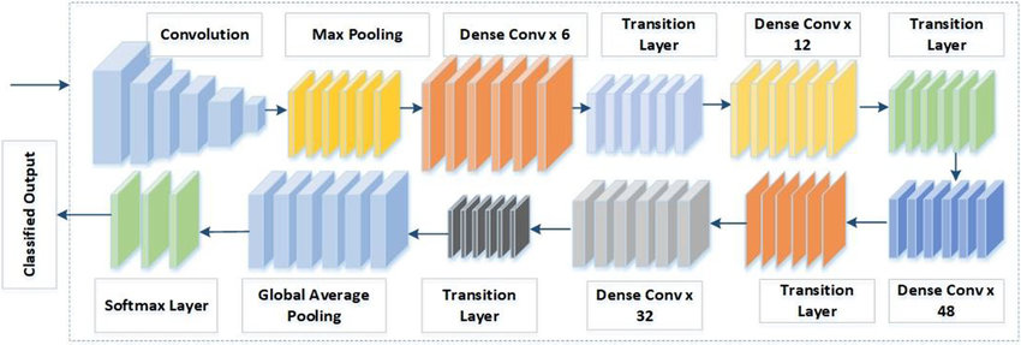
Detailed Architecture of an Efficient DenseNet-201 \[6\]

### 4.4.2 Data Process for TensorFlow

TensorFlow TPU Setup

Set up a TPU (Tensor Processing Unit) for distributed training. If a TPU is not available, it falls back to the default strategy.


In [ ]:
import tensorflow as tf

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.master())
except ValueError:
  tpu = None

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
else:
  strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  
REPLICAS:  8


Load and Preprocess Data

Load a CSV file containing ground truth labels for images, preprocessing the data by removing unnecessary columns, and updating the image paths.


In [ ]:
import pandas as pd
import os

csv_file_path = '/content/drive/MyDrive/COMP9444 Project/ISIC_2019_Training_GroundTruth.csv'
data = pd.read_csv(csv_file_path)
data.drop(columns='UNK', inplace=True)

image_folder_path = '/content/drive/MyDrive/COMP9444 Project/ISIC_2019_Training_Input'
data['image'] = data['image'].apply(lambda x: os.path.join(image_folder_path, x + '.jpg'))

data.head()


image  MEL   NV  BCC   AK  BKL  \
0  /content/drive/MyDrive/COMP9444 Project/ISIC_2...  0.0  1.0  0.0  0.0  0.0   
1  /content/drive/MyDrive/COMP9444 Project/ISIC_2...  0.0  1.0  0.0  0.0  0.0   
2  /content/drive/MyDrive/COMP9444 Project/ISIC_2...  1.0  0.0  0.0  0.0  0.0   
3  /content/drive/MyDrive/COMP9444 Project/ISIC_2...  0.0  1.0  0.0  0.0  0.0   
4  /content/drive/MyDrive/COMP9444 Project/ISIC_2...  1.0  0.0  0.0  0.0  0.0   

    DF  VASC  SCC  
0  0.0   0.0  0.0  
1  0.0   0.0  0.0  
2  0.0   0.0  0.0  
3  0.0   0.0  0.0  
4  0.0   0.0  0.0

Split Data into Training, Validation, and Test Sets

Split the dataset into training, validation, and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

print("Training data size:", train_data.shape)
print("Validation data size:", val_data.shape)
print("Test data size:", test_data.shape)


Training data size: (17731, 9)
Validation data size: (3800, 9)
Test data size: (3800, 9)


Visualize Class Distribution

Create a bar plot to visualize the distribution of different classes in the training data.

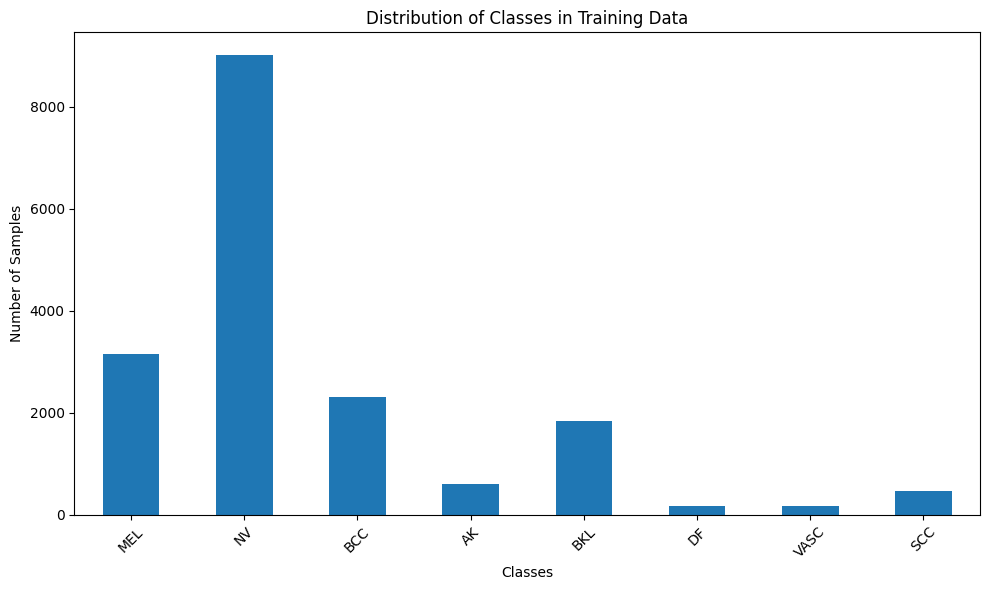

In [ ]:
import matplotlib.pyplot as plt

class_counts = train_data[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']].sum()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Calculate and print the number of samples for each category in the training data. Then, calculate the class imbalance ratio.

- **Calculate Class Counts**: Use `Counter` to count the number of samples for each category.
- **Print Class Counts**: Print the number of samples for each class.
- **Class Imbalance Ratio**: Compute the imbalance ratio by dividing the count of the most common class by the count of the least common class.


In [ ]:
from collections import Counter

# Calculate the number of samples for each category
class_counts = Counter(train_data[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']].values.argmax(axis=1))

# Print the number of samples for each category
for class_index, count in class_counts.items():
    print(f"Class {class_index}: {count} samples")

# Calculate the class imbalance ratio
most_common_class_count = class_counts.most_common(1)[0][1]
least_common_class_count = class_counts.most_common()[-1][1]
imbalance_ratio = most_common_class_count / least_common_class_count
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")


Class 1: 9007 samples
Class 2: 2318 samples
Class 5: 171 samples
Class 0: 3158 samples
Class 7: 462 samples
Class 4: 1835 samples
Class 3: 603 samples
Class 6: 177 samples
Imbalance Ratio: 52.67


Image Preprocessing and Data Augmentation

Define functions to load and preprocess images, perform data augmentation, and balance the dataset.



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input

# Define the image loading and preprocessing function
def preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    return image

# Define the data augmentation function
def augment_image(image):
    choice = tf.random.uniform([], 0, 5, dtype=tf.int32)
    def flip_vertical():
        return tf.image.flip_up_down(image)
    def rotate_180():
        return tf.image.rot90(image, k=2)
    def adjust_contrast():
        return tf.image.random_contrast(image, lower=0.8, upper=1.2)
    def random_crop_and_resize():
        cropped = tf.image.random_crop(image, [200, 200, 3])
        return tf.image.resize(cropped, [224, 224])
    def random_zoom():
        scale = tf.random.uniform([], 0.8, 1.2)
        new_size = tf.cast(224 * scale, tf.int32)
        zoomed = tf.image.resize(image, [new_size, new_size])
        return tf.image.resize_with_crop_or_pad(zoomed, 224, 224)
    image = tf.switch_case(choice, {
        0: flip_vertical,
        1: rotate_180,
        2: adjust_contrast,
        3: random_crop_and_resize,
        4: random_zoom
    })
    return image

def balance_and_augment_data(data, min_samples=2000, max_samples=5000):
    label_columns = data.columns[1:]
    class_counts = data[label_columns].sum()

    balanced_data = []

    for label, count in class_counts.items():
        X_class = data[data[label] == 1]
        if count < min_samples:
            n_samples = int(min(max_samples, max(min_samples, 2 * count)))
            n_augment = n_samples - int(count)
            augmented = X_class.sample(n_augment, replace=True)
            X_class = pd.concat([X_class, augmented])
        elif count > max_samples:
            X_class = X_class.sample(max_samples, replace=False)
        balanced_data.append(X_class)

    balanced_data = pd.concat(balanced_data, ignore_index=True)
    return balanced_data


Preprocess and Augment Image Functions

Define functions to preprocess and augment images, and create a TensorFlow dataset.



In [ ]:
def preprocess_and_augment_image(file_path):
    image = preprocess_image(file_path)
    return augment_image(image)

def create_dataset(data, labels, is_training=True, augment=False, batch_size=32, strategy=None):
    def _parse_function(filename, label):
        image = preprocess_image(filename)
        if is_training and augment:
            image = augment_image(image)
        return image, tf.cast(label, tf.float32)

    images = tf.constant(data.values)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(images))
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


### 4.4.3 Original Data - DenseNet201 With Fully Connected Layer

Define and Compile the DenseNet201 Model

Create a custom DenseNet201 model with additional layers and define a custom F1 Score metric.

This setup allows the model to leverage pre-trained DenseNet201 features while adding custom layers to adapt to the specific classification task. The custom F1 Score metric provides a balanced measure of model performance.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

# Define the model creation function
def create_densenet201_model(num_classes):
    # Load the DenseNet201 model and remove the top layer
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Freeze the pre-trained weights
    base_model.trainable = False
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Add a dropout layer to prevent overfitting
    x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
    predictions = Dense(num_classes, activation='softmax')(x)  # Output layer using softmax activation function
    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Define F1 Score
@tf.keras.utils.register_keras_serializable()
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    @tf.function
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=-1)
        y_true_labels = tf.argmax(y_true, axis=-1)
        self.precision.update_state(y_true_labels, y_pred_labels, sample_weight)
        self.recall.update_state(y_true_labels, y_pred_labels, sample_weight)

    @tf.function
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    @tf.function
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [ ]:
# Set the batch size for each TPU core
PER_CORE_BATCH_SIZE = 32
# Calculate the total batch size
GLOBAL_BATCH_SIZE = PER_CORE_BATCH_SIZE * strategy.num_replicas_in_sync

train_labels = train_data.iloc[:, 1:]
val_labels = val_data.iloc[:, 1:]
test_labels = test_data.iloc[:, 1:]

balanced_train_data = balance_and_augment_data(train_data)
balanced_train_labels = balanced_train_data.iloc[:, 1:]

with strategy.scope():
    # Create the datasets
    original_train_dataset = create_dataset(train_data['image'], train_labels, is_training=True, augment=False, batch_size=GLOBAL_BATCH_SIZE)
    balanced_train_dataset = create_dataset(balanced_train_data['image'], balanced_train_labels, is_training=True, augment=True, batch_size=GLOBAL_BATCH_SIZE)
    val_dataset = create_dataset(val_data['image'], val_labels, is_training=False, batch_size=GLOBAL_BATCH_SIZE)
    test_dataset = create_dataset(test_data['image'], test_labels, is_training=False, batch_size=GLOBAL_BATCH_SIZE)

    # Distribute the datasets
    original_train_dist = strategy.experimental_distribute_dataset(original_train_dataset)
    balanced_train_dist = strategy.experimental_distribute_dataset(balanced_train_dataset)
    val_dist = strategy.experimental_distribute_dataset(val_dataset)

# Verify the datasets
print(f"Original training data size: {len(train_data)}")
print(f"Balanced training data size: {len(balanced_train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")
print(f"Global batch size: {GLOBAL_BATCH_SIZE}")
print(f"Number of replicas: {strategy.num_replicas_in_sync}")

Original training data size: 17731
Balanced training data size: 22146
Validation data size: 3800
Test data size: 3800
Global batch size: 256
Number of replicas: 8


Prepare Datasets and Distribute for TPU Training

Set the batch size, balance the training data, create datasets, and distribute them across TPU cores for training.


Create, Compile, and Train the Model

Set up and train the DenseNet201 model using the defined TPU strategy.

This ensures the model is properly set up, compiled with the necessary metrics, and trained on the distributed dataset.


In [ ]:
with strategy.scope():
    # Create the model
    model = create_densenet201_model(num_classes=8)
    # Compile the model, adding the necessary metrics
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc'),
                           F1Score(name='f1_score')])

    history = model.fit(original_train_dist, validation_data=val_dist, epochs=50, steps_per_epoch=len(train_data)//GLOBAL_BATCH_SIZE, validation_steps=len(val_data)//GLOBAL_BATCH_SIZE)


Epoch 1/50
69/69 [==============================] - 333s 643ms/step - loss: 1.3597 - accuracy: 0.5721 - precision: 0.6724 - recall: 0.4634 - auc: 0.8795 - f1_score: 0.8729 - val_loss: 0.9807 - val_accuracy: 0.6730 - val_precision: 0.8478 - val_recall: 0.4601 - val_auc: 0.9351 - val_f1_score: 0.9077
Epoch 2/50
69/69 [==============================] - 24s 355ms/step - loss: 1.0055 - accuracy: 0.6352 - precision: 0.7460 - recall: 0.5175 - auc: 0.9271 - f1_score: 0.8977 - val_loss: 0.9421 - val_accuracy: 0.6657 - val_precision: 0.8197 - val_recall: 0.4794 - val_auc: 0.9396 - val_f1_score: 0.8818
Epoch 3/50
69/69 [==============================] - 17s 252ms/step - loss: 0.9681 - accuracy: 0.6495 - precision: 0.7576 - recall: 0.5327 - auc: 0.9324 - f1_score: 0.9002 - val_loss: 0.9420 - val_accuracy: 0.6663 - val_precision: 0.8310 - val_recall: 0.4774 - val_auc: 0.9406 - val_f1_score: 0.9063
Epoch 4/50
69/69 [==============================] - 17s 247ms/step - loss: 0.9407 - accuracy: 0.6530 -

Plot Training Metrics

These plots help to monitor the model's performance and identify any potential issues such as overfitting or underfitting during the training process.


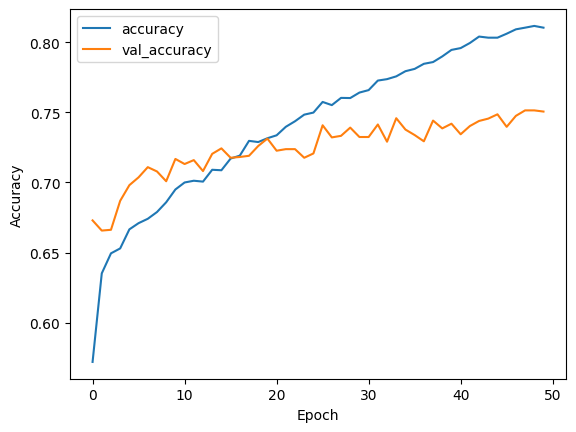

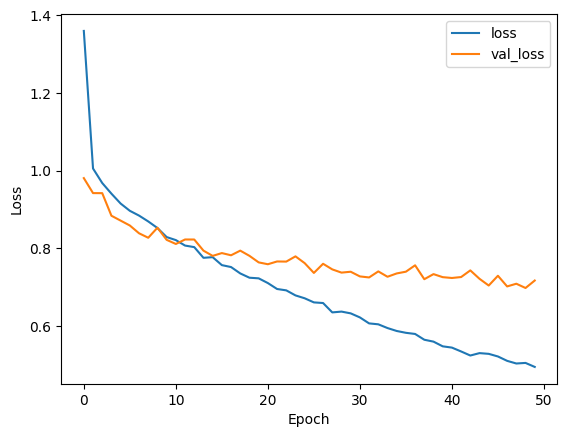

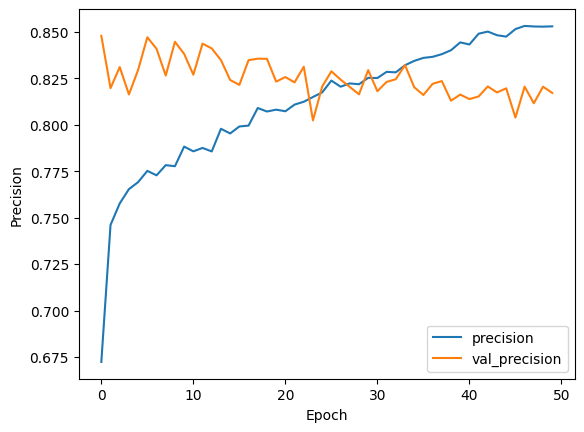

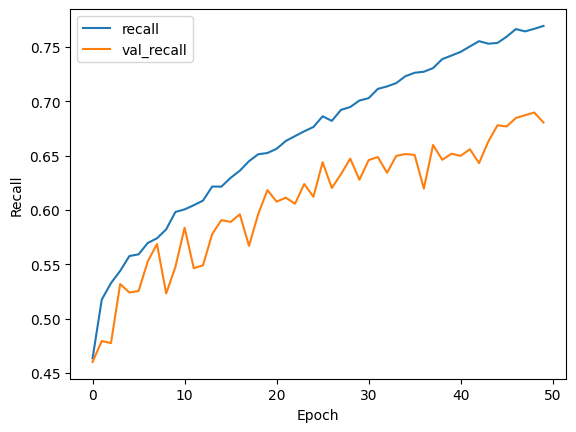

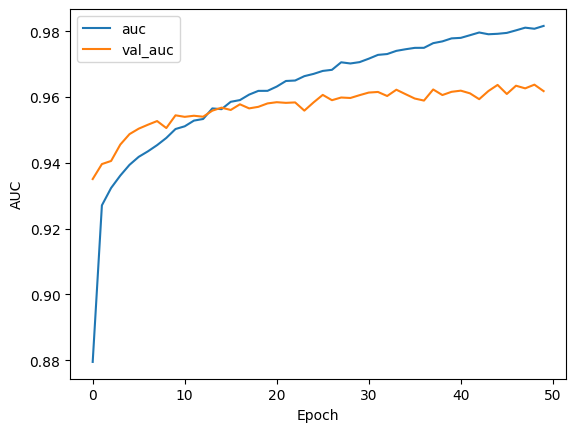

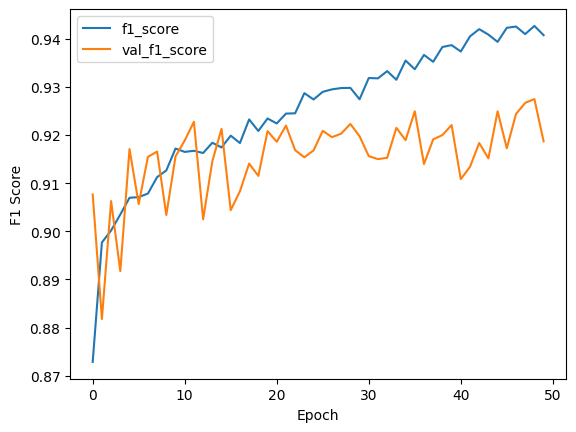

In [ ]:
# Plot the changes in metrics during training
import matplotlib.pyplot as plt

# Plot accuracy changes
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss changes
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Precision changes
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot Recall changes
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plot AUC changes
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Plot F1 Score changes
plt.plot(history.history['f1_score'], label='f1_score')
plt.plot(history.history['val_f1_score'], label='val_f1_score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

Evaluate Model Performance


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_data.columns[1:])

# Retrieve true labels and model predictions from the test dataset
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=8)
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_true_one_hot, axis=1)

# Calculate precision, recall, and F1 score for each class
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
print(report)

# Calculate the AUC for each category
roc_auc = roc_auc_score(y_true_one_hot, y_pred_prob, multi_class='ovr', average=None)

for idx, class_name in enumerate(label_encoder.classes_):
    print(f"[{class_name}] AUC ROC: {roc_auc[idx]}")


14/14 [==============================] - 2s 108ms/step
{'AK': {'precision': 0.6152796725784447, 'recall': 0.6854103343465046, 'f1-score': 0.6484543493889288, 'support': 658.0}, 'BCC': {'precision': 0.8268330733229329, 'recall': 0.8952702702702703, 'f1-score': 0.8596918085969181, 'support': 1776.0}, 'BKL': {'precision': 0.7517899761336515, 'recall': 0.65625, 'f1-score': 0.7007786429365962, 'support': 480.0}, 'DF': {'precision': 0.55, 'recall': 0.32116788321167883, 'f1-score': 0.4055299539170507, 'support': 137.0}, 'MEL': {'precision': 0.6268115942028986, 'recall': 0.44473007712082263, 'f1-score': 0.5203007518796993, 'support': 389.0}, 'NV': {'precision': 0.4411764705882353, 'recall': 0.5, 'f1-score': 0.46875, 'support': 30.0}, 'SCC': {'precision': 0.7333333333333333, 'recall': 0.5945945945945946, 'f1-score': 0.6567164179104478, 'support': 37.0}, 'VASC': {'precision': 0.4157303370786517, 'recall': 0.4805194805194805, 'f1-score': 0.44578313253012053, 'support': 77.0}, 'accuracy': 0.738560

Make Predictions and Evaluate the Model on the Test Set



In [ ]:
# Evaluate the model on the test set
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)

print(f"Loss on test set: {loss}")
print(f"Accuracy on test set: {accuracy}")
print(f"Precision on test set: {precision}")
print(f"Recall on test set: {recall}")
print(f"AUC on test set: {auc}")
print(f"F1 Score on test set: {f1_score}")


14/14 [==============================] - 3s 114ms/step - loss: 0.7054 - accuracy: 0.7386 - precision: 0.8142 - recall: 0.6724 - auc: 0.9632 - f1_score: 0.9154
Loss on test set: 0.7053583860397339
Accuracy on test set: 0.7385602593421936
Precision on test set: 0.8141891956329346
Recall on test set: 0.6724330186843872
AUC on test set: 0.9631901383399963
F1 Score on test set: 0.9153539538383484


In [ ]:
# Use the model to make predictions on the test set
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true_one_hot = np.concatenate([y for _, y in test_dataset], axis=0)
y_true = np.argmax(y_true_one_hot, axis=1)  # Convert one-hot encoding to integer labels

14/14 [==============================] - 2s 109ms/step


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate accuracy, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print(report)

              precision    recall  f1-score   support

          AK       0.62      0.69      0.65       658
         BCC       0.83      0.90      0.86      1776
         BKL       0.75      0.66      0.70       480
          DF       0.55      0.32      0.41       137
         MEL       0.63      0.44      0.52       389
          NV       0.44      0.50      0.47        30
         SCC       0.73      0.59      0.66        37
        VASC       0.42      0.48      0.45        77

    accuracy                           0.74      3584
   macro avg       0.62      0.57      0.59      3584
weighted avg       0.73      0.74      0.73      3584



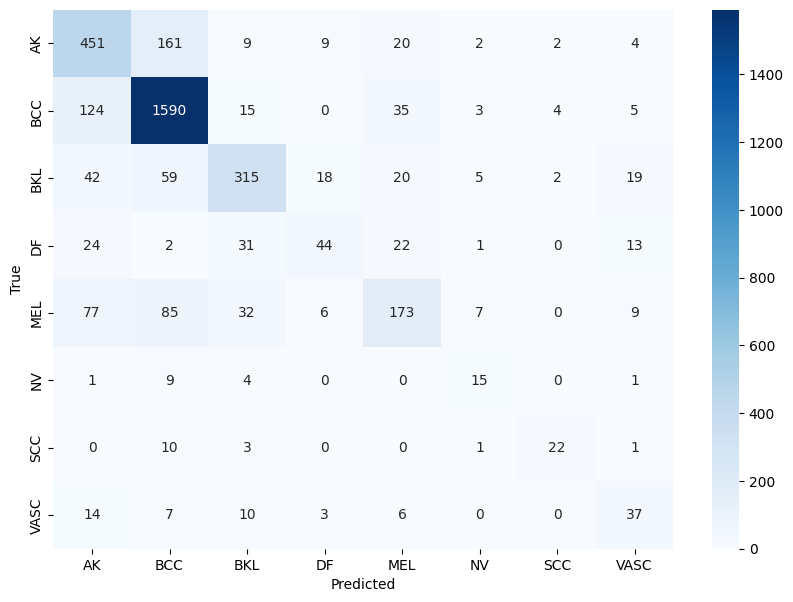

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plotting the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

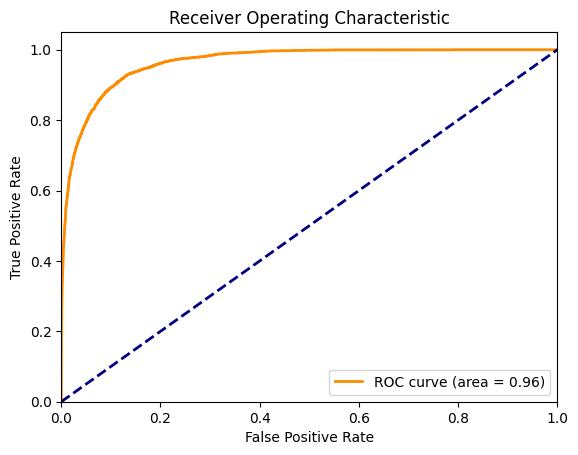

In [ ]:
# Plotting the ROC Curve (for each category)
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### 4.4.4 Processed Data - DenseNet201 With Fully Connected Layer



Train the DenseNet201 model using the augmented and balanced training dataset.

In [ ]:
with strategy.scope():
    model = create_densenet201_model(num_classes=8)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc'), F1Score(name='f1_score')])
    history = model.fit(balanced_train_dist,
                    validation_data=val_dist,
                    epochs=50,
                    steps_per_epoch=len(balanced_train_data) // GLOBAL_BATCH_SIZE,
                    validation_steps=len(val_data) // GLOBAL_BATCH_SIZE)


Epoch 1/50
86/86 [==============================] - 119s 437ms/step - loss: 1.5656 - accuracy: 0.4401 - precision: 0.6062 - recall: 0.2499 - auc: 0.8196 - f1_score: 0.9029 - val_loss: 1.1301 - val_accuracy: 0.5865 - val_precision: 0.7803 - val_recall: 0.3597 - val_auc: 0.9106 - val_f1_score: 0.8955
Epoch 2/50
86/86 [==============================] - 20s 233ms/step - loss: 1.2723 - accuracy: 0.5298 - precision: 0.6941 - recall: 0.3420 - auc: 0.8811 - f1_score: 0.9152 - val_loss: 1.0402 - val_accuracy: 0.6203 - val_precision: 0.8283 - val_recall: 0.4051 - val_auc: 0.9262 - val_f1_score: 0.9031
Epoch 3/50
86/86 [==============================] - 13s 146ms/step - loss: 1.1889 - accuracy: 0.5598 - precision: 0.7178 - recall: 0.3782 - auc: 0.8971 - f1_score: 0.9180 - val_loss: 1.0433 - val_accuracy: 0.6155 - val_precision: 0.8074 - val_recall: 0.4104 - val_auc: 0.9233 - val_f1_score: 0.9109
Epoch 4/50
86/86 [==============================] - 13s 147ms/step - loss: 1.1357 - accuracy: 0.5755 -

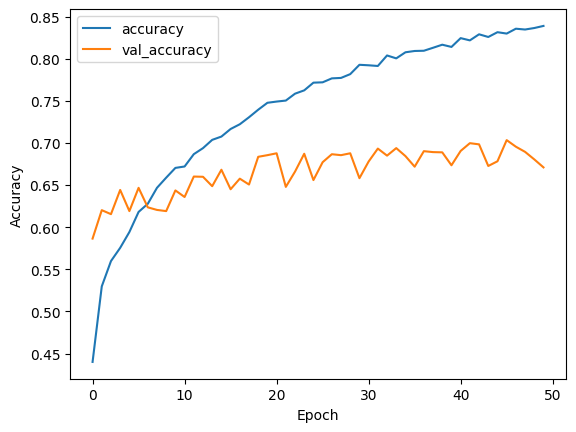

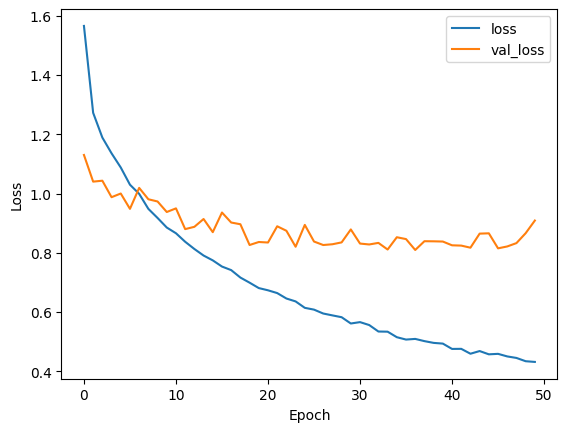

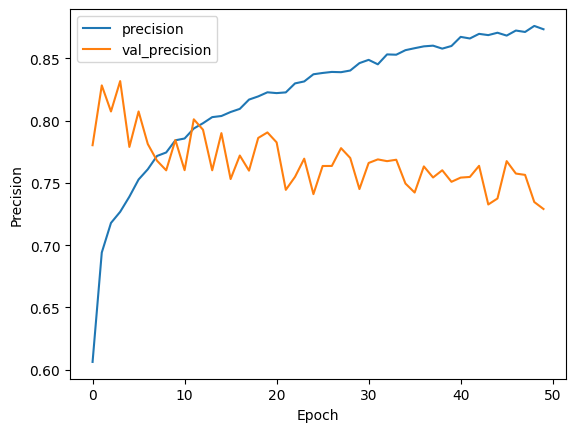

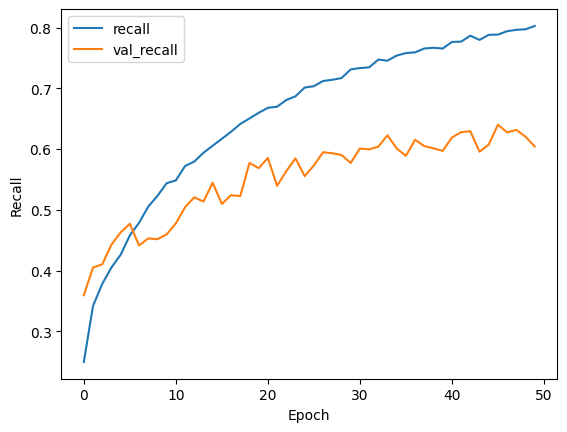

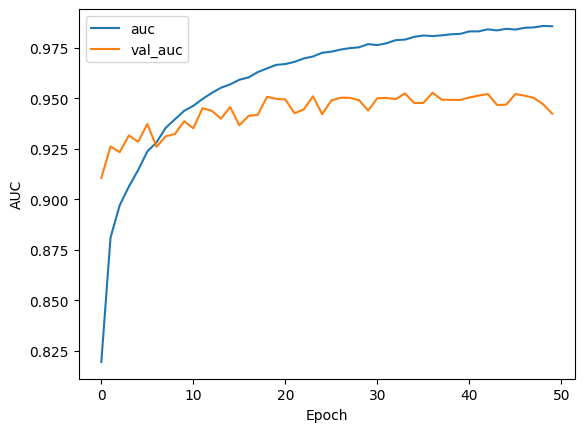

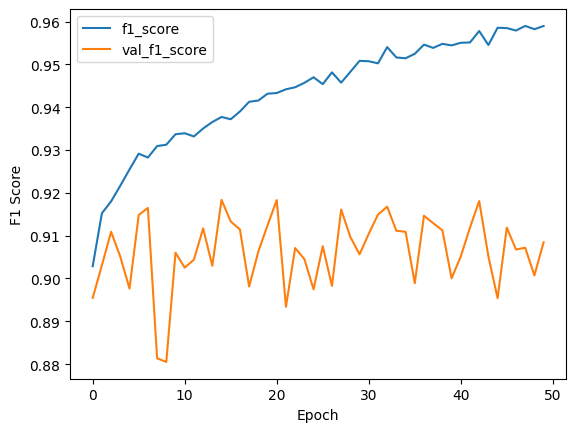

In [ ]:
# Plot the changes in metrics during training
import matplotlib.pyplot as plt

# Plot accuracy changes
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss changes
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Precision changes
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot Recall changes
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plot AUC changes
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Plot F1 Score changes
plt.plot(history.history['f1_score'], label='f1_score')
plt.plot(history.history['val_f1_score'], label='val_f1_score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_data.columns[1:])

# Calculate classification report and AUC ROC
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_labels = np.argmax(y_true, axis=1)  # Convert from one-hot encoding to integer labels

# Calculate precision, recall, and F1 score for each class
report = classification_report(y_true_labels, y_pred, target_names=label_encoder.classes_, output_dict=True)
print(report)

# Calculate AUC ROC for each class
roc_auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average=None)
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} AUC ROC: {roc_auc[idx]}")

14/14 [==============================] - 21s 109ms/step
{'AK': {'precision': 0.6115444617784711, 'recall': 0.5957446808510638, 'f1-score': 0.6035411855273286, 'support': 658.0}, 'BCC': {'precision': 0.8907672301690507, 'recall': 0.7713963963963963, 'f1-score': 0.8267954133977067, 'support': 1776.0}, 'BKL': {'precision': 0.6932084309133489, 'recall': 0.6166666666666667, 'f1-score': 0.6527012127894157, 'support': 480.0}, 'DF': {'precision': 0.41237113402061853, 'recall': 0.583941605839416, 'f1-score': 0.4833836858006042, 'support': 137.0}, 'MEL': {'precision': 0.5100222717149221, 'recall': 0.5886889460154242, 'f1-score': 0.5465393794749404, 'support': 389.0}, 'NV': {'precision': 0.4, 'recall': 0.6, 'f1-score': 0.48, 'support': 30.0}, 'SCC': {'precision': 0.5555555555555556, 'recall': 0.8108108108108109, 'f1-score': 0.6593406593406594, 'support': 37.0}, 'VASC': {'precision': 0.25, 'recall': 0.7662337662337663, 'f1-score': 0.37699680511182104, 'support': 77.0}, 'accuracy': 0.69029017857142

In [ ]:
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)

print(f"Loss on test set: {loss}")
print(f"Accuracy on test set: {accuracy}")
print(f"Precision on test set: {precision}")
print(f"Recall on test set: {recall}")
print(f"AUC on test set: {auc}")
print(f"F1 Score on test set: {f1_score}")

14/14 [==============================] - 3s 118ms/step - loss: 0.8367 - accuracy: 0.6903 - precision: 0.7491 - recall: 0.6197 - auc: 0.9505 - f1_score: 0.9123
Loss on test set: 0.8366888165473938
Accuracy on test set: 0.6902901530265808
Precision on test set: 0.7490724921226501
Recall on test set: 0.6196986436843872
AUC on test set: 0.9504571557044983
F1 Score on test set: 0.912250816822052


In [ ]:
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true_one_hot = np.concatenate([y for _, y in test_dataset], axis=0)
y_true = np.argmax(y_true_one_hot, axis=1)


14/14 [==============================] - 2s 110ms/step


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print(report)


              precision    recall  f1-score   support

          AK       0.61      0.60      0.60       658
         BCC       0.89      0.77      0.83      1776
         BKL       0.69      0.62      0.65       480
          DF       0.41      0.58      0.48       137
         MEL       0.51      0.59      0.55       389
          NV       0.40      0.60      0.48        30
         SCC       0.56      0.81      0.66        37
        VASC       0.25      0.77      0.38        77

    accuracy                           0.69      3584
   macro avg       0.54      0.67      0.58      3584
weighted avg       0.73      0.69      0.70      3584



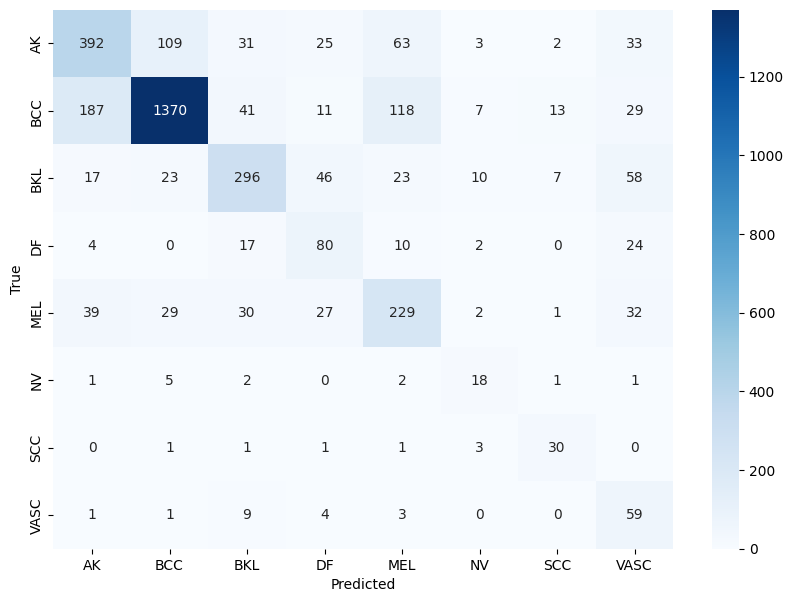

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

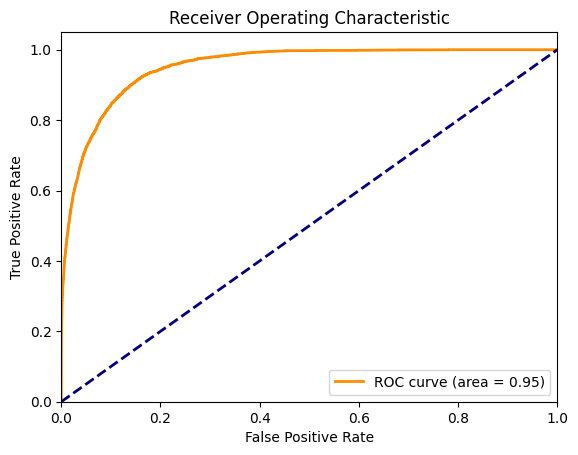

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### 4.4.5 DenseNet201 With Cubic SVM (Original and Processed Data)



Create a TensorFlow dataset for SVM training, including optional data augmentation and caching.


In [ ]:
def create_dataset_svm(data, labels, is_training=True, augment=False, batch_size=32, strategy=None):
    def _parse_function(filename, label):
        image = preprocess_image(filename)
        if is_training and augment:
            image = augment_image(image)
        return image, tf.cast(label, tf.float32)

    images = tf.constant(data.values)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

Feature Extraction using DenseNet201

Extract features from images using a pre-trained DenseNet201 model for use in SVM training.

This setup allows you to extract features from images using DenseNet201, which can then be used as input for an SVM or other machine learning models.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
import numpy as np

def extract_features(model, dataset):
    features = []
    labels = []

    for images, lbls in dataset:
        feature_batch = model.predict(images)
        features.append(feature_batch)
        labels.append(lbls)

    return np.vstack(features), np.concatenate(labels)

with strategy.scope():
    base_model = DenseNet201(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
    feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)


Extract Features for SVM Training

Create datasets for SVM training, and use a pre-trained DenseNet201 model to extract features.

This process prepares the datasets and extracts the necessary features using a pre-trained DenseNet201 model, making them ready for SVM training.

In [ ]:
original_train_dataset = create_dataset_svm(train_data['image'], train_labels, is_training=True, augment=False, batch_size=GLOBAL_BATCH_SIZE)
balanced_train_dataset = create_dataset_svm(balanced_train_data['image'], balanced_train_labels, is_training=True, augment=True, batch_size=GLOBAL_BATCH_SIZE)

with strategy.scope():
    original_train_features, original_train_labels = extract_features(feature_extractor, original_train_dataset)
    balanced_train_features, balanced_train_labels = extract_features(feature_extractor, balanced_train_dataset)
    test_features, test_labels = extract_features(feature_extractor, test_dataset)

8/8 [==============================] - 1s 40ms/step


Train SVM Models on Extracted Features

Train SVM models using features extracted from the DenseNet201 model on both the original and balanced training datasets.

This setup allows for training SVM models on features extracted from both the original and balanced datasets, enabling comparison of their performance on downstream tasks.

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Conversion of Labels: From One-Hot Encoding to Integer Labels
original_train_labels = np.argmax(original_train_labels, axis=1)
balanced_train_labels = np.argmax(balanced_train_labels, axis=1)

svm_model_original = make_pipeline(StandardScaler(), svm.SVC(kernel='poly', degree=3, C=1.0, probability=True))
svm_model_original.fit(original_train_features, original_train_labels)

svm_model_balanced = make_pipeline(StandardScaler(), svm.SVC(kernel='poly', degree=3, C=1.0, probability=True))
svm_model_balanced.fit(balanced_train_features, balanced_train_labels)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='poly', probability=True))])

Evaluate SVM Models on Test Set

Evaluate the performance of SVM models trained on original and balanced datasets using the test set.

This process provides a comprehensive evaluation of the SVM models, allowing you to compare their performance on various metrics and determine the impact of data balancing.


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Assume train_labels and test_labels are initially in one-hot encoding format
train_labels_integer = np.argmax(train_labels, axis=1)
test_labels_integer = np.argmax(test_labels, axis=1)

# Using LabelEncoder
label_encoder = LabelEncoder()
# Fit the LabelEncoder using train_labels_integer
label_encoder.fit(train_labels_integer)

def evaluate_model(model, test_features, test_labels_integer, label_encoder):
    y_pred = model.predict(test_features)  # Predicted labels
    y_pred_prob = model.predict_proba(test_features)  # Predicted probabilities

    # Calculate overall accuracy
    accuracy = accuracy_score(test_labels_integer, y_pred)
    print(f"Accuracy: {accuracy}")

    # Ensure class names are strings
    target_names = [str(cls) for cls in label_encoder.classes_]

    # Generate classification report
    report = classification_report(test_labels_integer, y_pred, target_names=target_names)
    print(report)

    # Calculate AUC, ensuring test_labels is converted to one-hot encoding
    test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_integer, num_classes=len(label_encoder.classes_))
    auc = roc_auc_score(test_labels_one_hot, y_pred_prob, multi_class='ovr', average=None)

    if isinstance(auc, np.ndarray):
        for idx, class_name in enumerate(target_names):
            print(f"{class_name} AUC ROC: {auc[idx]}")
    else:
        print("AUC ROC: ", auc)

    return report, auc

# Evaluate the model using integer labels
print("Original Training Set Model Evaluation")
report_original, auc_original = evaluate_model(svm_model_original, test_features, test_labels_integer, label_encoder)

print("Balanced Training Set Model Evaluation")
report_balanced, auc_balanced = evaluate_model(svm_model_balanced, test_features, test_labels_integer, label_encoder)

Original Training Set Model Evaluation
Accuracy: 0.7427455357142857
              precision    recall  f1-score   support

           0       0.73      0.55      0.62       658
           1       0.77      0.95      0.85      1776
           2       0.67      0.77      0.72       480
           3       0.71      0.31      0.43       137
           4       0.70      0.44      0.54       389
           5       1.00      0.07      0.12        30
           6       1.00      0.27      0.43        37
           7       0.91      0.26      0.40        77

    accuracy                           0.74      3584
   macro avg       0.81      0.45      0.51      3584
weighted avg       0.74      0.74      0.72      3584

0 AUC ROC: 0.9106896143370308
1 AUC ROC: 0.9405681954077971
2 AUC ROC: 0.961659015249141
3 AUC ROC: 0.9393696835712425
4 AUC ROC: 0.9162774418576584
5 AUC ROC: 0.9441286812980679
6 AUC ROC: 0.9890124124688545
7 AUC ROC: 0.9635682253304152
Balanced Training Set Model Evaluation
Acc

# 5 Results

## 5.1 Original Data

| Original Data        | VGG16   | VGG16 + Cubic SVM | ResNet50 | ResNet50 + Cubic SVM | ResNet101 | ResNet101 + Cubic SVM | DenseNet201 | DenseNet201 + Cubic SVM |
|----------------|---------|-------------------|----------|----------------------|-----------|-----------------------|-------------|-------------------------|
| F1             | 0.6628  | 0.6270            | 0.6590   | 0.69               | 0.7524    | 0.6812                | 0.9154      | 0.72                  |
| Accuracy       | 65.56%  | 66.53%            | 68.27%   | 71.98%               | 94.04%    | 71.03%                | 73.86%      | 74.27%                  |
| Average AUC    | 0.8847  | 0.8780            | 0.8985   | 0.9225               | 0.9350    | 0.9124                | 0.9632      | 0.9457                  |
|     |   |             |    |                |     |                 |       |                   |
| AUC - Class 1  | 0.8491  | 0.8426            | 0.8050   | 0.8805               | 0.8861    | 0.8788                | 0.9046      | 0.9107                  |
| AUC - Class 2  | 0.8942  | 0.8958            | 0.9057   | 0.9242               | 0.9367    | 0.9210                | 0.9416      | 0.9406                  |
| AUC - Class 3  | 0.9242  | 0.9163            | 0.9466   | 0.9433               | 0.9604    | 0.9381                | 0.9589      | 0.9617                  |
| AUC - Class 4  | 0.8952  | 0.8990            | 0.8905   | 0.9163               | 0.9280    | 0.9204                | 0.9435      | 0.9394                  |
| AUC - Class 5  | 0.8370  | 0.8297            | 0.8353   | 0.8860               | 0.9015    | 0.8833                | 0.9014      | 0.9163                  |
| AUC - Class 6  | 0.8856  | 0.8636            | 0.9503   | 0.9225               | 0.9578    | 0.8831                | 0.9302      | 0.9441                  |
| AUC - Class 7  | 0.9300  | 0.8796            | 0.9589   | 0.9573               | 0.9781    | 0.9716                | 0.9866      | 0.9890                  |
| AUC - Class 8  | 0.9114  | 0.8978            | 0.8960   | 0.9501               | 0.9314    | 0.9459                | 0.9521      | 0.9636                  |


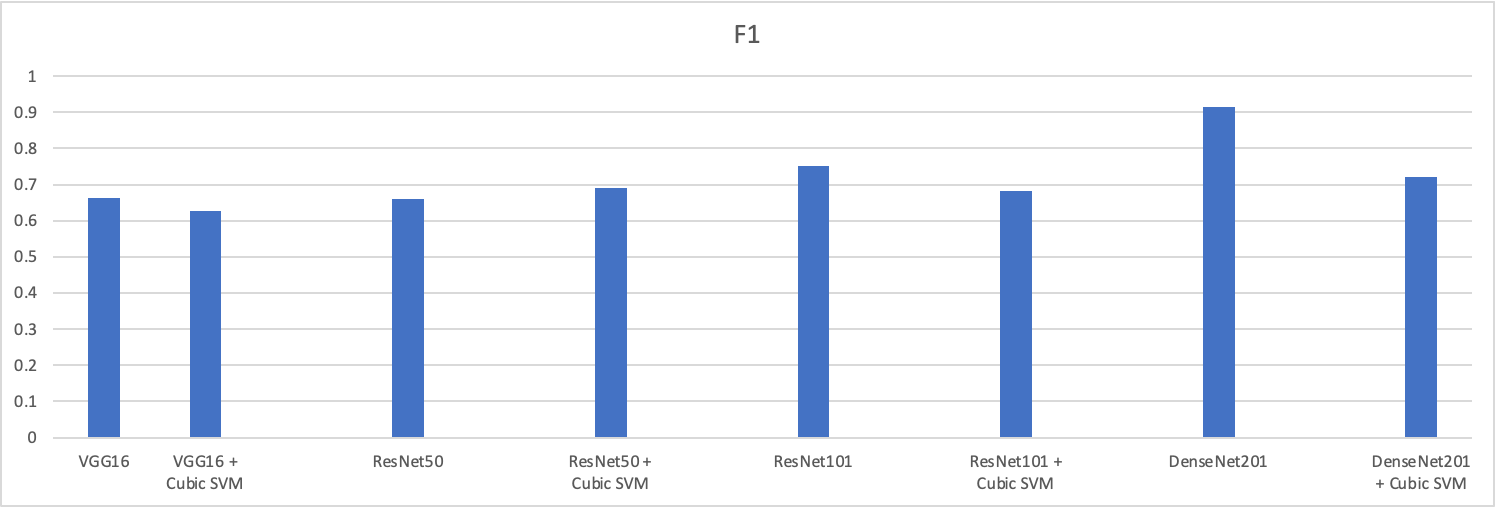

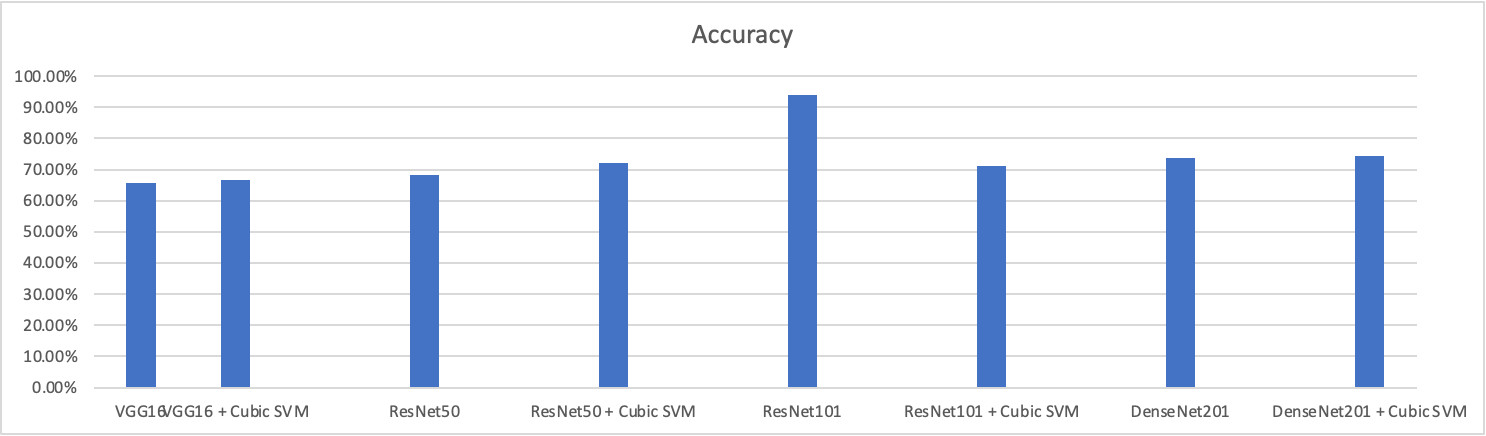

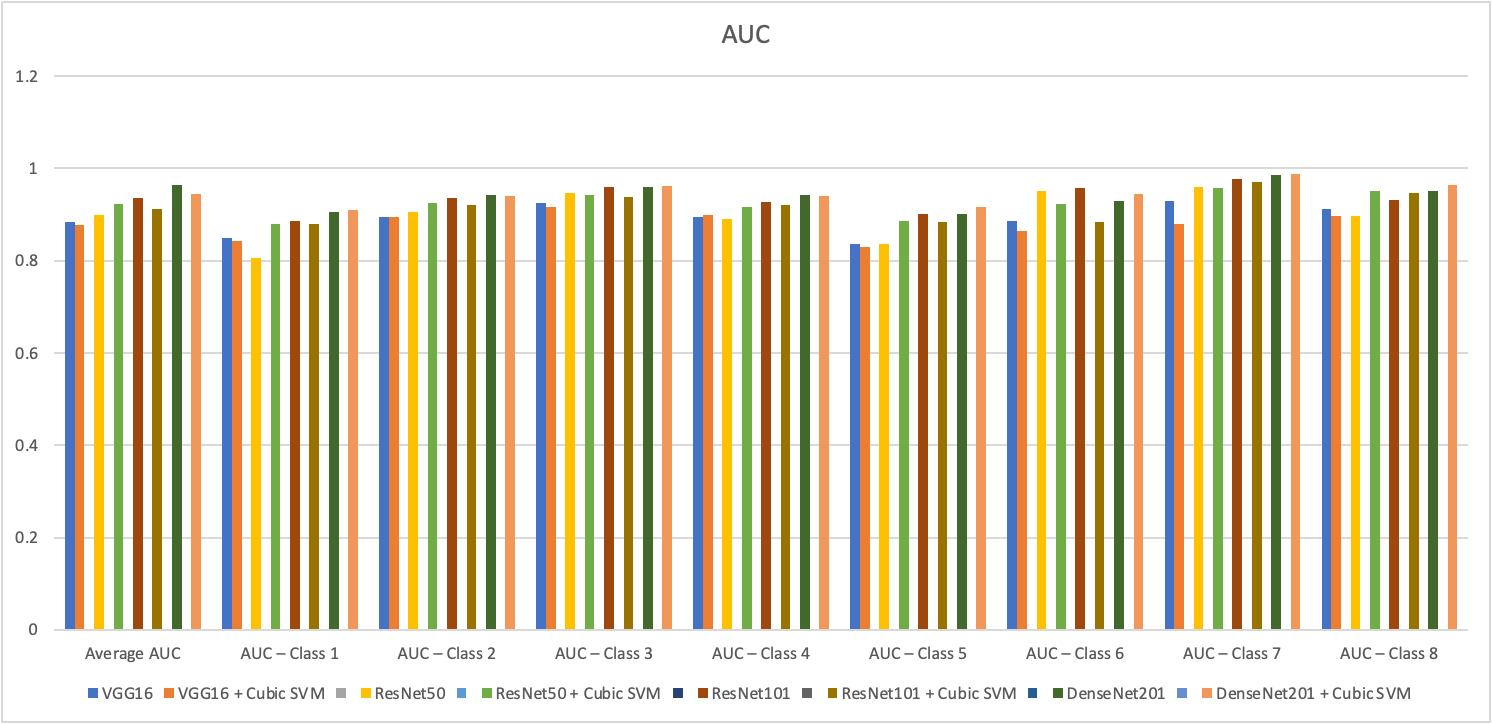

## 5.2 Processed Data

| Propossed Data        | VGG16   | VGG16 + Cubic SVM | ResNet50 | ResNet50 + Cubic SVM | ResNet101 | ResNet101 + Cubic SVM | DenseNet201 | DenseNet201 + Cubic SVM |
|---------------|---------|-------------------|----------|----------------------|-----------|-----------------------|-------------|-------------------------|
| F1            | 0.6464  | 0.6409            | 0.7851   | 0.7100               | 0.7524    | 0.6973                | 0.9123      | 0.7400                  |
| Accuracy      | 64.42%  | 66.79%            | 78.86%   | 72.19%               | 95.10%    | 70.42%                | 69.03%      | 74.00%                  |
| AUC           | 0.8879  | 0.8806            | 0.9565   | 0.9192               | 0.9531    | 0.9053                | 0.9505      | 0.9445                  |
| AUC - Class 1 | 0.9053  | 0.8441            | 0.9685   | 0.9299               | 0.9597    | 0.9204                | 0.8822      | 0.9008                  |
| AUC - Class 2 | 0.9063  | 0.8985            | 0.9783   | 0.9403               | 0.9735    | 0.9356                | 0.9307      | 0.9332                  |
| AUC - Class 3 | 0.8241  | 0.9062            | 0.9290   | 0.8839               | 0.9315    | 0.8707                | 0.9427      | 0.9517                  |
| AUC - Class 4 | 0.9003  | 0.8988            | 0.9744   | 0.9184               | 0.9633    | 0.9187                | 0.9455      | 0.9422                  |
| AUC - Class 5 | 0.8126  | 0.8038            | 0.9050   | 0.8679               | 0.9049    | 0.8581                | 0.8923      | 0.9109                  |
| AUC - Class 6 | 0.8975  | 0.8893            | 0.9398   | 0.9211               | 0.9494    | 0.9185                | 0.9306      | 0.9650                  |
| AUC - Class 7 | 0.8962  | 0.8849            | 0.9666   | 0.9336               | 0.9467    | 0.9218                | 0.9922      | 0.9883                  |
| AUC - Class 8 | 0.9611  | 0.9189            | 0.9903   | 0.9585               | 0.9960    | 0.9335                | 0.9562      | 0.9635                  |


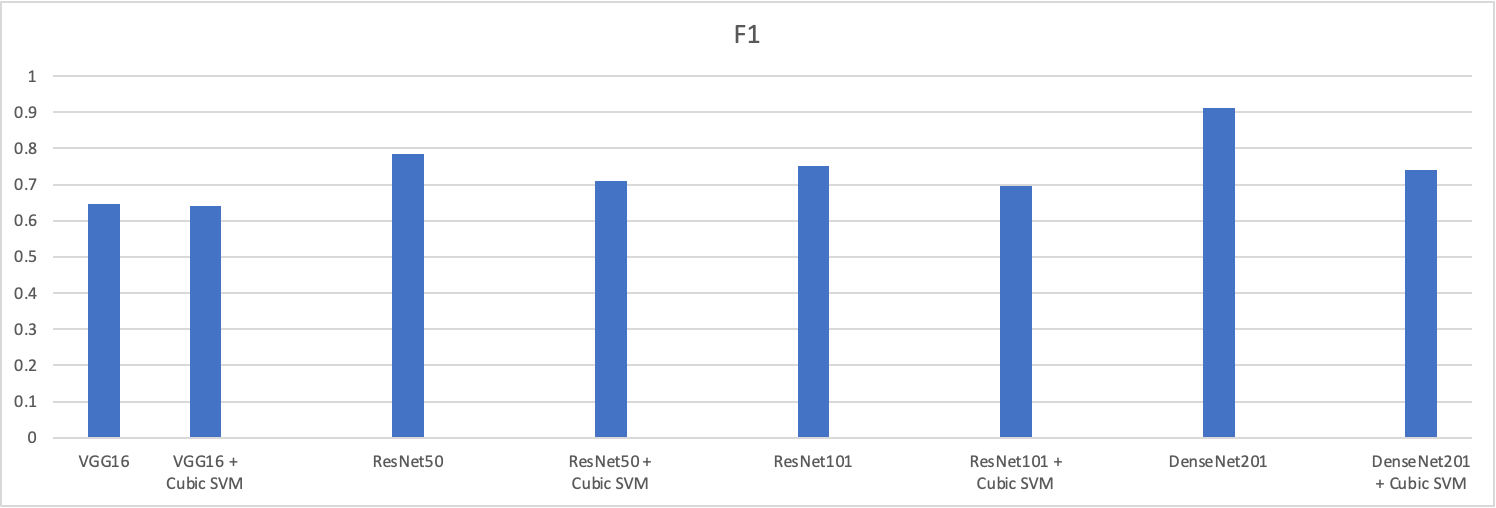

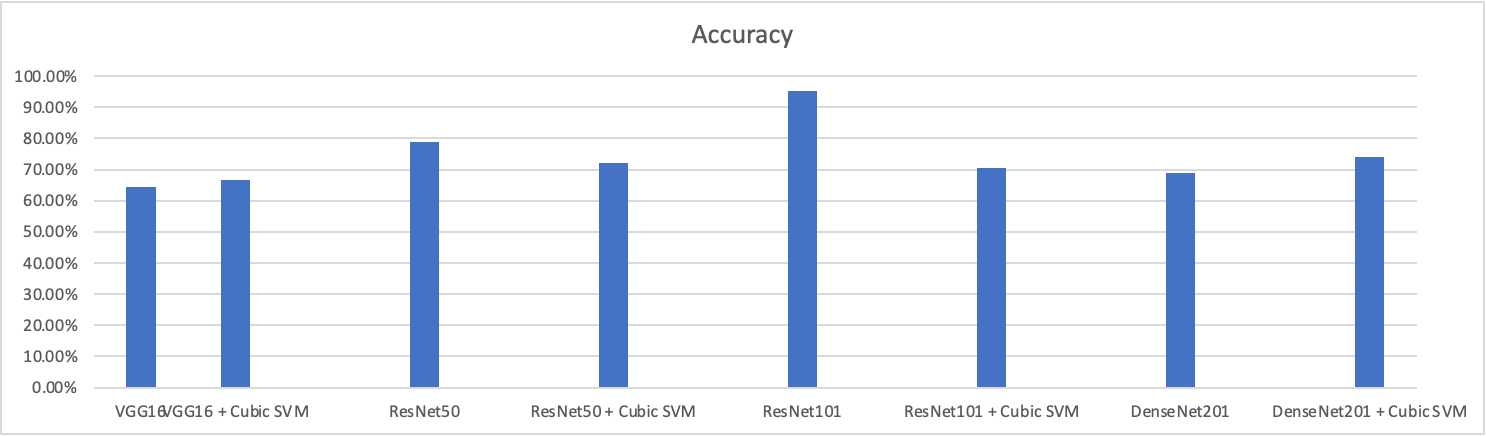

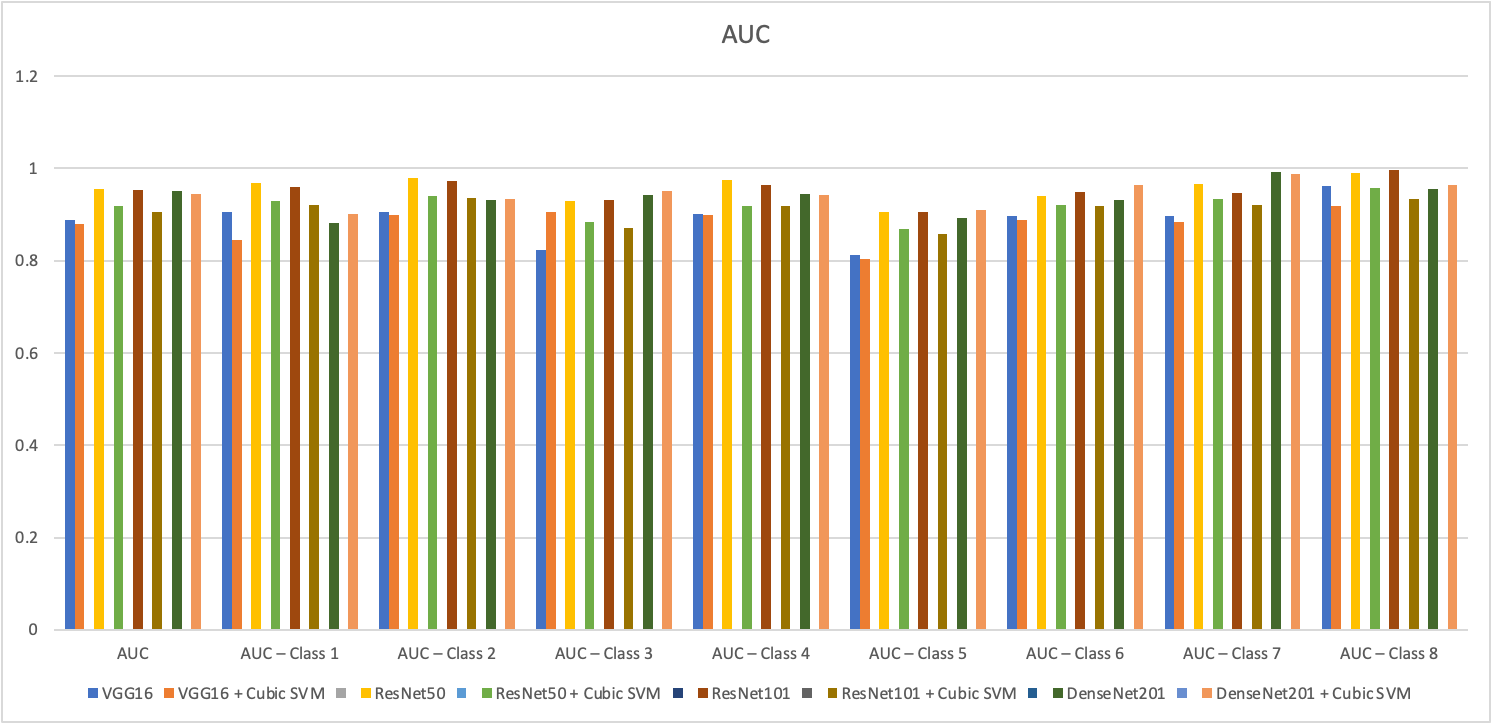

## 5.3 Final Result

From the results of 8 different models for both original data and processed data, the best performance combination is ResNet101 and Fully Connected Layer.

# 6 Discussion

**Original Data VS Processed Data**:<br>
For every combination, it has been demonstrated that the processed data performance is better than the original data set, which means the data processing methods did a good job.

**Different feature extraction**:<br>
Based on the same data set, ResNet101 has the best result for classification, followed by DenseNet201, and Resnet50. VGG16 is not good for this dataset because of its poor architecture compared with others.

**Classification Methods**:<br>
In this project, the fully connected layer performs better than the Cubic SVM.

Because of the limitation of data size and computation resources, the results may change with additional datasets or computation resources. However, it clearly shows the relationship between different feature extraction and classification methods, which provides a method for future classification problems in the medical field, especially for skin lesions.  


# 7 Reference


\[1\]: https://challenge.isic-archive.com/data/#2019 <br>
\[2\]: Youngseok Lee, Jongweon Kim, PSI Analysis of Adversarial-Attacked DCNN Models, Applied Sciences 2023,13,9722, Page 4<br>
\[3\]: He, K., Zhang, X., Ren, S., Sun, J., 2016. Deep residual learning for image recognition. IEEE Conference on Computer Vision and Pattern Recognition (CVPR) 770-778 <br>
\[4\]: Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, “Deep Residual Learning for Image Recognition”, CVPR 2016, Page 775<br>
\[5\]: Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, “Deep Residual Learning for Image Recognition”, CVPR 2016, Page 773 <br>
\[6\]:https://www.researchgate.net/figure/Detailed-architecture-of-an-Efficient-DenseNet-201_fig3_360070131